<a href="https://colab.research.google.com/github/Enzo2806/KNN-DecisionTree/blob/main/KNN%20-%20Decision%20Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Acquire, preprocess and analyze data

Installing the dependencies used through the assignment.

In [ ]:
# To suppress stdout of the cell
%%capture 

# Installed packages
!pip install matplotlib numpy pandas # Plotting
!pip install scipy sklearn # Result analysis and data splitting
!pip install seaborn # Heatmaps
!pip install git+https://github.com/MaxHalford/Prince # FAMD for dimentionality reduction

Importing the required modules.

In [ ]:
# Imports
import pandas as pd # Pre-processing
import numpy as np # Data manipulation
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
from io import StringIO, BytesIO # Parsing inputs
import urllib.request # Parsing inputs
from scipy.io.arff import loadarff # Parsing inputs
import seaborn as sns # Heatmaps
from sklearn.decomposition import PCA # Dimensionality reduction
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc # Performance analysis
from prince import FAMD # For dimensionality reduction of mixed continuous and categorical data
from sklearn.model_selection import train_test_split # For splitting into training and testing sets
from sklearn.ensemble import RandomForestClassifier # For MDI (Feature importance)
from sklearn.inspection import permutation_importance # Again for feature importance

## 1.1 Data Preprocessing for the hepatitis dataset

Extracting the raw data from the hepatitis [[1]](http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis) dataset, and creating lists separating the continuous and categorical features.

In [ ]:
# Read csv dataset
df_hepatitis = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data')

# Rename the columns
df_hepatitis.columns = ['class', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'big_liver', 
               'firm_liver', 'palpable_spleen', 'spiders', 'ascites', 'varices', 'bilirubin', 'alk_phosphate',
               'sgot', 'albumin', 'protime', 'histology'] 

# Continuous features (For later use)
continuous_features_hepatitis = ['age', 'bilirubin', 'protime', 'albumin', 'alk_phosphate', 'sgot']

# Categorical features (For later use)
categorical_features_hepatitis = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'big_liver', 
                        'firm_liver', 'palpable_spleen', 'spiders', 'ascites', 'varices', 'histology']

We will now define the following function that will be used throughout the notebook to remove a feature from the continuous / discrete feature lists.

In [ ]:
# To remove a feature from the lists containing the continuous or categorical features when we decide to remove that feature from one of the datasets
# The dataset argument is passed to reuse this method for the second dataset later in the notebook
def remove_feature(name, dataset):
  if dataset == "hepatitis":
    if name in continuous_features_hepatitis:
      continuous_features_hepatitis.remove(name)
    elif name in categorical_features_hepatitis:
      categorical_features_hepatitis.remove(name)
  elif dataset == "diabetes":
    if name in continuous_features_diabetes:
      continuous_features_diabetes.remove(name)
    elif name in categorical_features_diabetes:
      categorical_features_diabetes.remove(name)

This function works for both dataframes because of the second argument (`hepatitis` and `diabetes` for the hepatitis and diabetes datasets respectively).

We will now drop the duplicates (If they exist) and proceed to visualize the head of the first dataframe in order to get an intuition for the data provided.

In [ ]:
# Drop duplicates
df_hepatitis.drop_duplicates(inplace=True)

# Take a peek at the hepatitis dataframe
df_hepatitis.head()

class  age  sex steroid  antivirals fatigue malaise anorexia big_liver  \
0      2   50    1       1           2       1       2        2         1   
1      2   78    1       2           2       1       2        2         2   
2      2   31    1       ?           1       2       2        2         2   
3      2   34    1       2           2       2       2        2         2   
4      2   34    1       2           2       2       2        2         2   

  firm_liver palpable_spleen spiders ascites varices bilirubin alk_phosphate  \
0          2               2       2       2       2      0.90           135   
1          2               2       2       2       2      0.70            96   
2          2               2       2       2       2      0.70            46   
3          2               2       2       2       2      1.00             ?   
4          2               2       2       2       2      0.90            95   

  sgot albumin protime  histology  
0   42     3.5       ?          1  
1   32     4.0       ?          1  
2   52     4.0      80          1  
3  200     4.0       ?          1  
4   28     4.0      75          1

We notice the presence of `?` symbols to represent missing data. We will first proceed to replace those with `NaN`'s, and then visualize information about the proportion of missing information.

In [ ]:
# Replace the question marks with NaN so that pandas understands that it's missing data
df_hepatitis.replace('?', np.nan, inplace=True)

# Print number of rows with NaNs
print(f"There are {df_hepatitis.isnull().any(axis=1).sum()} rows out of {df_hepatitis.shape[0]} that have NaN values\n")

# Print dataframe information (To see feature types)
df_hepatitis.info()

There are 74 rows out of 154 that have NaN values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   class            154 non-null    int64 
 1   age              154 non-null    int64 
 2   sex              154 non-null    int64 
 3   steroid          153 non-null    object
 4   antivirals       154 non-null    int64 
 5   fatigue          153 non-null    object
 6   malaise          153 non-null    object
 7   anorexia         153 non-null    object
 8   big_liver        144 non-null    object
 9   firm_liver       143 non-null    object
 10  palpable_spleen  149 non-null    object
 11  spiders          149 non-null    object
 12  ascites          149 non-null    object
 13  varices          149 non-null    object
 14  bilirubin        148 non-null    object
 15  alk_phosphate    125 non-null    object
 16  sgot             150 non-null

We notice that around half the input data has `NaN` values. We also can see that the `protime` column is dominating most of those rows, with 66 missing values out of 154. Consequently, it would be better to remove that column from the data set. Finally, will also proceed to impute the missing data rather than remove it since removing it means we lose a lot of valuable information about the dataset.

Let's start by dropping the `protime` column from the first dataframe.

In [ ]:
# Start by dropping protime from the input data
df_hepatitis.drop("protime", axis = 1, inplace=True)
remove_feature("protime", "hepatitis")

# Preview the data to make sure everything went correctly
df_hepatitis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   class            154 non-null    int64 
 1   age              154 non-null    int64 
 2   sex              154 non-null    int64 
 3   steroid          153 non-null    object
 4   antivirals       154 non-null    int64 
 5   fatigue          153 non-null    object
 6   malaise          153 non-null    object
 7   anorexia         153 non-null    object
 8   big_liver        144 non-null    object
 9   firm_liver       143 non-null    object
 10  palpable_spleen  149 non-null    object
 11  spiders          149 non-null    object
 12  ascites          149 non-null    object
 13  varices          149 non-null    object
 14  bilirubin        148 non-null    object
 15  alk_phosphate    125 non-null    object
 16  sgot             150 non-null    object
 17  albumin          138 non-null    ob

Seems good, and `protime` was correctly dropped. However, we notice that most inputs have `object` type, which we'll need to fix.

The next step is now to impute [[2]](https://www.naukri.com/learning/articles/handling-missing-data-mean-median-mode/#Mean/-Median-/Mode-imputation) the remaining data and convert it to the correct type (`int` for categorical data, `float` for continuous data).

In [ ]:
# Convert all continuous features to floats, and all categorical inputs to integers
# Then proceed to replace the missing values for that feature with the mean of the column
for feature in continuous_features_hepatitis:
  df_hepatitis[feature] = df_hepatitis[feature].astype(float)
  df_hepatitis[feature] = df_hepatitis[feature].fillna(df_hepatitis[feature].mean())

# Replace missing categorical input variables with the most common occurence for the column
# Then proceed to convert the column to an integer type
for feature in categorical_features_hepatitis:
  mode = df_hepatitis[feature].value_counts().idxmax()
  df_hepatitis[feature] = df_hepatitis[feature].fillna(mode)
  df_hepatitis[feature] = df_hepatitis[feature].astype(int)

# Show the information about the dataframe
df_hepatitis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            154 non-null    int64  
 1   age              154 non-null    float64
 2   sex              154 non-null    int64  
 3   steroid          154 non-null    int64  
 4   antivirals       154 non-null    int64  
 5   fatigue          154 non-null    int64  
 6   malaise          154 non-null    int64  
 7   anorexia         154 non-null    int64  
 8   big_liver        154 non-null    int64  
 9   firm_liver       154 non-null    int64  
 10  palpable_spleen  154 non-null    int64  
 11  spiders          154 non-null    int64  
 12  ascites          154 non-null    int64  
 13  varices          154 non-null    int64  
 14  bilirubin        154 non-null    float64
 15  alk_phosphate    154 non-null    float64
 16  sgot             154 non-null    float64
 17  albumin         

Looks correct, with the types now `int` for categorical variables and `float` for continuous variables, and no more missing values in any of the columns.

We move on to replacing `2`'s and `1`'s for categorical features as well as the output class with `1`'s and `0`'s respectively in order to align the data with the diabetes dataset, as we will see in section 1.2 of the notebook when we process that dataset. Finally, we separate the inputs from the labels to get the standard format of data with features X and labels y.

In [ ]:
# Substract 1 from every categorical feature value & the output class column to turn 2's into 1's and 1's into 0's
for feature in categorical_features_hepatitis:
  df_hepatitis[feature] -= 1

# Substract 1 from the output label for the same reason as above
df_hepatitis["class"] -= 1


# Separate features and labels
y_hepatitis = df_hepatitis["class"]
X_hepatitis = df_hepatitis.drop("class", axis = 1)

# Take a peek to make sure everything went correctly
X_hepatitis.head()


age  sex  steroid  antivirals  fatigue  malaise  anorexia  big_liver  \
0  50.0    0        0           1        0        1         1          0   
1  78.0    0        1           1        0        1         1          1   
2  31.0    0        1           0        1        1         1          1   
3  34.0    0        1           1        1        1         1          1   
4  34.0    0        1           1        1        1         1          1   

   firm_liver  palpable_spleen  spiders  ascites  varices  bilirubin  \
0           1                1        1        1        1        0.9   
1           1                1        1        1        1        0.7   
2           1                1        1        1        1        0.7   
3           1                1        1        1        1        1.0   
4           1                1        1        1        1        0.9   

   alk_phosphate   sgot  albumin  histology  
0        135.000   42.0      3.5          0  
1         96.000   32.0      4.0          0  
2         46.000   52.0      4.0          0  
3        105.488  200.0      4.0          0  
4         95.000   28.0      4.0          0

:The result shows that missing values were replaced properly, and that splitting the data into features and labels was successful.

We will now filter out highly correlated input features. This is necessary because such features act as independent variables doing the same work [[3]](https://www.projectpro.io/recipesdrop-out-highly-correlated-features-in-python). In other words, if 2 features are highly correlated, it means that they give us the same information, and one of them is redundant. We thus must remove one of them in order to avoid overfitting. To achieve the above, we will start by defining the two functions below that will be reused later for the diabetes dataset to avoiding code duplication.


In [ ]:
# Private helper function that checks whether feature i and feature j of X are highly correlated, and deletes feature j if they are from X as well as 
# the lists of features defined at the start of the section.
# Parameters: X (Input vectors)
#             X_corr (Correlation matrix of X)
#             i (Index of first feature to evaluate)
#             j (Index of second feature to evaluate)
#             dataset ("hepatitis" or "diabetes" depending on whether hepatitis or diabetes dataset, respectively)
#             strong_correlation_threshold (The threshold based on which to filter out values)
# Return value: True if high correlation was detected and a feature was deleted, False otherwise
def _check_high_correlation_(X, X_corr, i, j, dataset, strong_correlation_threshold):
  
  # If features i and j are too correlated
  if abs(X_corr.iloc[i, j]) > strong_correlation_threshold:

    # Print information about dropping one of them
    print(f"{X.columns[i]} and {X.columns[j]} are highly correlated with correlation {X_corr.iloc[i, j]}.\nDropping {X.columns[j]} from the dataframe.")
    
    # Remove it from the lists of features at the top of the code (Before dropping it from the X dataframe)
    remove_feature(X.columns[j], dataset)
   
    # Drop it
    X.drop(X.columns[j], axis = 1, inplace = True)

    # Return True if a feature got deleted
    return True

  else:

    # Return False if not correlated enough
    return False

# Function that checks whether X (Input matrix) contains two features that are too correlated. If so, it deletes one of them from the matrix using the above helper function.
# Note: This function only deletes the FIRST pair of highly correlated features it finds
# Parameters: X (Input vectors)
#             X_corr (Correlation matrix of X)
#             dataset ("hepatitis" / "diabetes" depending on whether it's the hepatitis or diabetes dataset, respectively)
#             strong_correlation_threshold (The threshold based on which to filter out values)
# Return value: True if high correlation was detected in any combination of two columns and a feature was deleted, False otherwise
def find_high_corr_pair(X, X_corr, dataset, strong_correlation_threshold):

  # Iterate over the columns of X
  for i in range(len(X.columns)):

    # Iterate from 0 to i-1 (Upper triangular matrix of X_corr, avoiding the main diagonal)
      for j in range(i):

        # Call helper to check if features i and j are highly correlated and one of them got deleted, return True in that case
        if(_check_high_correlation_(X, X_corr, i, j, dataset, strong_correlation_threshold)): return True

  # Return false if no pair of features was found with high correlation
  return False

We also create the function `corr_heatmap` to visualize the correlations between the features as a heatmap [[4]](https://seaborn.pydata.org/generated/seaborn.heatmap.html), [[5]](https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap). We then call it on the hepatitis feature correlation matrix.

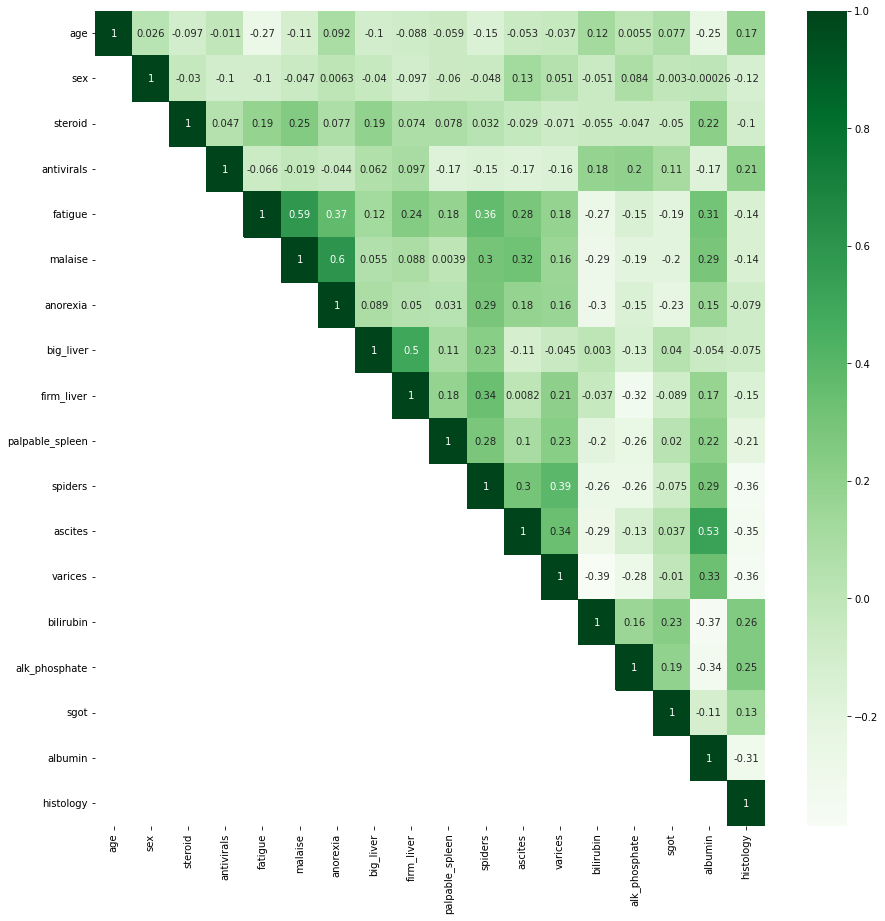

In [ ]:
# This function takes as input a correlation matrix and plots it
# It plots a heatmap to illustrate the correlation between the feautres
def corr_heatmap(corr):
  mask = np.tri(corr.shape[0], k=-1) # Mask for the lower triangular part the correlation matrix (which is just the mirror of the upper part) 
  plt.figure(figsize=(15,15))
  sns.heatmap(corr, mask=mask, cmap="Greens", annot=True) # Draw the heatmap with the mask using the sns library
  plt.show()

corr_heatmap(X_hepatitis.corr()) # Call the function on the first dataset's correlation matrix


The graph helps us vizualizing the correlation relationship between features. We will now proceed to filter out highly correlated input feature combinations using the previously defined functions. We choose 0.6 as our threshold for dropping features because correlations higher than that number will be considered as strong [[6]](https://www.researchgate.net/figure/Guidance-of-correlation-coefficient-interpretation_tbl1_322638699). Anything lower than 0.6 is thus acceptable by this standard, inclusive.

In [ ]:
# Variable parameter
strong_correlation_threshold_hepatitis = 0.6

# Keep track of how many features were deleted
num_dropped = 0

# Keep deleting features till no pair has a correlation higher than the threshold
while True:
  
  X_hepatitis_corr = X_hepatitis.corr() # Compute the pearson correlation matrix of the filtered dataset
  
  # If we find no correlated pairs, break the loop
  if not (find_high_corr_pair(X_hepatitis, X_hepatitis_corr, "hepatitis", strong_correlation_threshold_hepatitis)):
    break

  # Otherwise, add 1 to the number of features dropped, and recompute the correlation matrix (Next iteration)
  num_dropped += 1

# Print out the resulting shape of the dataframe
print(f"All in all, we dropped {num_dropped} feature(s) and are left with {X_hepatitis.shape[1]} features.")

All in all, we dropped 0 feature(s) and are left with 18 features.


Above, we can see that no features were dropped, which means our input dataset doesn't contain any pairs of features with correlation higher than the set threshold.

The next step is now to drop features that have low correlation with the output label (In absolute value), because such features are not good indicators of whether a patient died or survived [[7]](https://researchcommons.waikato.ac.nz/handle/10289/15043).

In [ ]:
# Variable parameter
weak_correlation_threhold_hepatitis = 0.1

# Function that removes a feature from X and removes it from the feature lists at the start 
# of the pre-processing section
def remove_weak_correlation_feature(feature):
    X_hepatitis.drop(feature, axis = 1, inplace = True) # drop from X
    remove_feature(feature, "hepatitis") # Remove it from the lists of features at the start of the pre-processing section


# Extract the correlation of every feature with the output class
# df_hepatitis.corr() returns the correlation of each possible pair of columns
# Selecting the class column from the above leaves us with the correlation of each column with class
# iloc[1:] then filters out the correlation of class with itself
hepatitis_class_corr = df_hepatitis.corr()['class'].iloc[1:]

# Compute the features with very low correlation to the output label
weak_features_dict = hepatitis_class_corr[abs(hepatitis_class_corr) < weak_correlation_threhold_hepatitis].to_dict()

# Drop those features from the X dataframe if they weren't removed in the previous code snippet
num_dropped = 0
for feature, corr in weak_features_dict.items():
  if feature in X_hepatitis.columns:
    print(f"Feature {feature} has very low correlation {corr} with the label and will be dropped.")
    remove_weak_correlation_feature(feature) # Function defined above
    num_dropped += 1
  else:
    print(f"Feature {feature} has very low correlation {corr} with the label but was already dropped in the previous step because of high correlation with another feature.")

# Print out the resulting shape of the dataframe
print(f"All in all, we dropped {num_dropped} feature(s) and are left with {X_hepatitis.shape[1]} features.")

Feature big_liver has very low correlation -0.08767771540168028 with the label and will be dropped.
Feature firm_liver has very low correlation 0.017475088984917935 with the label and will be dropped.
Feature sgot has very low correlation -0.07332777618181045 with the label and will be dropped.
All in all, we dropped 3 feature(s) and are left with 15 features.


Again, we can see which features were dropped above for having a too low correlation with the output label. We can now start visualizing information about the data we have. 

We will start by looking at a bar chart showing the proportions of each output label.

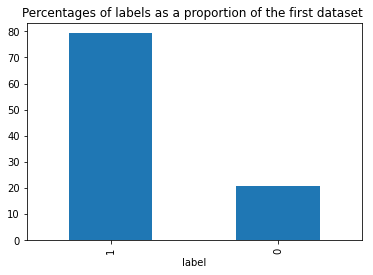

In [ ]:
# Extracting the percentage of each class in the dataset
# Normalize=True converts the counts to proportions and * 100 converts to percentages
class_percentages_hepatitis = y_hepatitis.value_counts(normalize=True) * 100 
class_percentages_hepatitis.plot(kind='bar', xlabel='label', title='Percentages of labels as a proportion of the first dataset ')

As can be seen above, we have ~ 80% alive labels compared to ~ 20 % dead labels (Data imbalance). This means that the ROC curve won't give us meaningful information later on, and that we will have to resort to using the Precision-Recall curve when evaluating models using this dataset [[8]](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python). 

We can now visualize the distributions of the different input features, starting with the continuous features [[9]](https://www.machinelearningplus.com/plots/matplotlib-histogram-python-examples).

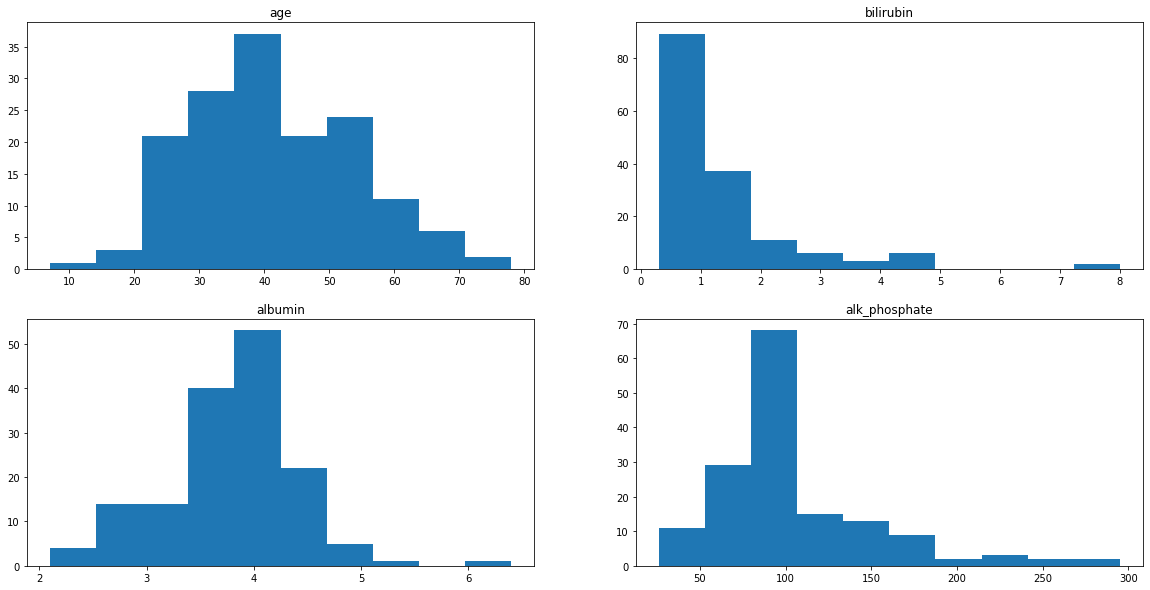

In [ ]:
# Figure size
plt.figure(figsize=(20,10))

# Number of the current figure
i = 1

# Iterate over the different continuous features remaining in the input space
for feature in continuous_features_hepatitis:
    
    # Create a subplot for each continuous input feature
    plt.subplot(2, 2, i)
    
    # Plot the distribution of the feature as a histogram with 10 bins
    plt.hist(X_hepatitis[feature], bins = 10)

    # Add the title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

The figures above don't really tell us how each feature affects the output label, since we visualized both the output classes in the same distribution. However, all distributions seem to be Gaussian, as shown by the bell shapes of the curves [[10]](https://www.graphpad.com/support/faq/testing-data-for-normal-distrbution).

We will thus proceed to build the distributions again, separating dead and alive datapoints, before comparing the differences in the distributions between the two labels. Note that, this time, we create `X_hepatitis_std`, which is a standardized version of `X_hepatitis`, to be able to compare the differences in mean and standard deviation between dead and alive labels for all features on the same scale. However, also note that `X_hepatitis_std` will be discarded after the visualization since standardizing before splitting into training and testing sets leads to data leakage, which will increase the testing accuracy but cause us to lose the generality of our testing [[11]](https://machinelearningmastery.com/data-preparation-without-data-leakage).

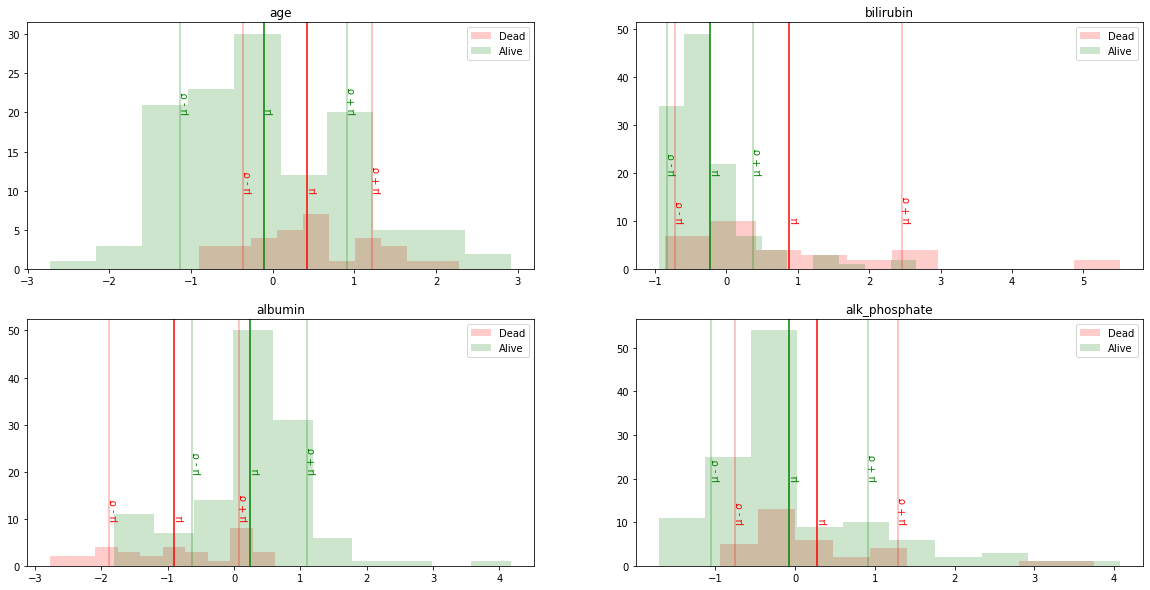

In [ ]:
# Figure size
plt.figure(figsize=(20,10))

# Create a new standardized dataframe just to see the results on the same scale for all features
X_hepatitis_std = (X_hepatitis - X_hepatitis.mean())/X_hepatitis.std()

# Dictionary that will store the features as keys 
# The values are tuples of the absolute values of the differences in means and 
# differences in std dev between the dead and alive distributions, respectively
diff_dict = {}

# Number of the current figure
i = 1

# Iterate over the different continuous features remaining in the input space
for feature in continuous_features_hepatitis:
    
    # Create a subplot for each continuous input feature
    axis = plt.subplot(2, 2, i)
    
    # Plot the distribution of the feature for the dead labels in red
    plt.hist(X_hepatitis_std[feature].loc[y_hepatitis == 0], bins = 10, label="Dead", alpha = 0.2, color='red')
    
    # Plot the mean as a red line and two red lines a standard deviation away from the mean
    mean_dead = X_hepatitis_std[feature].loc[y_hepatitis == 0].mean()
    std_dead = X_hepatitis_std[feature].loc[y_hepatitis == 0].std()
    plt.axvline(mean_dead, color='red', alpha = 1)
    plt.text(mean_dead, 10,'µ', color='red', rotation = 90)
    plt.axvline(mean_dead + std_dead, color='red', alpha = 0.3)
    plt.text(mean_dead + std_dead, 10,'µ + σ', color='red', rotation = 90)
    plt.axvline(mean_dead - std_dead, color='red', alpha = 0.3)
    plt.text(mean_dead - std_dead, 10,'µ - σ', color='red', rotation = 90)
    
    # Plot the distribution of the feature for the alive labels in green
    plt.hist(X_hepatitis_std[feature].loc[y_hepatitis == 1], bins = 10, label="Alive", alpha = 0.2, color='green')

    # Plot the mean as a green line and two green lines a standard deviation away from the mean
    mean_alive = X_hepatitis_std[feature].loc[y_hepatitis == 1].mean()
    std_alive = X_hepatitis_std[feature].loc[y_hepatitis == 1].std()
    plt.axvline(mean_alive, color='green', alpha = 1)
    plt.text(mean_alive, 20,'µ', color='green', rotation = 90)
    plt.axvline(mean_alive + std_alive, color='green', alpha = 0.3)
    plt.text(mean_alive + std_alive, 20,'µ + σ', color='green', rotation = 90)
    plt.axvline(mean_alive - std_alive, color='green', alpha = 0.3)
    plt.text(mean_alive - std_alive, 20,'µ - σ', color='green', rotation = 90)
    
    # Store the differences in mean and standard deviation in the difference dict
    diff_dict[feature] = (abs(mean_alive - mean_dead), abs(std_alive - std_dead))

    # Add the legend & title to the plot
    plt.legend()
    plt.title(feature)
    
    # Increment the figure number
    i += 1

We can now clearly see the distribution, its mean, and its standard deviation for each combination of continuous input feature and output label.

Below, we proceed to use the built dictionary of differences above to print how much the distributions differ in terms of mean and variance between the two output labels.

In [ ]:
# We can now use the dictionary above to print the difference in the mean and std dev of the distributions for each feature
for feature, diffs in diff_dict.items():
  print(f"For continuous feature {feature}, difference in mean = {diffs[0]} & difference in standard deviation = {diffs[1]}")

For continuous feature age, difference in mean = 0.5341692563248175 & difference in standard deviation = 0.23109991227086824
For continuous feature bilirubin, difference in mean = 1.1052025205603746 & difference in standard deviation = 0.9914716646872633
For continuous feature albumin, difference in mean = 1.1434121728901028 & difference in standard deviation = 0.1113520367371289
For continuous feature alk_phosphate, difference in mean = 0.3436074720847487 & difference in standard deviation = 0.03190886107786384


Since all the distributions have significantly different means (>0.3, standardized), we consider them as good indicators of the output and will thus keep all of them.

To contrast, we can do the above for the continuous feature `sgot` that we removed from the dataset because we deemed it to be too little correlated with the output. We should expect the distributions to be very similar for both labels. Again, we create a standardized version of the `sgot` feature to be able to compare with previous results on the same scale.

Difference in mean: 0.18014395182043413, Difference in standard deviation: 0.14153783953240695


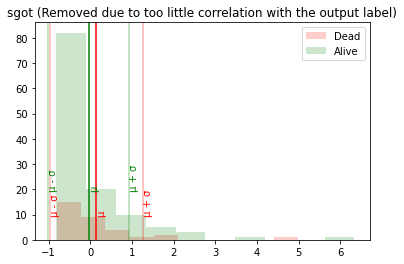

In [ ]:
# Standardize the sgot feature
sgot_std = (df_hepatitis['sgot'] - df_hepatitis['sgot'].mean()) / df_hepatitis['sgot'].std()

# Plot the distribution of the "sgot" feature for the dead labels in red
plt.hist(sgot_std.loc[y_hepatitis == 0], bins = 10, label="Dead", alpha = 0.2, color='red')

# Plot the mean as a red line and two red lines a standard deviation away from the mean
mean_dead = sgot_std.loc[y_hepatitis == 0].mean()
std_dead = sgot_std.loc[y_hepatitis == 0].std()
plt.axvline(mean_dead, color='red', alpha = 1)
plt.text(mean_dead, 10,'µ', color='red', rotation = 90)
plt.axvline(mean_dead + std_dead, color='red', alpha = 0.3)
plt.text(mean_dead + std_dead, 10,'µ + σ', color='red', rotation = 90)
plt.axvline(mean_dead - std_dead, color='red', alpha = 0.3)
plt.text(mean_dead - std_dead, 10,'µ - σ', color='red', rotation = 90)

# Plot the distribution of the "sgot" feature for the alive labels in green
plt.hist(sgot_std.loc[y_hepatitis == 1], bins = 10, label="Alive", alpha = 0.2, color='green')

# Plot the mean as a green line and two green lines a standard deviation away from the mean
mean_alive = sgot_std.loc[y_hepatitis == 1].mean()
std_alive = sgot_std.loc[y_hepatitis == 1].std()
plt.axvline(mean_alive, color='green', alpha = 1)
plt.text(mean_alive, 20,'µ', color='green', rotation = 90)
plt.axvline(mean_alive + std_alive, color='green', alpha = 0.3)
plt.text(mean_alive + std_alive, 20,'µ + σ', color='green', rotation = 90)
plt.axvline(mean_alive - std_alive, color='green', alpha = 0.3)
plt.text(mean_alive - std_alive, 20,'µ - σ', color='green', rotation = 90)

# Add the legend & title to the plot
plt.legend()
plt.title("sgot (Removed due to too little correlation with the output label)")

# Print the differences in mean and standard deviation
print(f"Difference in mean: {abs(mean_dead - mean_alive)}, Difference in standard deviation: {abs(std_dead - std_alive)}")

We can see above an explanation for removing this feature: The distributions of the data for dead and alive labels are too similar compared with the data we kept. Namely, the mean difference being less than 0.3 for the standardized data. We were thus correct to eliminate this feature from the dataset.

We will now move on to analysing the distributions of the categorical input data in similar fashion. First, we'll visualize the proportions of each possible value for every categorical input feature [[12]](https://online.stat.psu.edu/stat200/book/export/html/38).

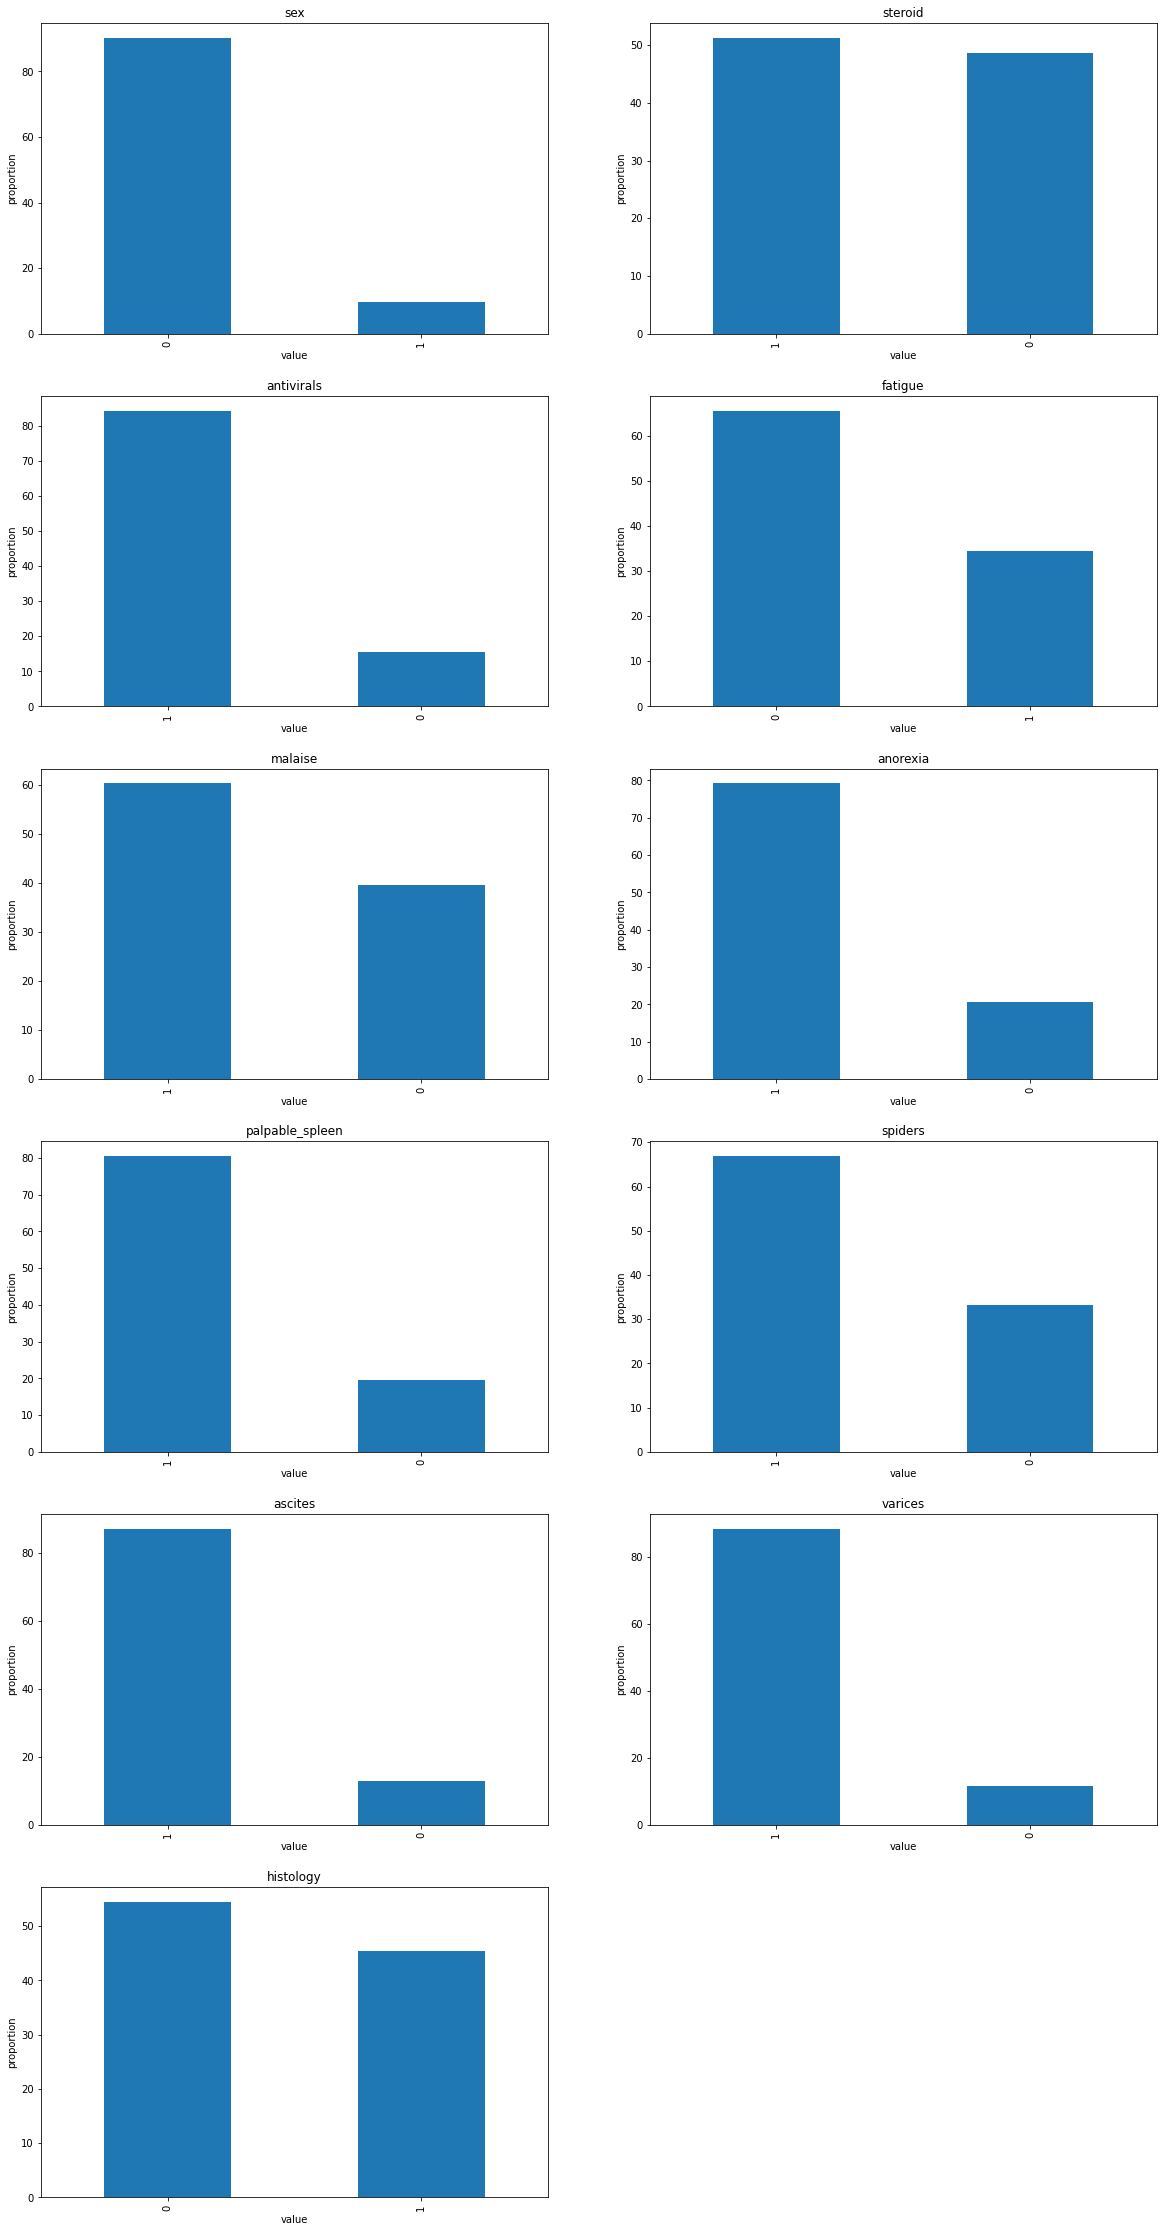

In [ ]:
# Figure size
plt.figure(figsize=(20,40))

# Number of the current figure
i = 1

# Iterate over the different categorical features remaining in the input space
for feature in categorical_features_hepatitis:
    
    # Create a subplot for each continuous input feature
    plt.subplot(6, 2, i)

    # Extract the prercentages of each of the two values of the categorical feature
    percentages = X_hepatitis[feature].value_counts(normalize=True) * 100 
    percentages.plot(kind='bar', xlabel='value', ylabel='proportion', title='Percentages of labels as a proportion of the dataset')

    # Add the legend & title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

The above shows us which features are balanced, and which are not. We can see that we have 7 imbalanced features, namely `sex`, `antivirals`, `malaise`, `anorexia`, `palpable_spleen`, `ascites` and `varices`. The remaining features `steroid` and `histology` are thus considered balanced.

We will now plot the above again, separating alive and dead labels to see which features have different distributions for different labels.

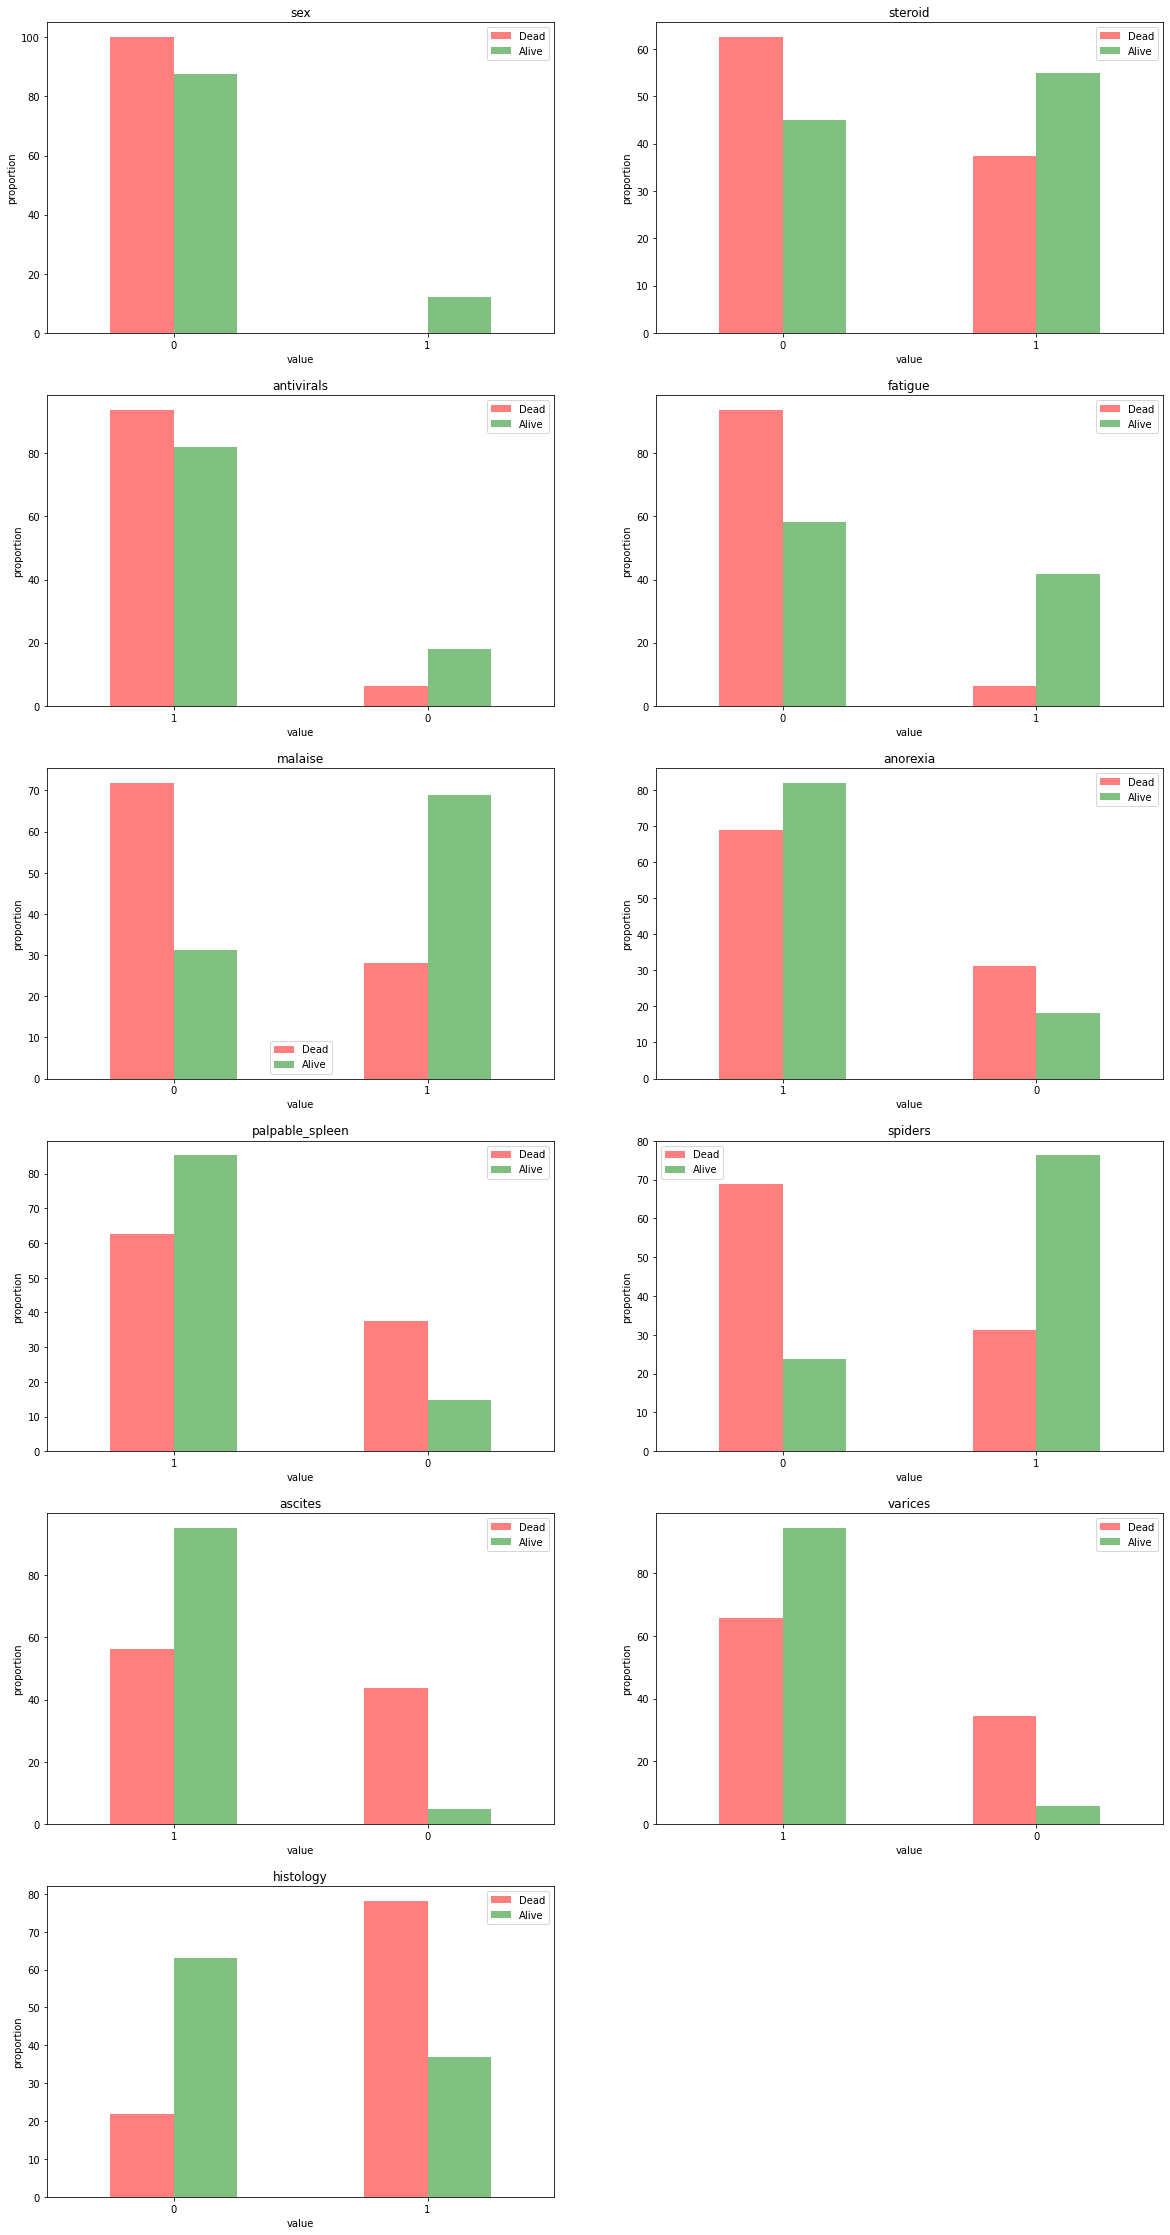

In [ ]:
# Figure size
plt.figure(figsize=(20,40))

# Number of the current figure
i = 1

# Iterate over the different categorical features remaining in the input space
for feature in categorical_features_hepatitis:
    
    # Create a subplot for each continuous input feature, extracting the axis for later use
    ax = plt.subplot(6, 2, i)

    # Extract the percentages of the different values for the dead labels
    percentages_dead = X_hepatitis[feature].loc[y_hepatitis == 0].value_counts(normalize=True) * 100 

    # Extract the percentages of the different values for the alive labels
    percentages_alive = X_hepatitis[feature].loc[y_hepatitis == 1].value_counts(normalize=True) * 100 

    # Merge both of the above into a dataframe with 2 columns
    percentages_dead_alive = pd.DataFrame({
        'Dead' : percentages_dead,
        'Alive' : percentages_alive
    })

    # Plot the above dataframe
    percentages_dead_alive.plot.bar(rot=0, ax = ax, color = {'Dead': 'red', 'Alive': 'green'}, alpha = 0.5, xlabel='value', ylabel = 'proportion')

    # Add the legend & title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

We can see that, for all features, the distribution differences between dead and alive labels are significant, meaning that they are all good indicators of the output label. For example, if we only know that the `histology` feature of a datapoint has value 0, we can confidently say it is much more likely to have label "Alive" than "Dead".

To contrast, we can do the above for the categorical feature `big_liver`  that we removed because we deemed it to be too little correlated with the output. We should again expect the distributions to be very similar for both labels.

For 'Dead' labels, the percentages of 1 and 0 values for sgot are 90.62% and 9.38% respectively.
For 'Alive' labels, the percentages of 1 and 0 values are for sgot are 82.79% and 17.21% respectively.


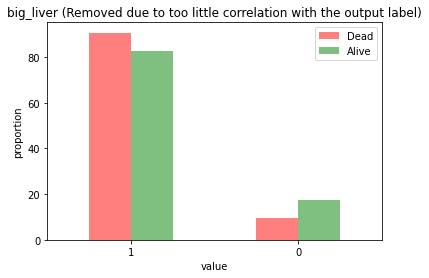

In [ ]:
# Extract the percentages of the different values for the dead labels
percentages_dead = df_hepatitis["big_liver"].loc[y_hepatitis == 0].value_counts(normalize=True) * 100 

# Extract the percentages of the different values for the alive labels
percentages_alive = df_hepatitis["big_liver"].loc[y_hepatitis == 1].value_counts(normalize=True) * 100 

# Merge both of the above into a dataframe with 2 columns
percentages_dead_alive = pd.DataFrame({
    'Dead' : percentages_dead,
    'Alive' : percentages_alive
})

# Plot the above dataframe
percentages_dead_alive.plot.bar(rot=0, color = {'Dead': 'red', 'Alive': 'green'}, alpha = 0.5, xlabel='value', ylabel = 'proportion')

# Add the legend & title to the plot
plt.title("big_liver (Removed due to too little correlation with the output label)")

# Print out the percentages of 2 / 1 values of sgot for dead and alive respectively
print(f"For 'Dead' labels, the percentages of 1 and 0 values for sgot are {round(percentages_dead_alive['Dead'][1], 2)}% and {round(percentages_dead_alive['Dead'][0], 2)}% respectively.")
print(f"For 'Alive' labels, the percentages of 1 and 0 values are for sgot are {round(percentages_dead_alive['Alive'][1], 2)}% and {round(percentages_dead_alive['Alive'][0],2)}% respectively.")

We can again see above an explanation for removing this feature: The distributions of the data for dead and alive labels are too similar, with the percentages of `1`'s and `0`'s for dead labels being around 91% and 9% respectively, while those same percentages for alive labels are around 83% and 17% respectively. We were thus correct to eliminate this feature from the dataset, because knowing the value of this feature for a datapoint does not allow us to confidently make any inferences about its label.

Before converting our pandas dataframe to a numpy array, we join X_hepatitis and y_hepatitis again one last time to drop duplicate rows since we dropped some features that could have been the differentiating factor between different inputs, thus creating duplicate datapoints in the process.

In [ ]:
# Join y_hepatitis into the input matrix
X_hepatitis["class"] = y_hepatitis

# Number of rows before dropping duplicates
before_drop = X_hepatitis.shape[0]

# Drop duplicates again
X_hepatitis.drop_duplicates(inplace=True)

# Number of rows after dropping duplicates
after_drop = X_hepatitis.shape[0]

# Separate features and labels again
y_hepatitis = X_hepatitis["class"]
X_hepatitis.drop("class", axis = 1, inplace=True)

# Print result
print(f"We dropped {before_drop - after_drop} new duplicates")

We dropped 0 new duplicates


We can now convert the data to numpy arrays after extracting whether each column is continuous or not for future use.

In [ ]:
# Array where input i indicates whether feature i of the hepatitis dataset is continuous (True) or categorical (False)
is_continuous_feature_hepatitis = [x in continuous_features_hepatitis for x in X_hepatitis.columns]

# Array to store all of the features kept after the data-processing
features_hepatitis = X_hepatitis.columns.values

# Convert the dataframes to numpy arrays
X_hepatitis = X_hepatitis.to_numpy()
y_hepatitis = y_hepatitis.to_numpy()

We can now move on to purifying the second dataset.

## 1.2 Data preprocessing for the diabetes dataset


Extracting the raw data from the diabetes dataset [[13]](https://archive.ics.uci.edu/ml/machine-learning-databases/00329/), and creating lists separating the continuous and categorical features.

In [ ]:
# Open the dataset URL
resp = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff')

# Load the arff data 
data, _ = loadarff(StringIO(resp.read().decode('utf-8')))

# Create a dataframe
df_diabetes = pd.DataFrame(data)

# Rename columns
df_diabetes.columns = ['quality', 'pre_screening', 'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_7',
              'exudates_8','exudates_9', 'exudates_10', 'exudates_11', 'exudates_12',
              'exudates_13', 'exudates_14', 'exudates_15', 'distance', 'diameter',
              'AM_FM', 'class']

# Continuous features of the second dataset
continuous_features_diabetes = ['MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_7', 'exudates_8', 'exudates_9', 
                                'exudates_10', 'exudates_11', 'exudates_12', 'exudates_13', 'exudates_14', 
                                'exudates_15', 'distance', 'diameter']

# Categorical features of the second dataset
categorical_features_diabetes = ['quality', 'pre_screening', 'AM_FM']

We can now move on to convert categorical inputs to integers, and continuous inputs to floats, similarly to the previous dataset.

In [ ]:
# Convert objects to numerical values
for c in df_diabetes.columns:
    if c in continuous_features_diabetes: df_diabetes[c] = df_diabetes[c].astype(float)
    else: df_diabetes[c] = df_diabetes[c].astype(int)

We will now drop the duplicates in this dataframe (if they exist) and visualize the first few lines of this second dataframe in order to get an intuition for the data provided.

In [ ]:
# Drop duplicates
df_diabetes.drop_duplicates(inplace=True)

# Take a peek at dataframe 2
df_diabetes.head()

quality  pre_screening  MA_2  MA_3  MA_4  MA_5  MA_6  MA_7  exudates_8  \
0        1              1  22.0  22.0  22.0  19.0  18.0  14.0   49.895756   
1        1              1  24.0  24.0  22.0  18.0  16.0  13.0   57.709936   
2        1              1  62.0  60.0  59.0  54.0  47.0  33.0   55.831441   
3        1              1  55.0  53.0  53.0  50.0  43.0  31.0   40.467228   
4        1              1  44.0  44.0  44.0  41.0  39.0  27.0   18.026254   

   exudates_9  exudates_10  exudates_11  exudates_12  exudates_13  \
0   17.775994     5.270920     0.771761     0.018632     0.006864   
1   23.799994     3.325423     0.234185     0.003903     0.003903   
2   27.993933    12.687485     4.852282     1.393889     0.373252   
3   18.445954     9.118901     3.079428     0.840261     0.272434   
4    8.570709     0.410381     0.000000     0.000000     0.000000   

   exudates_14  exudates_15  distance  diameter  AM_FM  class  
0     0.003923     0.003923  0.486903  0.100025      1      0  
1     0.003903     0.003903  0.520908  0.144414      0      0  
2     0.041817     0.007744  0.530904  0.128548      0      1  
3     0.007653     0.001531  0.483284  0.114790      0      0  
4     0.000000     0.000000  0.475935  0.123572      0      1

We now check for the presence of missing data by making sure the dataframe doesnt contain any `?` symbols.

In [ ]:
for feature in df_diabetes.columns:
  if '?' in df_diabetes[feature]:
    print(f"The column featuring {feature} has {(df_diabetes[feature]=='?').sum()} '?' symbol")
  else:
    print(f"The column featuring {feature} has no '?' symbol")

The column featuring quality has no '?' symbol
The column featuring pre_screening has no '?' symbol
The column featuring MA_2 has no '?' symbol
The column featuring MA_3 has no '?' symbol
The column featuring MA_4 has no '?' symbol
The column featuring MA_5 has no '?' symbol
The column featuring MA_6 has no '?' symbol
The column featuring MA_7 has no '?' symbol
The column featuring exudates_8 has no '?' symbol
The column featuring exudates_9 has no '?' symbol
The column featuring exudates_10 has no '?' symbol
The column featuring exudates_11 has no '?' symbol
The column featuring exudates_12 has no '?' symbol
The column featuring exudates_13 has no '?' symbol
The column featuring exudates_14 has no '?' symbol
The column featuring exudates_15 has no '?' symbol
The column featuring distance has no '?' symbol
The column featuring diameter has no '?' symbol
The column featuring AM_FM has no '?' symbol
The column featuring class has no '?' symbol


We conclude that the dataframe does not contain any missing data, so we don't have to drop or replace any missing values.

The next step is to separate the inputs from the labels to get the standard format of data with features X and labels y.


In [ ]:
# Separate features and labels
y_diabetes = df_diabetes["class"]
X_diabetes = df_diabetes.drop("class", axis = 1)

# Take a peek to make sure everything went correctly
X_diabetes.head()

quality  pre_screening  MA_2  MA_3  MA_4  MA_5  MA_6  MA_7  exudates_8  \
0        1              1  22.0  22.0  22.0  19.0  18.0  14.0   49.895756   
1        1              1  24.0  24.0  22.0  18.0  16.0  13.0   57.709936   
2        1              1  62.0  60.0  59.0  54.0  47.0  33.0   55.831441   
3        1              1  55.0  53.0  53.0  50.0  43.0  31.0   40.467228   
4        1              1  44.0  44.0  44.0  41.0  39.0  27.0   18.026254   

   exudates_9  exudates_10  exudates_11  exudates_12  exudates_13  \
0   17.775994     5.270920     0.771761     0.018632     0.006864   
1   23.799994     3.325423     0.234185     0.003903     0.003903   
2   27.993933    12.687485     4.852282     1.393889     0.373252   
3   18.445954     9.118901     3.079428     0.840261     0.272434   
4    8.570709     0.410381     0.000000     0.000000     0.000000   

   exudates_14  exudates_15  distance  diameter  AM_FM  
0     0.003923     0.003923  0.486903  0.100025      1  
1     0.003903     0.003903  0.520908  0.144414      0  
2     0.041817     0.007744  0.530904  0.128548      0  
3     0.007653     0.001531  0.483284  0.114790      0  
4     0.000000     0.000000  0.475935  0.123572      0

The continuous features are now standardized and the data is split between features and labels.

We now move to filtering the highly correlated features because if 2 features are highly correlated, it means that they give us the same information, and one of them is redundant. We thus must remove one of them in order to avoid overfitting. The below code snippet uses the functions defined when pre-processing the hepatitis dataset since they were made to be reusable.

We first use the previously defined `corr_heatmap()` function to visualize the correlation between the features.

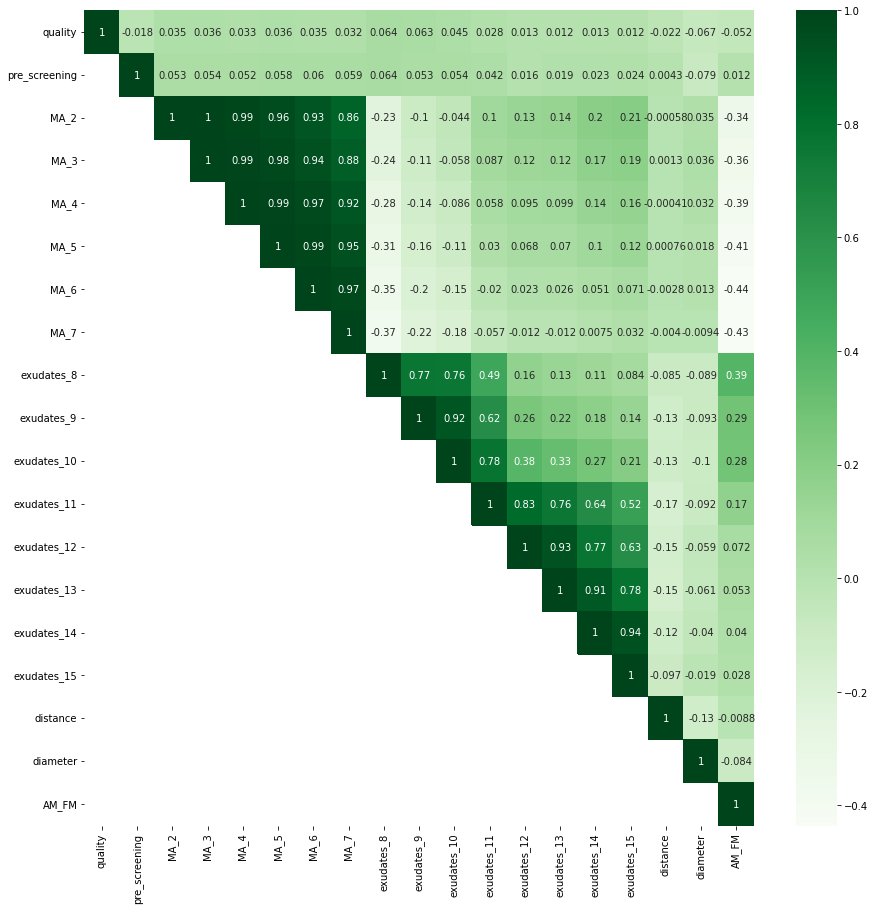

In [ ]:
corr_heatmap(X_diabetes.corr())

We notice that a lot of features are highly correlated with each other. We now move to removing these highly correlated features, using the threshold specified at the top of the code cell. Note that this threshold is much higher than what was used for the hepatitis dataset since the diabetes dataset is in general much worse than the hepatitis dataset. Thus we chose to remove only the worst features in order to be left with some other less bad features to work with.

In [ ]:
# Variable parameter
strong_correlation_threshold_diabetes = 0.9

# Keep track of how many features were deleted
num_dropped = 0

# Keep deleting features till no pair has a correlation higher than the threshold
while True:
  
  X_diabetes_corr = X_diabetes.corr() # Compute the pearson correlation matrix of the filtered dataset
  
  # If we find no correlated pairs, break the loop
  if not (find_high_corr_pair(X_diabetes, X_diabetes_corr, "diabetes", strong_correlation_threshold_diabetes)):
    break

  # Otherwise, add 1 to the number of features dropped, and recompute the correlation matrix (Next iteration)
  num_dropped += 1

# Print out the resulting shape of the dataframe
print(f"All in all, we dropped {num_dropped} feature(s) and are left with {X_diabetes.shape[1]} features.")

MA_3 and MA_2 are highly correlated with correlation 0.9961732185251224.
Dropping MA_2 from the dataframe.
MA_4 and MA_3 are highly correlated with correlation 0.9942173988970219.
Dropping MA_3 from the dataframe.
MA_5 and MA_4 are highly correlated with correlation 0.9918291955260465.
Dropping MA_4 from the dataframe.
MA_6 and MA_5 are highly correlated with correlation 0.9882967317980994.
Dropping MA_5 from the dataframe.
MA_7 and MA_6 are highly correlated with correlation 0.9746265542154641.
Dropping MA_6 from the dataframe.
exudates_10 and exudates_9 are highly correlated with correlation 0.9194746675456705.
Dropping exudates_9 from the dataframe.
exudates_13 and exudates_12 are highly correlated with correlation 0.9316626958305604.
Dropping exudates_12 from the dataframe.
exudates_14 and exudates_13 are highly correlated with correlation 0.9063667782778411.
Dropping exudates_13 from the dataframe.
exudates_15 and exudates_14 are highly correlated with correlation 0.94346529638413

Above, we can see which features were dropped, depending on what threshold we chose.

The next step is now to drop features that have low correlation with the output label, because such features are not good indicators of whether a patient died or is still alive. Again, the threshold used is lower than that of the hepatitis dataset to be left with some features for later use, since the dataset is of lower quality.

In [ ]:
# Variable parameter
weak_correlation_threhold_diabetes = 0.03

# Function that removes a feature from X and removes it from the feature lists at the start 
# of the pre-processing section
def remove_weak_correlation_feature(feature):
    X_diabetes.drop(feature, axis = 1, inplace = True) # drop from X_hepatitis
    remove_feature(feature, "diabetes") # Remove it from the lists of features at the start of the pre-processing section


# Extract the correlation of every feature with the output class
# df_diabetes.corr() returns the correlation of each possible pair of columns
# Selecting the class column from the above leaves us with the correlation of each column with class
# iloc[1:] then filters out the correlation of class with itself
diabetes_class_corr = df_diabetes.corr()['class'].iloc[:-1]

# Compute the features with very low correlation to the output label
weak_features_dict = diabetes_class_corr[abs(diabetes_class_corr) < weak_correlation_threhold_diabetes].to_dict()

# Drop those features from the X dataframe if they weren't removed in the previous code snippet
num_dropped = 0

for feature, corr in weak_features_dict.items():
  if feature in X_diabetes.columns:
    print(f"Feature {feature} has very low correlation {corr} with the label and will be dropped.")
    remove_weak_correlation_feature(feature) # Function defined above
    num_dropped += 1
  else:
    print(f"Feature {feature} has very low correlation {corr} with the label but was already dropped in the previous step because of high correlation with another feature.")

# Print out the resulting shape of the dataframe
print(f"All in all, we dropped {num_dropped} feature(s) and are left with {X_diabetes.shape[1]} features.")

Feature exudates_9 has very low correlation 0.002549774161653086 with the label but was already dropped in the previous step because of high correlation with another feature.
Feature distance has very low correlation 0.007048446806242419 with the label and will be dropped.
Feature diameter has very low correlation -0.0288064713336764 with the label and will be dropped.
All in all, we dropped 2 feature(s) and are left with 8 features.


Above, we can see which features were dropped using the threshold of 0.05 we chose. Notice how the threshold for the second dataframe is way lower than the one used for the first: 0.05 < 0.1. Indeed, a lot of features in the second dataframe are poorly correlated to the output which explains why we used a smaller threshold to avoid deleting too many features.

We will start by looking at a bar chart showing the proportions of each output label.

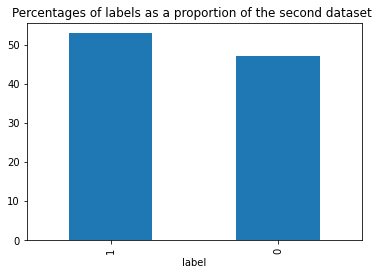

In [ ]:
# Extracting the percentage of each class in the dataset
# Normalize=True converts the counts to proportions and * 100 converts to percentages
class_percentages_diabetes = y_diabetes.value_counts(normalize=True) * 100 
class_percentages_diabetes.plot(kind='bar', xlabel='label', title='Percentages of labels as a proportion of the second dataset ')

As can be seen above, we have a very balanced data with ~ 55% diabetic retinopathy labels compared to ~ 45 % non diabetic retinopathy labels. So this data is better adapted for ROC curve analysis than the previous dataset.

We can now visualize the distributions of the different input features.

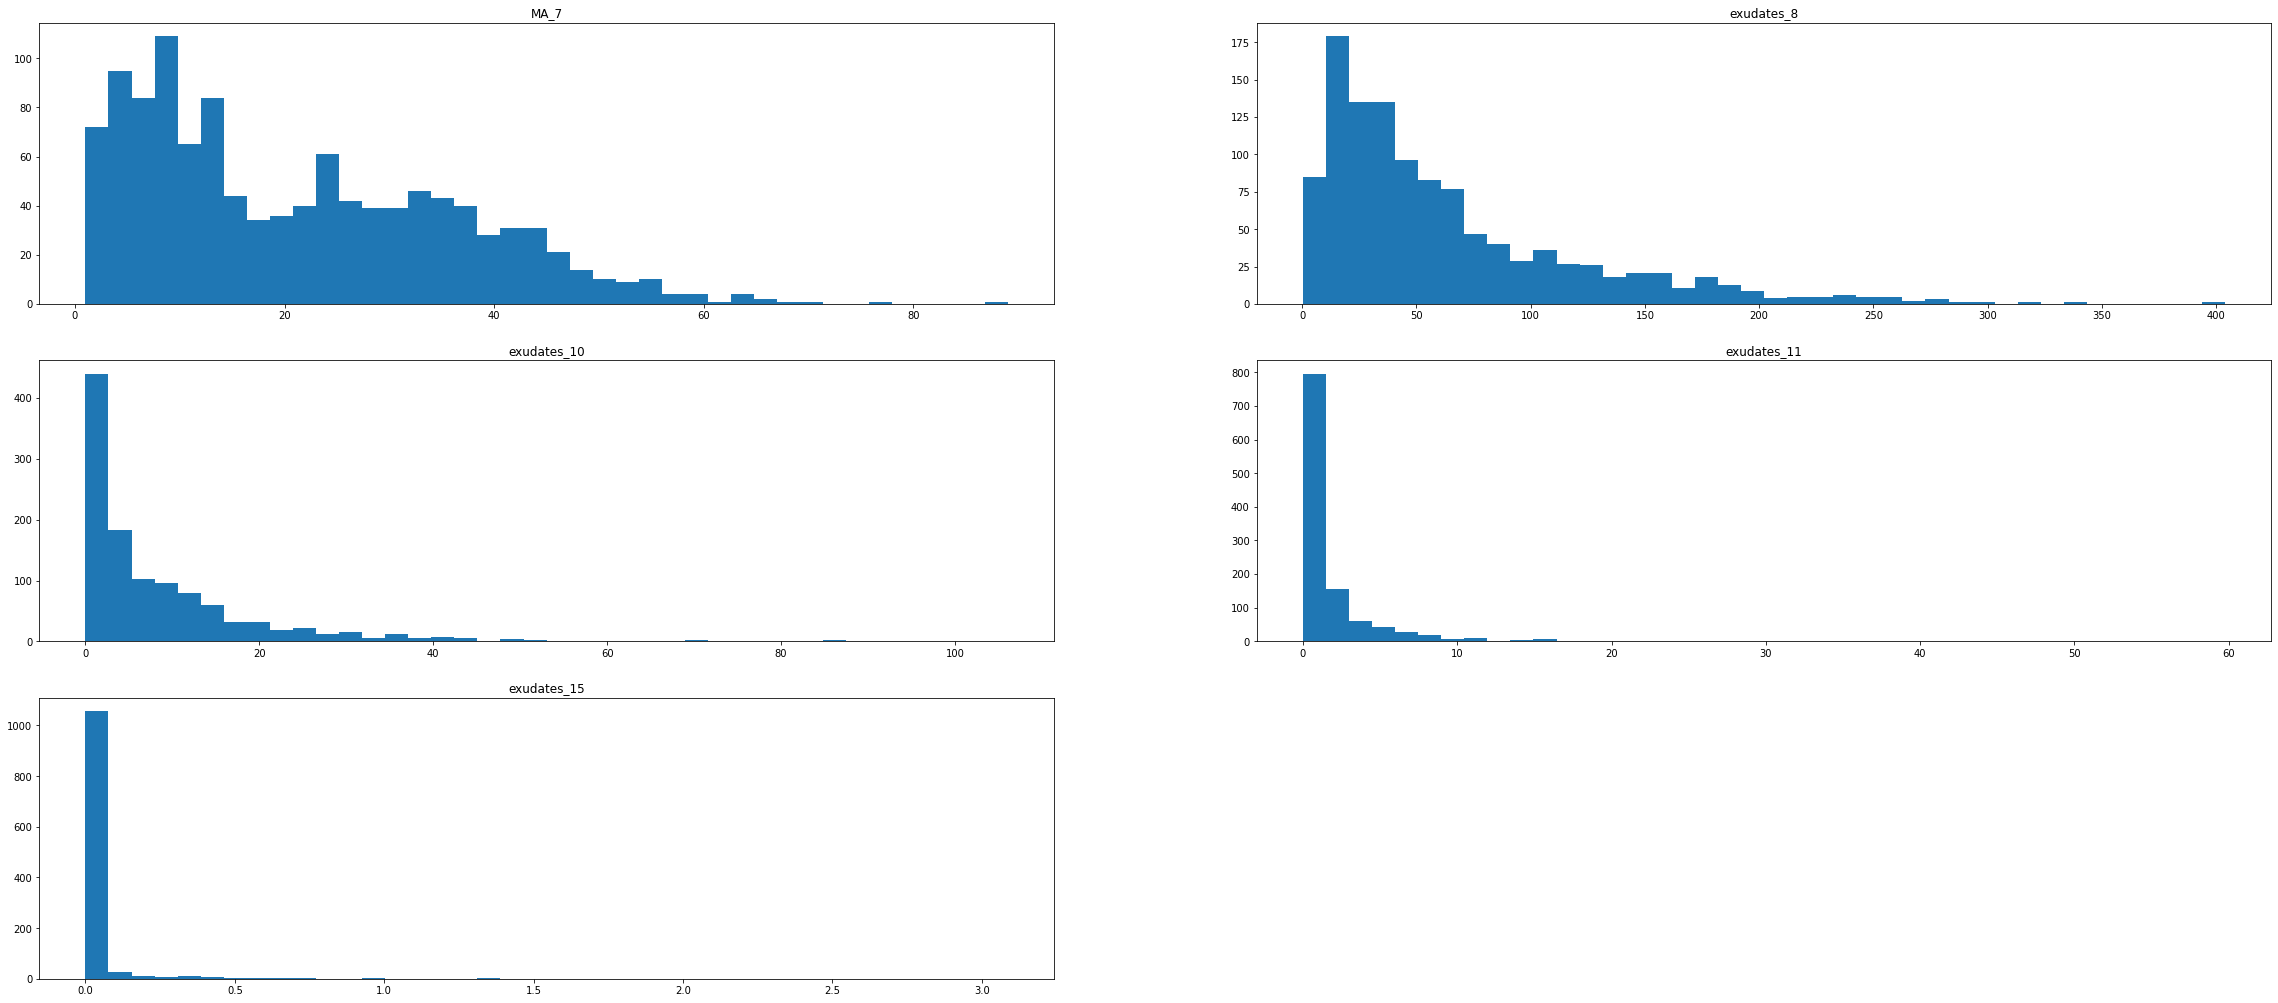

In [ ]:
# Figure size
plt.figure(figsize=(40,30))

# Number of the current figure
i = 1
# Iterate over the different continuous features remaining in the input space
for feature in continuous_features_diabetes:
    
    # Create a subplot for each continuous input feature
    plt.subplot(5, 2, i)   

    # Plot the distribution of the feature as a histogram with 10 bins
    plt.hist(X_diabetes[feature], bins = 40)

    # Add the title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

As for the first dataset, the figures above don't really tell us how each feature affects the output label, since we visualized both the output classes in the same distribution. However, we can already tell that the distributions are not Gaussian in this case, and look more exponential [[14]](https://en.wikipedia.org/wiki/Exponential_distribution).

We will thus proceed to build the distributions again, separating non diabetic retinopathy and diabetic retinopathy datapoints, before comparing the differences in the distributions between the two labels Note that, this time, we create `X_diabetes_std`, which is a standardized version of `X_diabetes`, to be able to compare the differences in mean and standard deviation between dead and alive labels for all features on the same scale. However, note that, like for the hepatitis dataset, `X_diabetes_std` will be discarded after the visualization since standardizing before splitting into training and testing sets leads to data leakage.

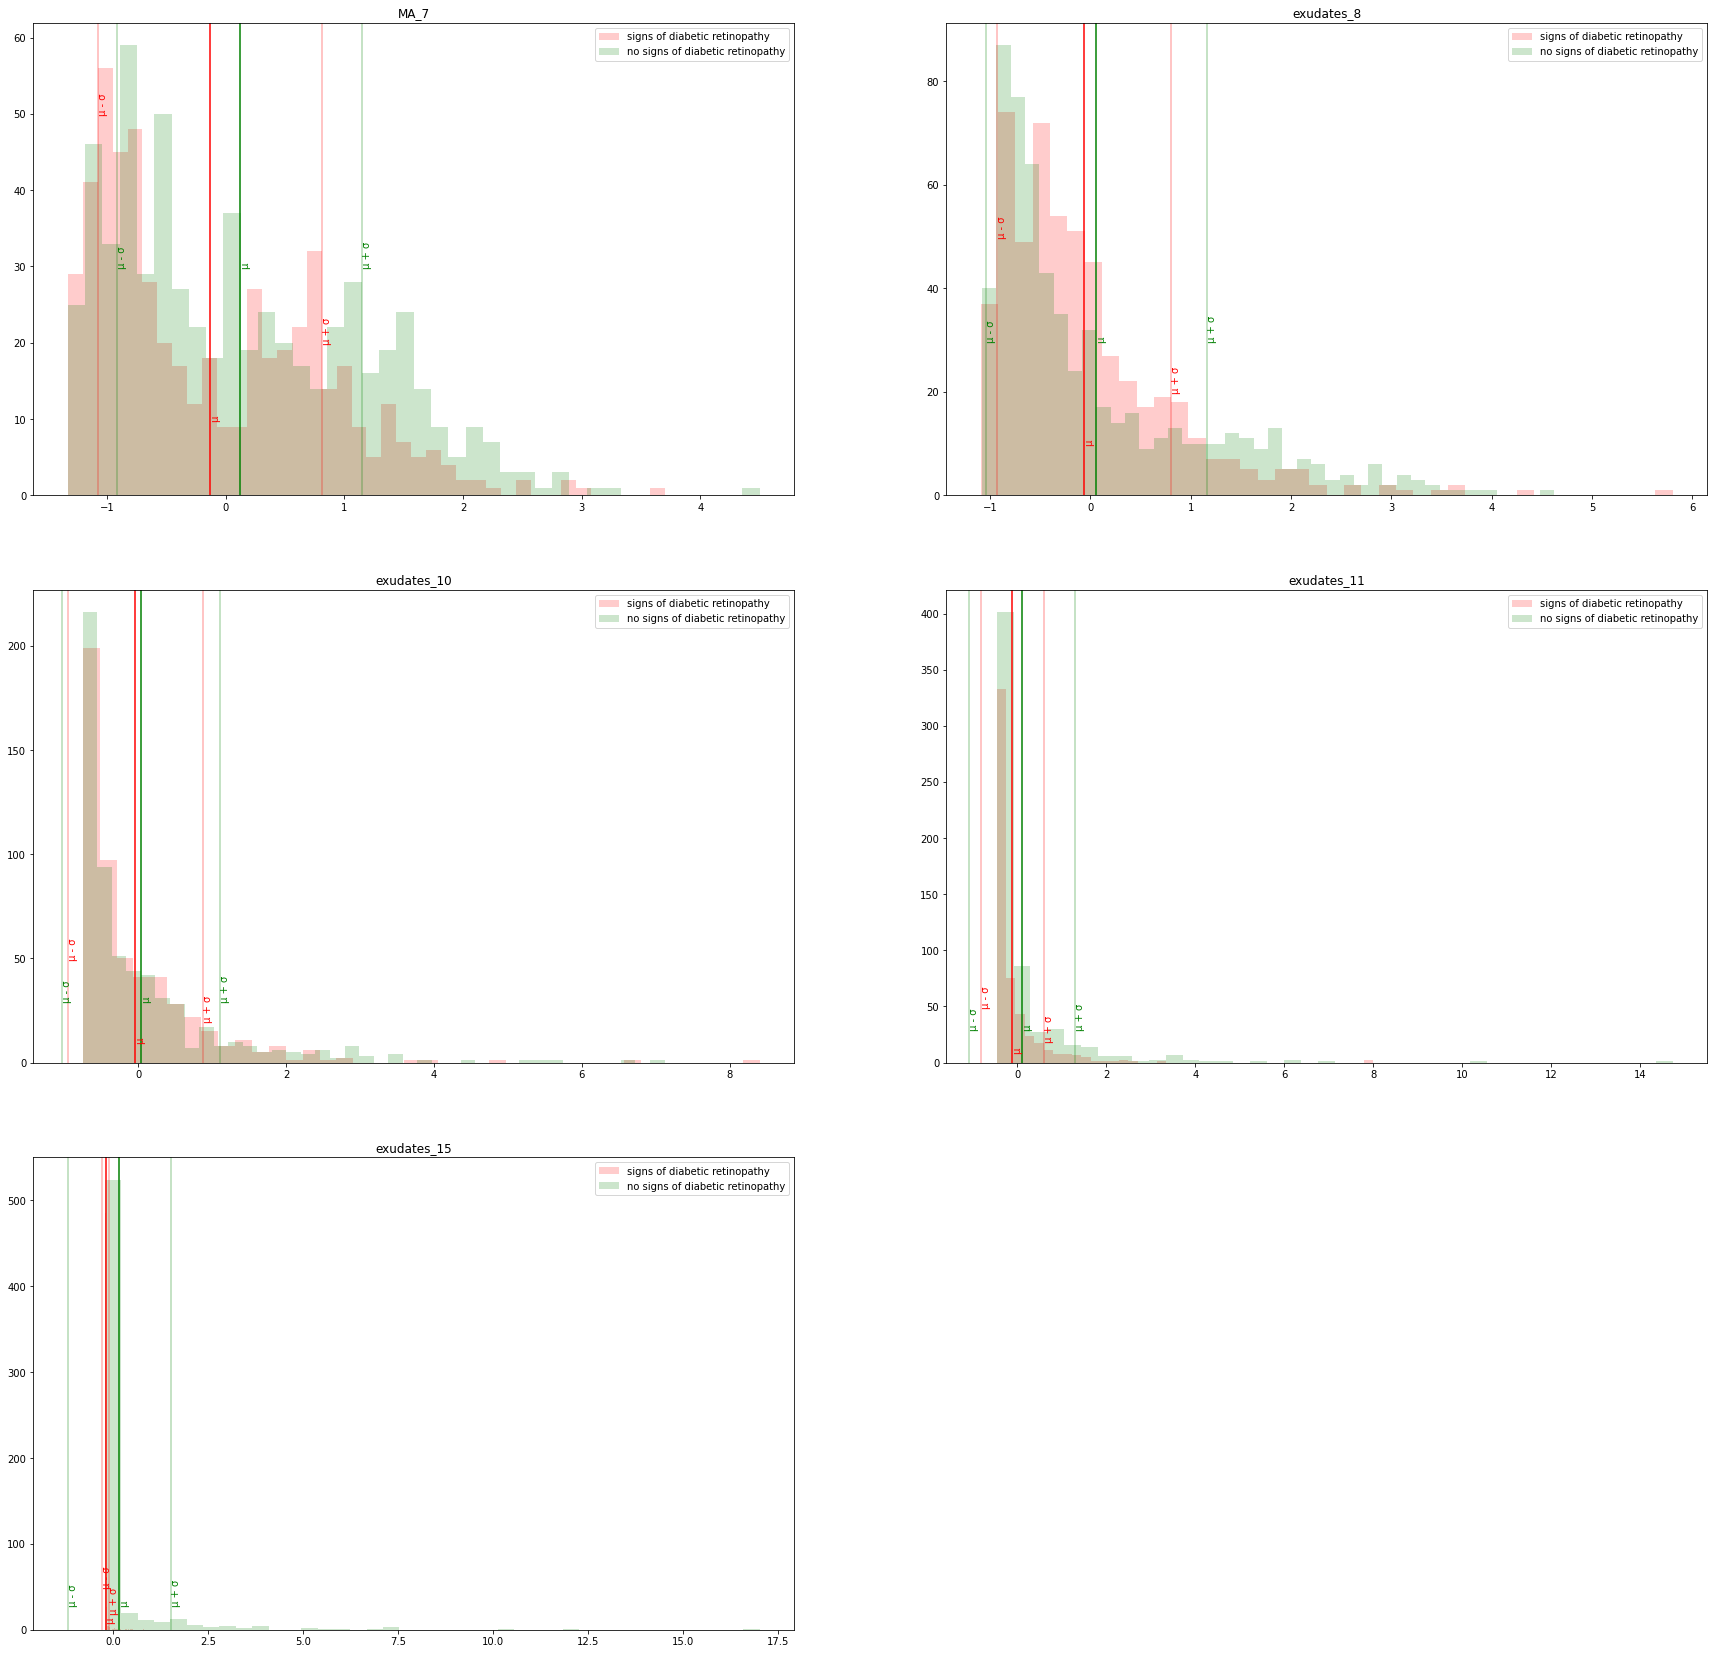

In [ ]:
# Figure size
plt.figure(figsize=(30,40))

# Create a new standardized dataframe just to see the results on the same scale for all features
X_diabetes_std = (X_diabetes - X_diabetes.mean())/X_diabetes.std()

# Dictionary that will store the features as keys 
# The values are tuples of the absolute values of the differences in means and 
# differences in std dev between the dead and alive distributions, respectively
diff_dict = {}

# Number of the current figure
i = 1

# Iterate over the different continuous features remaining in the input space
for feature in continuous_features_diabetes:
    
    # Create a subplot for each continuous input feature
    plt.subplot(4, 2, i)
    
    # Plot the distribution of the feature for the diabetic retinopathy labels in red
    plt.hist(X_diabetes_std[feature].loc[y_diabetes == 0], bins = 40, label="signs of diabetic retinopathy", alpha = 0.2, color='red')
    
    # Plot the mean as a red line and two red lines a standard deviation away from the mean
    mean_sign = X_diabetes_std[feature].loc[y_diabetes == 0].mean()
    std_sign = X_diabetes_std[feature].loc[y_diabetes == 0].std()
    plt.axvline(mean_sign, color='red', alpha = 1)
    plt.text(mean_sign, 10,'µ', color='red', rotation = 90)
    plt.axvline(mean_sign + std_sign, color='red', alpha = 0.3)
    plt.text(mean_sign + std_sign, 20,'µ + σ', color='red', rotation = 90)
    plt.axvline(mean_sign - std_sign, color='red', alpha = 0.3)
    plt.text(mean_sign - std_sign, 50,'µ - σ', color='red', rotation = 90)
    
    # Plot the distribution of the feature for the non diabetic retinopathy labels in green
    plt.hist(X_diabetes_std[feature].loc[y_diabetes == 1], bins = 40, label="no signs of diabetic retinopathy", alpha = 0.2, color='green')

    # Plot the mean as a green line and two green lines a standard deviation away from the mean
    mean_no_sign = X_diabetes_std[feature].loc[y_diabetes == 1].mean()
    std_no_sign = X_diabetes_std[feature].loc[y_diabetes == 1].std()
    plt.axvline(mean_no_sign, color='green', alpha = 1)
    plt.text(mean_no_sign, 30,'µ', color='green', rotation = 90)
    plt.axvline(mean_no_sign + std_no_sign, color='green', alpha = 0.3)
    plt.text(mean_no_sign + std_no_sign, 30,'µ + σ', color='green', rotation = 90)
    plt.axvline(mean_no_sign - std_no_sign, color='green', alpha = 0.3)
    plt.text(mean_no_sign- std_no_sign, 30,'µ - σ', color='green', rotation = 90)
    
    # Store the differences in mean and standard deviation in the difference dict
    diff_dict[feature] = (abs(mean_no_sign - mean_sign), abs(std_no_sign - std_sign))

    # Add the legend & title to the plot
    plt.legend()
    plt.title(feature)
    
    # Increment the figure number
    i += 1

We can now clearly see the distribution, mean and standard deviation for each combination of continuous input feature and output label.

Below we proceed to use the built dictionnary of differences above to print how much the distributions differ in terms of mean and variance between the two output label.

In [ ]:
# We can now use the dictionary above to print the difference in the mean and std dev of the distributions for each feature
for feature, diffs in diff_dict.items():
  print(f"For continuous feature {feature}, difference in mean = {diffs[0]} & difference in standard deviation = {diffs[1]}")# We can now use the dictionary above to print the difference in the mean and std dev of the distributions for each feature

For continuous feature MA_7, difference in mean = 0.24948353924029934 & difference in standard deviation = 0.08865962051765941
For continuous feature exudates_8, difference in mean = 0.12184880767835059 & difference in standard deviation = 0.23540080932487528
For continuous feature exudates_10, difference in mean = 0.08050279536522452 & difference in standard deviation = 0.15936315086935027
For continuous feature exudates_11, difference in mean = 0.21143626970351886 & difference in standard deviation = 0.48138697191257085
For continuous feature exudates_15, difference in mean = 0.3567687299973371 & difference in standard deviation = 1.263317569525564


We can here see that the quality of the diabetes dataset is much worse than the quality of the hepatitis dataset. Even after removing more than half of the features due to high inter-correlation or low correlation with the output label, we still have features with mean difference between output labels lower than 0.2 (Namely exudates_8). However, we keep that feature because we already eliminated too many features, and will require data, however bad, to make predictions.

To contrast with the distributions above, we can repeat the process for the continuous feature `exudates_9` that we removed because we deemed it to be too little correlated with the output. We should expect the distributions to be very similar for both labels. Again, we standardize the data for the column before plotting the distribution.

Mean difference: 0.18014395182043413

Standard deviation difference: 0.14153783953240695



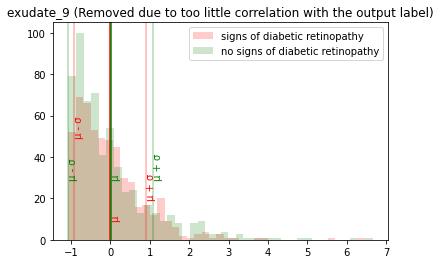

In [ ]:
# Standardize the data for the column
exudates_9_std = (df_diabetes["exudates_9"] - df_diabetes["exudates_9"].mean())/df_diabetes["exudates_9"].std()

# Plot the distribution of the "exudates_9" feature for the signs of diabetic retinopathy labels in red
plt.hist(exudates_9_std.loc[y_diabetes == 0], bins = 40, label="signs of diabetic retinopathy", alpha = 0.2, color='red')

# Plot the mean as a red line and two red lines a standard deviation away from the mean
mean_sign = exudates_9_std.loc[y_diabetes == 0].mean()
std_sign = exudates_9_std.loc[y_diabetes == 0].std()
plt.axvline(mean_sign, color='red', alpha = 1)
plt.text(mean_sign, 10,'µ', color='red', rotation = 90)
plt.axvline(mean_sign + std_sign, color='red', alpha = 0.3)
plt.text(mean_sign + std_sign, 20,'µ + σ', color='red', rotation = 90)
plt.axvline(mean_sign - std_sign, color='red', alpha = 0.3)
plt.text(mean_sign - std_sign, 50,'µ - σ', color='red', rotation = 90)

# Plot the distribution of the "exudates_9" feature for the no sign of diabetic retinopathy labels in green
plt.hist(exudates_9_std.loc[y_diabetes == 1], bins = 40, label="no signs of diabetic retinopathy", alpha = 0.2, color='green')

# Plot the mean as a green line and two green lines a standard deviation away from the mean
mean_no_sign = exudates_9_std.loc[y_diabetes == 1].mean()
std_no_sign = exudates_9_std.loc[y_diabetes == 1].std()
plt.axvline(mean_no_sign, color='green', alpha = 1)
plt.text(mean_no_sign, 30,'µ', color='green', rotation = 90)
plt.axvline(mean_no_sign + std_no_sign, color='green', alpha = 0.3)
plt.text(mean_no_sign + std_no_sign, 30,'µ + σ', color='green', rotation = 90)
plt.axvline(mean_no_sign - std_no_sign, color='green', alpha = 0.3)
plt.text(mean_no_sign- std_no_sign, 30,'µ - σ', color='green', rotation = 90)

# Add the legend & title to the plot
plt.legend()
plt.title("exudate_9 (Removed due to too little correlation with the output label)")

# Print the differences in mean and standard deviation
print(f"Mean difference: {abs(mean_alive-mean_dead)}\n")
print(f"Standard deviation difference: {abs(std_alive-std_dead)}\n")

As expected, the mean difference between the two distributions is extremely low (< 0.001, standardized). This feature is therefore a bad indicator for the output and we were thus correct to eliminate it from the dataset, since the distributions are identical for both output labels.

We will now move on to analysing the distributions of the categorical input data in similar fashion. First, we'll visualize the proportions of each possible value for every categorical input feature.

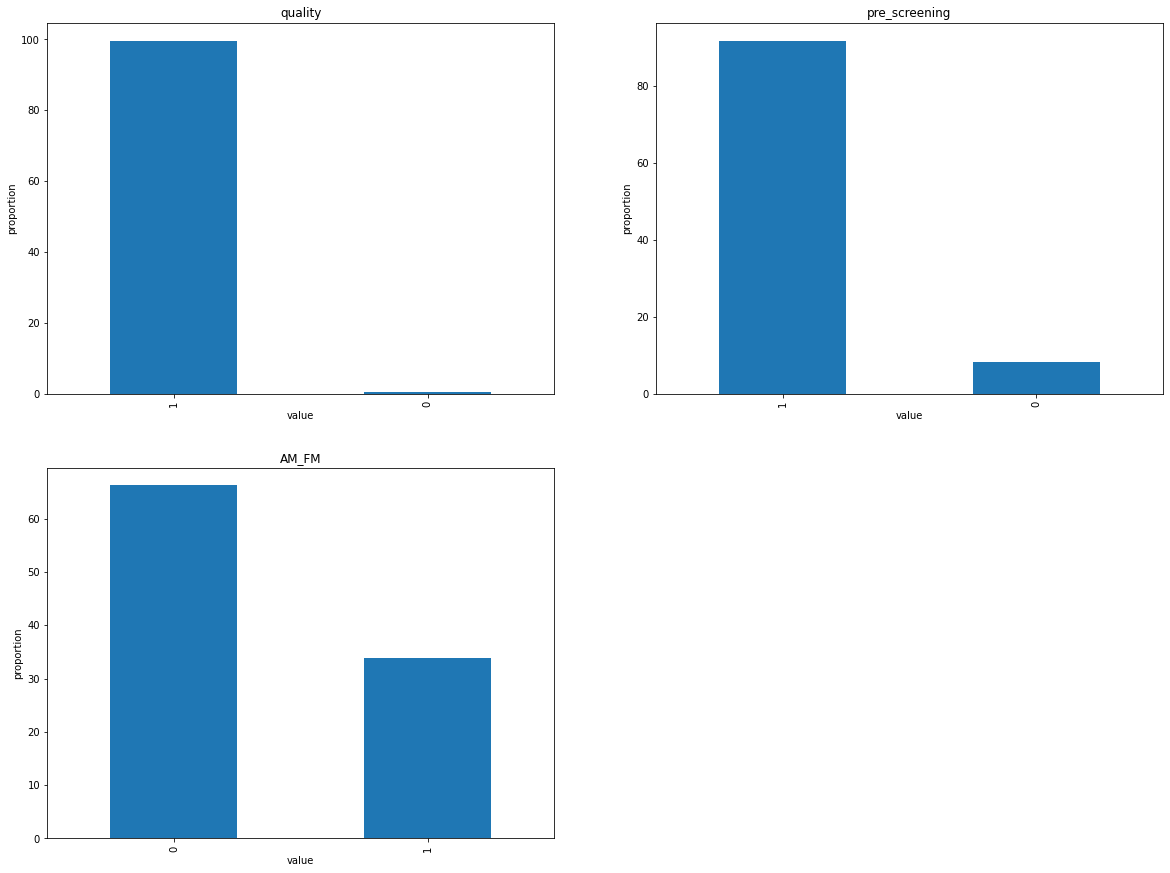

In [ ]:
# Figure size
plt.figure(figsize=(20,15))

# Number of the current figure
i = 1

# Iterate over the different categorical features remaining in the input space
for feature in categorical_features_diabetes:
    
    # Create a subplot for each continuous input feature
    plt.subplot(2, 2, i)

    # Extract the prercentages of each of the two values of the categorical feature
    percentages = X_diabetes[feature].value_counts(normalize=True) * 100 
    percentages.plot(kind='bar', xlabel='value', ylabel='proportion', title='Percentages of labels as a proportion of the dataset')

    # Add the legend & title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

The above shows us that both categorical features are unbalanced, namely `quality` and `pre_screening`. Especially, the `quality` feature seems to have mostly labels with `1` as a value, which makes it a very bad predictor of the output label [[15]](https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5). We will keep it to see its distribution in the next cell and show interesting results before dropping it.

We will now plot the above again separating the labels, in order to see which features have different distributions for different labels.

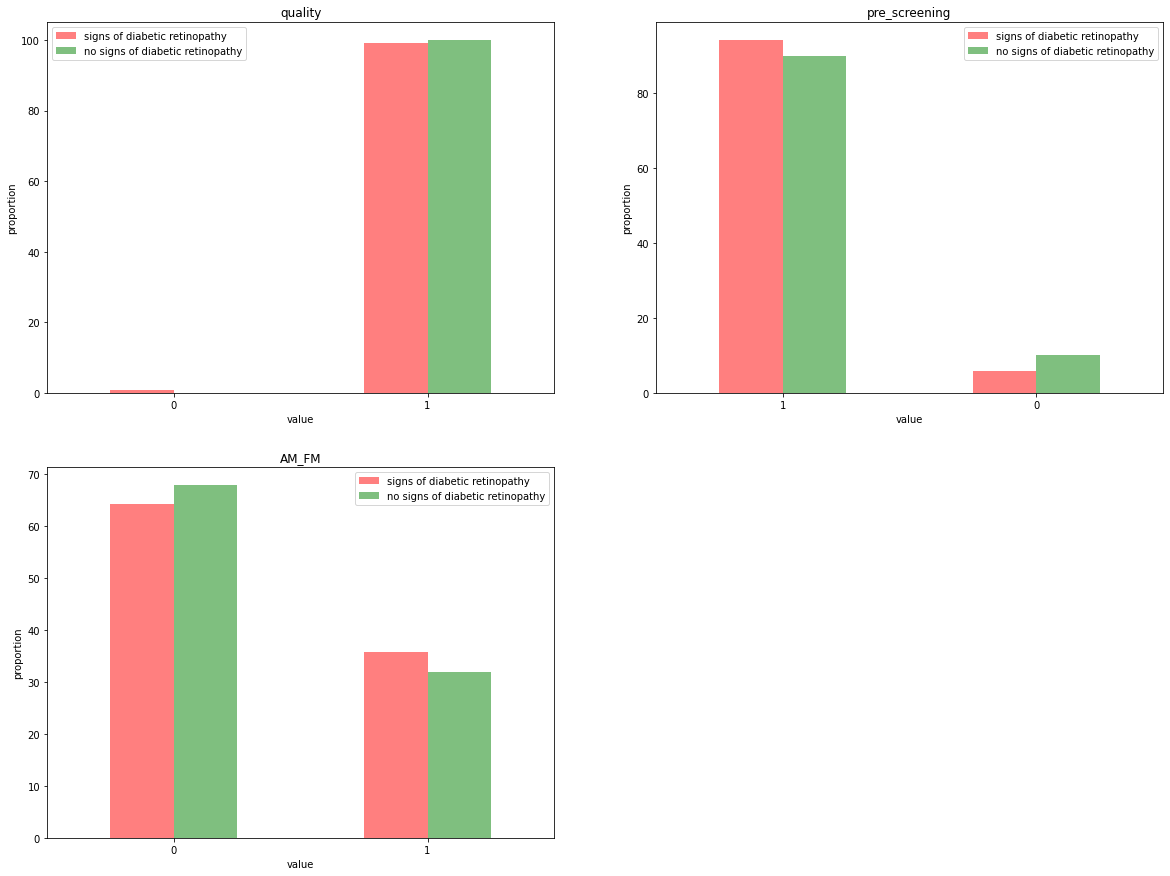

In [ ]:
# Figure size
plt.figure(figsize=(20,15))

# Number of the current figure
i = 1

# Iterate over the different categorical features remaining in the input space
for feature in categorical_features_diabetes:
    
    # Create a subplot for each continuous input feature, extracting the axis for later use
    ax = plt.subplot(2, 2, i)

    # Extract the percentages of the different values for the label "signs of diabetic retinopathy"
    percentages_signs = X_diabetes[feature].loc[y_diabetes == 0].value_counts(normalize=True) * 100 

    # Extract the percentages of the different values for the label "no signs of diabetic retinopathy"
    percentages_no_signs = X_diabetes[feature].loc[y_diabetes == 1].value_counts(normalize=True) * 100 

    # Merge both of the above into a dataframe with 2 columns
    percentages = pd.DataFrame({
        'signs of diabetic retinopathy' : percentages_signs,
        'no signs of diabetic retinopathy' : percentages_no_signs
    })

    # Plot the above dataframe
    percentages.plot.bar(rot=0, ax = ax, color = {'signs of diabetic retinopathy': 'red', 'no signs of diabetic retinopathy': 'green'}, alpha = 0.5, xlabel='value', ylabel = 'proportion')

    # Add the legend & title to the plot
    plt.title(feature)
    
    # Increment the figure number
    i += 1

We can see that, for both features, the distribution differences between the two labels are very small, meaning that they are worse indicators of the output label compared to the hepatitis dataset's categorical features. Again, this is due to the dataset quality being poor.

We can now clearly see how the "quality" feature is a particular poor. Knowing its value is `1` doesn't tell us anything about the output label, while knowing it is `0` is inconclusive because we have very few datapoints of each class for that value. We will thus proceed to drop it below.

In [ ]:
X_diabetes.drop("quality", axis = 1, inplace = True) # drop the "quality" featurefrom X_hepatitis
remove_feature("quality", "diabetes") # Remove it from the lists of features at the start of the pre-processing section


To contrast, we can do the above for the categorical feature "AM_FM" that we removed because we deemed it to be too little correlated with the output. We should again expect the distributions to be very similar for both labels, justifying our choice of dropping it.

For the signs of diabetic retinopathy label, the percentages of 1 and 0 values for AM_FM are 35.74% and 64.26% respectively.
For the no signs of diabetic retinopathy label, the percentages of 1 and 0 values for AM_FM are 32.01% and 67.99% respectively.


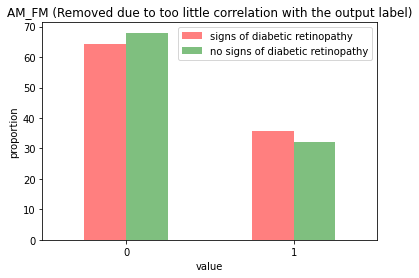

In [ ]:
# Extract the percentages of the different values for the label "signs of diabetic retinopathy"
percentages_diabetes = df_diabetes["AM_FM"].loc[y_diabetes == 0].value_counts(normalize=True) * 100 

# Extract the percentages of the different values for the alive labels
percentages_noDiabetes = df_diabetes["AM_FM"].loc[y_diabetes == 1].value_counts(normalize=True) * 100 

# Merge both of the above into a dataframe with 2 columns
percentages = pd.DataFrame({
    'signs of diabetic retinopathy' : percentages_diabetes,
    'no signs of diabetic retinopathy' : percentages_noDiabetes
})

# Plot the above dataframe
percentages.plot.bar(rot=0, color = {'signs of diabetic retinopathy': 'red', 'no signs of diabetic retinopathy': 'green'}, alpha = 0.5, xlabel='value', ylabel = 'proportion')

# Add the legend & title to the plot
plt.title("AM_FM (Removed due to too little correlation with the output label)")

# Print out the percentages of 2 / 1 values of sgot for dead and alive respectively
print(f"For the signs of diabetic retinopathy label, the percentages of 1 and 0 values for AM_FM are {round(percentages['signs of diabetic retinopathy'][1], 2)}% and {round(percentages['signs of diabetic retinopathy'][0], 2)}% respectively.")
print(f"For the no signs of diabetic retinopathy label, the percentages of 1 and 0 values for AM_FM are {round(percentages['no signs of diabetic retinopathy'][1], 2)}% and {round(percentages['no signs of diabetic retinopathy'][0],2)}% respectively.")

We can again see above an explanation for removing this feature: the distributions of the data for the two labels are too similar, with the percentages of `1`'s and `0`'s for the "signs of diabetic retinopathy" label being around 36% and 64% respectively, while those same percentages for the other label are around 32% and 68% respectively.
We were thus correct to eliminate this feature from the dataset, since its significance is very small and we need to reduce the number of features to reduce training time later on.

Before converting our pandas dataframe to a numpy array, we join X_diabetes and y_diabetes again one last time to drop duplicate rows since we dropped some features that could have been the differentiating factor between different inputs, thus creating duplicate datapoints.

In [ ]:
# Join y_diabetes into the input matrix
X_diabetes["class"] = y_diabetes

# Number of rows before dropping duplicates
before_drop = X_diabetes.shape[0]

# Drop duplicates again
X_diabetes.drop_duplicates(inplace=True)

# Number of rows after dropping duplicates
after_drop = X_diabetes.shape[0]

# Separate features and labels again
y_diabetes = X_diabetes["class"]
X_diabetes.drop("class", axis = 1, inplace=True)

# Print result
print(f"We dropped {before_drop - after_drop} new duplicates")

We dropped 2 new duplicates


Similar to the hepatitis dataset, we convert the data to numpy arrays after extracting whether each column is continuous or not for future use.

In [ ]:
# Array where input i indicates whether feature i of the diabetes dataset is continuous (True) or categorical (False)
is_continuous_feature_diabetes = [x in continuous_features_diabetes for x in X_diabetes.columns]

# Array to store all of the features kept after the data-processing
features_diabetes = X_diabetes.columns.values

# Convert the dataframes to numpy arrays
X_diabetes = X_diabetes.to_numpy()
y_diabetes = y_diabetes.to_numpy()

Now that our hepatitis and diabetes datasest are pre-processed, we are ready to implement the KNN and Decision Tree models.

# Task 2: Implementing KNN and DT

## 2.1 Implementing KNN 

We begin this section by defining the distance functions for K Nearest Neighbours model. As we are working with both categorical and continuous inputs, we will use euclidian distance for continuous features and hamming distance for categorical features. However, the euclidean distance function has a caveat. Since we will be implementing weighted KNN, we will need to find the inverses of distances later on (Similarities). And since we will be finding training accuracies for the datasets, each training point will be compared to itself, returning a distance of 0. Since we want to avoid working with `np.inf` values resulting from a division by zero, we will add $10^{-6}$ to all distances before returning the distance matrix. This ensures we don't end up with `np.inf`'s, while keeping the similarities of points with distance 0 very big ($10^{6}$ to be exact).

In [ ]:
# Distance functions

# Distance function for 2 inputs x1 and x2 that only have continuous features
# If x1 and x2 are matrices, it broadcasts and returns a matrix where entry (i,j) is the distance from point i in x2 to point j in x1
def euclidean_distance(x1, x2, is_continuous_feature=None):
  distance = np.sqrt(np.sum((x1[None, :, :] - x2[:, None, :])**2, axis=-1)) # Broadcasting if passed a matrix
  # Check whether we have distances = 0 in the array in case we test on the training data to get the training accuracy
  if np.count_nonzero(distance == 0) > 0:
    return distance + 0.000_001 # We avoid returning 0s because the weighted KNN model divides by distances to find similarities (Avoid getting infinities)
  else:
    return distance # Return the actual distance otherwise

# Distance function for 2 inputs x1 and x2 that only have categorical features
# If two categories are different, we add 1 to the output distance
# If x1 and x2 are matrices, it broadcasts and returns a matrix where entry (i,j) is the distance from point i in x2 to point j in x1
def hamming_distance(x1, x2, is_continuous_feature=None):
  return np.sum(x1[None, :, :] != x2[:, None, :], axis=-1).astype(float) # Broadcasting if passed a matrix, and converting to float

We notice that Euclidean and Hamming distances are not on the same "scale", meaning that a distance of 1 for our standardized continuous features might be much more significant than a distance of 1 for categorical input features. Therefore, the two results cannot be simply added together. We will account for this issue by designing a function that will assign weights to each of the euclidian and hamming distances respectively, mixing them together. This function was completely designed by us, and accounts for the number of continuous VS categorical features, weighing the two distances after standardizing them. Since we added $10^{-6}$ in the euclidean distance function which is used here, we don't need to add anything down below since we won't get distances of 0. We will compare the performances of the `euclidean_distance` and `euclidean_hamming_mix_distance` functions in section 3.4.1.

In [ ]:
# This is the distance function that will be used for the KNN model
# It takes in 2 matrices X_test and X_train as well as a boolean array revealing whether
# each feature is either continuous or categorical
# Returns a matrix where entry (i,j) is the distance from point i in X_test to point j in X_train
# Doesn't use broadcasting because it unfortunately cannot use numpy operations (We need to check whether feature is continuous first)
def euclidean_hamming_mix_distance(X_train, X_test, is_continuous_feature): # x1, x2:
  
  # Separate the continuous and categorical features into 2 matrices
  X_test_continuous = X_test[:, is_continuous_feature]
  X_train_continuous = X_train[:, is_continuous_feature]
  X_test_categorical = X_test[:, np.logical_not(is_continuous_feature)]
  X_train_categorical = X_train[:, np.logical_not(is_continuous_feature)]

  # Compute the euclidian and hamming distances using broadcasting
  continuous_distances = euclidean_distance(X_train_continuous, X_test_continuous)
  categorical_distances = hamming_distance(X_train_categorical, X_test_categorical)

  # We now scale both types of distances with respect to the standard deviation
  continuous_distances /= continuous_distances.std()
  categorical_distances /= categorical_distances.std()

  # We then perform the weighted average of both distance matrices depending on the number categorical VS continuous features
  num_features = len(is_continuous_feature)
  num_continuous = np.count_nonzero(is_continuous_feature)
  num_categorical= num_features - num_continuous

  # The distance matrix is the weighted average of both matrices
  continuous_distances *= (num_continuous / num_features)
  categorical_distances *= (num_categorical / num_features)
  distance = continuous_distances + categorical_distances

  return distance

\We will proceed by implementing the `weighted KNN` class, inspired by the tutorial code.

In [ ]:
class KNN:
  
  # Constructor
  def __init__(self, K, is_continuous_feature, distance_function):
    
    self.K = K # Integer value representing the number of nearest neighbours we want to compute
    self.is_continuous_feature = is_continuous_feature # List of boolean variables where each index represents a feature and is True if the feature is continuous
    self.distance_function = distance_function # Distance function as defined above
  
    # Defined in the fit method later
    self.X_train = None
    self.y_train = None
    self.C = None

  # Fits the KNN to the input data (Implemented later)
  def fit(self, X_train, y_train):
    pass

  # Returns the predicted classes, probabilities, and nearest neighbor indices of a testing dataset (Implemented later) 
  def predict(self, X_test):  
    pass

Now that we have our constructor ready, we can proceed to implementing the `fit` function which simply stores the datapoints. 

In [ ]:
# Fits the KNN to the input data (Implemented later)
def fit(self, X_train, y_train):
  
  self.X_train = X_train # X_train is a multidimensional NumPy array that represents the matrix storing the features of the datapoints
  
  self.y_train = y_train # y_train is a one-dimensional NumPy array that represents the labels of each datapoint
  
  self.C = np.max(y_train) + 1 # total number of classes, computed by taking the max label of the y_train variable + 1 to account for index 0
  
  # self.C assumes that labels are represented by integer values from 0 to n-1 such that they can be stored as indices in an array
  return self

# Assign the fit method to the KNN class
KNN.fit = fit

We can now proceed to implement the `predict` method that computes the distances and probabilities of the nearest neighbours, using a weighted approach, weighing the label of each of the KNNs by its similarity, meaning that points closer to the testing point will affect its label more than others [[16]](https://medium.com/@mohdsaeed.khan25/what-is-weighted-knn-and-how-does-it-work-aa8e461fd5d7).

In [ ]:
# Predicts the nearest neighbours of a testing dataset (Implemented later) 
def predict(self, X_test):  

  # Compute the distances from each of the testing datapoints to each point in stored in the model
  all_distances = self.distance_function(self.X_train, X_test, self.is_continuous_feature) 

  # Get the indices of the K nearest datapoints to every point
  k_nearest_indices = np.argsort(all_distances, axis=-1)[:, :self.K]
  
  # Get the similarities to the K nearest points (Similarity = 1/distance)
  k_nearest_similarities = 1/np.sort(all_distances,axis=-1)[:, :self.K]
  
  # Retrieve the labels of K points with shortest distances to each testing point
  k_nearest_labels = self.y_train[k_nearest_indices]

  # Initialize the probabilities matrix
  probabilities = np.zeros((X_test.shape[0], self.C))

  # For each point, add up the similarities of the K nearest neighbors in the corresponding class column
  for i, test_point in enumerate(X_test):
    for j, label in enumerate(k_nearest_labels[i]):
      probabilities[i, label] += k_nearest_similarities[i, j]
  
  # Divide each row of the probabilities matrix by the sum of the similarities of the K nearest neighbors of the corresponding test point
  probabilities /= np.sum(k_nearest_similarities, axis = -1)[:, None]

  # Return the prediction array as well as the K nearest neighbor indices for each testing point
  return np.argmax(probabilities, axis=-1), probabilities, k_nearest_indices

# Assign the predict function to the KNN class
KNN.predict = predict

The implementation of KNN model is now complete. 

## 2.2 Implementing Decision Tree

We will start by defining a node class to represent the individual nodes of the decision tree, again inspired by the tutorial code, but with multiple optimizations. For example, we decided to make each `Node` point to the root, where we store all the datapoints instead of duplicating them inside every node. Furthermore, since we have both categorical and continuous input features, the threshold variable will be None for categorical features since they are binary (0 or 1) and a real-value for continuous inputs.

In [ ]:
class Node:

  # Constructor
  def __init__(self, data_indices, tree, parent):
    self.data_indices = data_indices # The indices of the inputs that will be split in this node
    self.tree = tree # The tree this node is part of
    self.left = None # The left node, contains datapoints with values <= threshold for continuous features, or class 0 for categorical features // None if self is a leaf
    self.right = None # The right node, contains datapoints with values > threshold for continuous features, or class 1 for categorical features // None if self is a leaf
    self.feature =  None # The feature based on which we are splitting the data
    self.threshold = None # The threshold based on which we are splitting, or none for categorical features (0's will branch left, 1's will branch right)
    if parent != None: self.depth = parent.depth + 1 # If the node has a parent, we increase the depth by 1
    else: self.depth = 0 # Otherwise, the node is the root of the tree and so its depth is 0
    self.label_probabilities = np.bincount(tree.y_train[data_indices], minlength=tree.num_classes) # Compute the number of occurence of each label
    self.label_probabilities = self.label_probabilities / np.sum(self.label_probabilities) # Divide by the sum of the occurences to get the probabilities of each class
 
  # To find the best split at a given node (Implemented later)
  def find_best_split(self):
    pass

We will now proceed to define a `DecisionTree` class which will group these nodes together along with some extra information. Namely, the `is_continuous_feature` array will be a boolean array, where element at index i is a boolean indicating whether feature at column i is a continuous or categorical feature.

In [ ]:
class DecisionTree:

  # Constructor
  def __init__(self, min_leaf_datapoints, max_depth, training_cost_function, is_continuous_feature):
    self.max_depth = max_depth # The max possible depth for the tree (Hyper-parameter)
    self.min_leaf_datapoints = min_leaf_datapoints # The minimum number of datapoints in a leaf (Hyper-parameter)
    self.training_cost_function = training_cost_function # The training cost function
    self.root = None # The root of the tree
    self.X_train = None # The inputs of the training set
    self.y_train = None # The corresponding labels of the training set
    self.num_classes = None  # Number of classes in the dataset (Both diabetes and hepatitis have 2 classes)
    self.is_continuous_feature = is_continuous_feature # Array where element i is true if column i of X_train is continuous, false if categorical

  # To fit the model to the training data (Implemented later)
  def fit(self, X_train, y_train):
    pass                      
  
  # To predict the labels AND the probabilities on the testing data (Implemented later)
  def predict(self, X_test):
    pass

In order to implement the above fit and predict methods, we will start by writing the `find_best_split()` method of the Node class that uses a greedy algorithm to find the best possible split for a given node. It utilizes the private helper method `_compute_split_cost()` defined below that computes the cost of a node given the indices of the datapoints in its left and right subtrees.

In [ ]:
# To find the best split at a given node
def find_best_split(self):

  # Keep track of the best parameters
  best_feature = None
  best_threshold = None
  best_cost = np.Inf
  best_left_indices = None
  best_right_indices = None

  # Form an array of the sorted data in that node
  sorted_values = np.sort(self.tree.X_train[self.data_indices], axis=0)

  # Compute a list of every possible threshold for every average of two consecutive values for the feature
  thresholds = (sorted_values[1:] + sorted_values[:-1]) / 2.0

  # Iterate over the features
  for feature in range(self.tree.X_train.shape[1]):
    
    # Extract the values corresponding to that feature
    feature_values = self.tree.X_train[self.data_indices, feature]

    # If the feature is continuous
    if (self.tree.is_continuous_feature[feature]):

      # Iterate over all possible thresholds
      for threshold in thresholds[:,feature]:

        # Compute the left and right indices for that split
        left_data_indices = self.data_indices[feature_values <= threshold]
        right_data_indices = self.data_indices[feature_values > threshold]

        # Check whether the left / right nodes are empty -> Not a split
        if left_data_indices.shape[0] == 0 or right_data_indices.shape[0] == 0:                
          continue

        # Find the cost of the split by calling the helper method
        split_cost = self._compute_split_cost_(left_data_indices, right_data_indices)
        
        # Compare the cost of the split with the best cost up until that point
        if split_cost < best_cost:
          best_feature = feature
          best_threshold = threshold
          best_cost = split_cost
          best_left_indices = left_data_indices
          best_right_indices = right_data_indices

    # If the feature is categorical (binary), we can only split in one way (false goes left, true goes right)
    else:

      # Compute the left and right indices for that split
      left_data_indices = self.data_indices[feature_values == 0]
      right_data_indices = self.data_indices[feature_values == 1]
      
      # Check whether the left / right nodes are empty -> Not a split
      if left_data_indices.shape[0] == 0 or right_data_indices.shape[0] == 0:                
        continue

      # Find the cost of the split by calling the helper method
      split_cost = self._compute_split_cost_(left_data_indices, right_data_indices)
      
      # Compare the cost of the split with the best cost up until that point
      if split_cost < best_cost:
        best_feature = feature
        best_threshold = None # For categorical features, we return None as the threshold
        best_cost = split_cost
        best_left_indices = left_data_indices
        best_right_indices = right_data_indices

  # Set the best parameters as instance variable values
  self.feature = best_feature # The feature based on which we are splitting the data
  self.threshold = best_threshold # The threshold based on which we are splitting
  
  # Return the best split indices for left and right as a tuple along with the cost of the split
  return (best_left_indices, best_right_indices, best_cost)
  
# Helper method that computes the cost of a split given the indices of its left and right nodes' data
def _compute_split_cost_(self, left_data_indices, right_data_indices):

  # Use the training cost function to compute the cost of the split
  left_cost = self.tree.training_cost_function(self.tree.y_train[left_data_indices])
  right_cost = self.tree.training_cost_function(self.tree.y_train[right_data_indices])

  # Find the cost of the split by averaging over both sides and return it
  return ((left_data_indices.shape[0] * left_cost) + (right_data_indices.shape[0] * right_cost)) / self.data_indices.shape[0]

# Set the above methods to be part of the Node class
Node.find_best_split = find_best_split
Node._compute_split_cost_ = _compute_split_cost_

Now that we have a function to greedily compute the best split of any given node, we can move on to implementing the `fit` method of the `DecisionTree` class.

In [ ]:
# To fit the model to the training data (Implemented later)
def fit(self, X_train, y_train):

  # Set X_train and y_train as instance variables for the class
  self.X_train = X_train
  self.y_train = y_train

  # Set num_classes to be the number of distinct classes, assuming they start at 0
  self.num_classes = np.max(y_train) + 1

  # Generate a numpy array of all indices from 0 to len(X_train) to represent all indices in the dataset
  indices = np.arange(X_train.shape[0])

  # Create the root of the tree and pass it indices as its data_indices (All the points)
  self.root = Node(indices, self, None)

  # Recurse on the root
  self._fit_(self.root)

  # Return the decision tree
  return self

# Recursive private helper method that takes in the current node in the recursion
def _fit_(self, node):
  
  # Conditions of depth / datapoint amount for termination of the recursion resulting in a leaf node
  if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_datapoints:
    return

  # Another condition for termination is if all datapoints have the same class (No reason to split further)
  if(len(np.unique(self.y_train[node.data_indices])) == 1):
    return

  # Find the best split for the node
  left_indices, right_indices, cost = node.find_best_split()

  # If no splits had non-empty nodes (Due to the continue statements in find_best_split), we stop splitting
  if np.isinf(cost):
    return

  # Create the left and right subnodes (Self is the tree, node is the parent)
  left = Node(left_indices, self, node)
  right = Node(right_indices, self, node)

  # Set left and right to be the left and right children respectively
  node.left = left
  node.right = right

  # Recursively fit those two nodes
  self._fit_(left)
  self._fit_(right)

# Making this method part of the DecisionTree class
DecisionTree.fit = fit
DecisionTree._fit_ = _fit_

Finally, we define the `predict` method which takes in data points and traverses the tree, predicting the probability of each class respectively for all the input points.

In [ ]:
def predict(self, X_test):

  # If the user tries predicting probabilities before training the model
  if self.root == None:
    return None

  # To store the class probabilities we'll compute next
  # Each row represents the probabilities of a distinct point, and each column the probabilities of a distinct output label
  label_probabilities = np.zeros((X_test.shape[0], self.num_classes))

  # Iterate over the input test set (Index i, Vector input)
  for i, input in enumerate(X_test):
    
    # Start the traversal at the root
    cur = self.root

    # While we're not yet at a leaf, compare with threshold
    while cur.left != None:
      
      # Extract the threshold for the comparison
      # If cur.threshold = None, it means we're dealing with a categorical feature (Values 0 or 1)
      # The threshold of 0.5 will split 0's to the left and 1's to the right as intended
      threshold = cur.threshold if cur.threshold != None else 0.5

      # Go left or right based on the value of the feature
      if(input[cur.feature] < threshold):
        cur = cur.left
      else:
        cur = cur.right

    # We got to the leaf, extract the class probabilities into the probability matrix
    label_probabilities[i,:] = cur.label_probabilities

  # Return the predicted labels
  return np.argmax(label_probabilities, axis=-1), label_probabilities

# Making this method part of the DecisionTree class
DecisionTree.predict = predict

Now that the decision tree class is complete, we will define two functions for computing the entropy and gini index costs respectively later in the code. These 2 functions will be compared in section 3.4.2 of the notebook.

In [ ]:
# Computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels) # Compute the probabiltiies of each class in the node
    class_probs = class_probs[class_probs > 0]  # Remove 0 probabilities to avoid computing log(0) since lim xlogx when x -> 0+ is 0
    return -np.sum(class_probs * np.log2(class_probs)) # Expression for entropy is - sigma p(x)log2[p(x)]

# Computes the Gini Index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels) # Compute the probabiltiies of each class in the node
    return 1 - np.sum(np.square(class_probs)) # Expression for gini index is 1 - sigma p(x)^2

# Computes misclassification cost
def cost_misclassification(labels):
    class_probs =  np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs) # Minoritary class' probability

We will also implement a function to help visualizing the Decision Tree by printing it to the console [[17]](https://mljar.com/blog/visualize-decision-tree).

In [ ]:
# Method to print the Decision Tree to the console, given the root of the tree
def print_DT(node, dataset, indent = "|"):
  if (node == None): 
    return
  else:
    print_node(node, dataset, indent) # Print the information about the node using a helper method
    if node.left != None: # Don't check for a right None because if the left is none, the right has to be none too
      print("%s   left:\n" % (indent), end="")  # Recursively call the method on the sub-structure of the tree
      print_DT(node.left, dataset, indent + "   |")
      print("%s   right:\n" % (indent), end="") # Recursively call the method on the sub-structure of the tree
      print_DT(node.right, dataset, indent + "   |")

# helper method to print the information of the current node
def print_node(node, dataset, indent):
  # Check the dataset we are in to print the correct feature names
  if dataset == "hepatitis":
    if node.threshold != None:  
      print("%s--- Feature" % (indent), features_hepatitis[node.feature], "<=" , str(node.threshold)) # print threshold of the node if the split is based on a continuous feature
    elif node.feature != None:
      print("%s--- Feature" % (indent), features_hepatitis[node.feature], " 0 or 1?") # If the split is based on a categorical feature
    else:
      if np.argmax(node.label_probabilities) == 0: # If the node is not a split, print the label associated with the highest probability (depending on dataset)
        print("%s--- Label: dead. Probability:" % (indent), node.label_probabilities[0])
      elif np.argmax(node.label_probabilities) == 1:
        print("%s--- Label: alive. Probability:" % (indent), node.label_probabilities[1])   
  # Check the dataset we are in to print the correct feature names
  elif dataset == "diabetes":
    if node.threshold != None:
      print("%s--- Feature" % (indent), features_diabetes[node.feature], "<=" , str(node.threshold)) # Print threshold of the node if the split is based on a continuous feature
    elif node.feature != None:
      print("%s--- Feature" % (indent), features_diabetes[node.feature], " 0 or 1?") # Print "0 or 1?" ff the split is based on a categorical feature
    else :
      if np.argmax(node.label_probabilities) == 0: # If the node is not a split, print the label associated with the highest probability (depending on dataset)
        print("%s--- Label: no signs of diabetes. Probability:" % (indent), node.label_probabilities[0])
      elif np.argmax(node.label_probabilities) == 1:
        print("%s--- Label: signs of diabetes. Probability:" % (indent), node.label_probabilities[1])

# Task 3: Running experiments (Assignment questions)

First, we split our datasets between training and testing, then we further split the training datasets into training and validation. We use the below percentages for the splits:
* For the `hepatitis` dataset, we use `50%` of the data for training, `25%` for validation, and `25%` for testing. 
* On the other hand, for the `diabetes` dataset, we use `60%` of the data for training, `20%` for validation, and `20%` for testing. 

The reason for this disparity is that the `hepatitis` dataset is much smaller than the `diabetes` dataset, meaning that the validation and testing datasets will be very small.

In [ ]:
# Hepatitis dataset
X_train_validate_hepatitis, X_test_hepatitis, y_train_validate_hepatitis, y_test_hepatitis = train_test_split(X_hepatitis, y_hepatitis, test_size = 0.25, random_state=5, shuffle = True)
X_train_hepatitis, X_validate_hepatitis, y_train_hepatitis, y_validate_hepatitis = train_test_split(X_train_validate_hepatitis, y_train_validate_hepatitis, test_size = 0.3, random_state=5, shuffle = True)

# Diabetes dataset
X_train_validate_diabetes, X_test_diabetes, y_train_validate_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes, test_size = 0.2, random_state=5, shuffle = True)
X_train_diabetes, X_validate_diabetes, y_train_diabetes, y_validate_diabetes = train_test_split(X_train_validate_diabetes, y_train_validate_diabetes, test_size = 0.3, random_state=5, shuffle = True)

We then proceed to standardize the separated data, thus avoiding data leakage since we separated the different sets first. Note that categorical inputs don't need standardization since their numerical value doesn't really mean anything.

In [ ]:
# Standardize the data in the hepatitis numpy arrays
for i, cont in enumerate(is_continuous_feature_hepatitis):
  if cont:
    X_train_hepatitis[:, i] = (X_train_hepatitis[:, i] - X_train_hepatitis[:, i].mean()) / X_train_hepatitis[:, i].std()
    X_validate_hepatitis[:, i] = (X_validate_hepatitis[:, i] - X_validate_hepatitis[:, i].mean()) / X_validate_hepatitis[:, i].std()
    X_test_hepatitis[:, i] = (X_test_hepatitis[:, i] -  X_test_hepatitis[:, i].mean()) /  X_test_hepatitis[:, i].std()

# Standardize the data in the diabetes numpy arrays
for i, cont in enumerate(is_continuous_feature_diabetes):
  if cont:
    X_train_diabetes[:, i] = (X_train_diabetes[:, i] - X_train_diabetes[:, i].mean()) / X_train_diabetes[:, i].std()
    X_validate_diabetes[:, i] = (X_validate_diabetes[:, i] - X_validate_diabetes[:, i].mean()) / X_validate_diabetes[:, i].std()
    X_test_diabetes[:, i] = (X_test_diabetes[:, i] -  X_test_diabetes[:, i].mean()) /  X_test_diabetes[:, i].std()

### 3.1 Comparison between KNN and DT

We will define the below method requested in the assignment prompt, that given the labels predicted by a model as well as the expected labels, returns the accuracy of the prediction.

In [ ]:
def evaluate_acc(actual_labels, predicted_labels):
  return np.sum(predicted_labels == actual_labels) / actual_labels.shape[0]

We will now plot compare both models for each dataset using 3 metrics:

*  Accuracy
*  ROC curve
*  PRC curve

The `sklearn` library will be useful to generate the latter 2 curves. As stated before, the Precision-Recall curve is better suited for imbalanced data, which is the case for the hepatitis dataset (See pre-processing section 1.1), while the ROC curve will be better suited for the diabetes dataset since it is balanced (see pre-processing section 1.2). Nonetheless, we will still proceed to plot both types of curves for both datasets, comparing the results.

#### 3.1.1 Hepatitis dataset

##### 3.1.1.1 Accuracy comparison

We will now compare the accuracy of the Decision tree and KNN on the hepatitis dataset. 

For this comparison, we will use `K = 5` with `euclidean_hamming_mix_distance` as the distance function. The reason for this choice is that the above are the best parameters, following the hyperparameter tuning done in the section 3.2 later on.

In [ ]:
knn_hepatitis = KNN(5, is_continuous_feature_hepatitis, euclidean_hamming_mix_distance)

# Use that model to predict
knn_preds_hepatitis, knn_probas_hepatitis, _ = knn_hepatitis.fit(X_train_hepatitis, y_train_hepatitis).predict(X_test_hepatitis)
accuracy = evaluate_acc(knn_preds_hepatitis, y_test_hepatitis)

# Print the accuracy result
print(f"Using KNN with the best parameters on the hepatitis dataset, we obtain a testing accuracy of {round(accuracy, 5) * 100}%\n")

Using KNN with the best parameters on the hepatitis dataset, we obtain a testing accuracy of 74.359%



We will also use the best parameters found for the decision tree on this dataset, meaning `max_depth = 3` of the tree and `min_leaf_datapoints = 6`. Moreover, we will use the `cost_entropy` as the cost function arbitrarily. Different cost functions will then be compared later on in section 3.4.2 of the notebook.

 We will also use the `print_DT` function we wrote above to visualize the generated Decision tree, along with the probabilities with which we are making our most probable label prediction.

In [ ]:
dt_hepatitis = DecisionTree(min_leaf_datapoints=6, 
                  max_depth=3, 
                  training_cost_function=cost_entropy, 
                  is_continuous_feature=is_continuous_feature_hepatitis)

# Use the model to predict
dt_preds_hepatitis, dt_probas_hepatitis = dt_hepatitis.fit(X_train_hepatitis, y_train_hepatitis).predict(X_test_hepatitis)
accuracy = evaluate_acc(dt_preds_hepatitis, y_test_hepatitis)

# Print the accuracy result
print(f"Using Decision Tree with the best parameters found on the hepatitis dataset, we obtain a testing accuracy of {round(accuracy, 5) * 100}%\n")

# Print the decision tree
print_DT(dt_hepatitis.root, "hepatitis")

Using Decision Tree with the best parameters found on the hepatitis dataset, we obtain a testing accuracy of 66.667%

|--- Feature age <= -0.4125159836862543
|   left:
|   |--- Label: alive. Probability: 1.0
|   right:
|   |--- Feature albumin <= -1.6525433972344936
|   |   left:
|   |   |--- Label: dead. Probability: 1.0
|   |   right:
|   |   |--- Feature alk_phosphate <= 0.025112387712331156
|   |   |   left:
|   |   |   |--- Label: alive. Probability: 0.8648648648648649
|   |   |   right:
|   |   |   |--- Label: dead. Probability: 0.5555555555555556


Therefore, we can conclude that, after validating both models and finding the best hyperparameters, the KNN model has a greater accuracy on the hepatitis dataset compared to the Decision Tree model, meaning that it is a better fit for the data based on the accuracy metric.

##### 3.1.1.2 ROC curve comparson

We will now proceed to plot the ROC curves of both models for the hepatitits dataset.

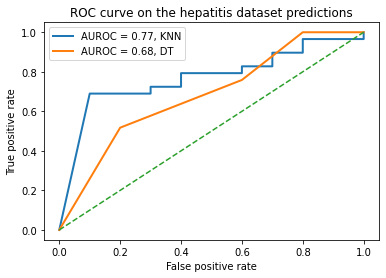

In [ ]:
# Extract the KNN ROC curve
fpr_hepatitis_knn, tpr_hepatitis_knn, _ = roc_curve(y_test_hepatitis, knn_probas_hepatitis[:, 1]) # Pass only the probabilities of the positive class
roc_auc_knn = roc_auc_score (y_test_hepatitis, knn_probas_hepatitis[:, 1])

# Extract the decision tree ROC curve
fpr_hepatitis_dt, tpr_hepatitis_dt, _ = roc_curve(y_test_hepatitis, dt_probas_hepatitis[:, 1])
roc_auc_dt = roc_auc_score (y_test_hepatitis, dt_probas_hepatitis[:, 1])

# y = x
x = np.linspace(0,1,100)

# Plot both ROC curves on one diagram
plt.plot(fpr_hepatitis_knn, tpr_hepatitis_knn, lw=2, label="AUROC = %0.2f, KNN"%roc_auc_knn)
plt.plot(fpr_hepatitis_dt, tpr_hepatitis_dt, lw=2, label="AUROC = %0.2f, DT"%roc_auc_dt)
plt.plot(x, x, '--')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve on the hepatitis dataset predictions")
plt.legend(loc="best") # Legend displayed on the best spot

Again, KNN performs better than DT using the ROC metric, since its AUROC is higher that that of decision tree. In concrete terms, this means that the TPR to FPR ratio of KNN is on average higher for various thresholds of positive predictions.

##### 3.1.1.3 PRC curve comparison

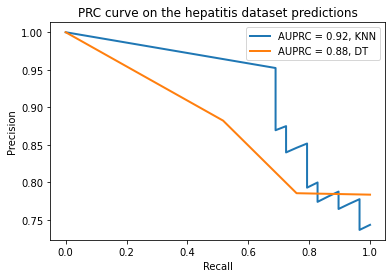

In [ ]:
# Extract the KNN PRC curve
precision_hepatitis_knn, recall_hepatitis_knn, _ = precision_recall_curve(y_test_hepatitis, knn_probas_hepatitis[:,1])
auprc_knn = auc(recall_hepatitis_knn, precision_hepatitis_knn)

# Extract the decision tree PRC curve
precision_hepatitis_dt, recall_hepatitis_dt, _ = precision_recall_curve(y_test_hepatitis, dt_probas_hepatitis[:,1])
auprc_dt = auc(recall_hepatitis_dt, precision_hepatitis_dt)

# Plot the PRC curves
plt.plot(recall_hepatitis_knn, precision_hepatitis_knn, lw=2, label="AUPRC = %0.2f, KNN"%auprc_knn)
plt.plot(recall_hepatitis_dt, precision_hepatitis_dt, lw=2, label="AUPRC = %0.2f, DT"%auprc_dt)
plt.xlabel("Recall")  # Label the axis
plt.ylabel("Precision")
plt.title("PRC curve on the hepatitis dataset predictions")
plt.legend(loc="best") # Legend displayed on the best spot

As can be seen above, the KNN model performed flawlessly on the `AUROC` assesment, while the DT model was almost flawless. This is due to having good data separation and data quality for the `hepatitis` dataset.

#### 3.1.2 Diabetes dataset

##### 3.1.2.1 Accuracy comparison

As with the Hepatitis dataset, we will start by comparing the accuracy of both KNN and the Decision Tree on the diabetes dataset. This will also be done using the best parameters found by our experiments we ran later in the code.

For this comparison, we will use the best parameters found in section 3.2 for KNN on this dataset, meaning `K = 8` with `euclidean_hamming_mix_distance` as the distance function.

In [ ]:
knn_diabetes = KNN(8, is_continuous_feature_diabetes, euclidean_hamming_mix_distance)

# Use that model to predict
knn_preds_diabetes, knn_probas_diabetes, _ = knn_diabetes.fit(X_train_diabetes, y_train_diabetes).predict(X_test_diabetes)
accuracy = evaluate_acc(knn_preds_diabetes, y_test_diabetes)

# Print the accuracy result
print(f"Using KNN with the best parameters on the diabetes dataset, we obtain a testing accuracy of {round(accuracy, 5) * 100}%\n")

Using KNN with the best parameters on the diabetes dataset, we obtain a testing accuracy of 64.19200000000001%



We will also use the best parameters found for the decision tree on this dataset, which are `max_depth = 3` and `min_leaf_datapoints = 3`. Moreover, we will use the `cost_entropy` as the cost function since it was revealed be the best cost function for this dataset as shown later in secion 3.3.2.

 We will also use the `print_DT` function we wrote above to visualize the generated Decision tree.

In [ ]:
dt_diabetes = DecisionTree(min_leaf_datapoints=3, 
                  max_depth=3, 
                  training_cost_function=cost_entropy, 
                  is_continuous_feature=is_continuous_feature_diabetes)

# Use the model to predict
dt_preds_diabetes, dt_probas_diabetes = dt_diabetes.fit(X_train_diabetes, y_train_diabetes).predict(X_test_diabetes)
accuracy = evaluate_acc(dt_preds_diabetes, y_test_diabetes)

# Print the accuracy result
print(f"Using Decision Tree with the best parameters found on the diabetes dataset, we obtain a testing accuracy of {round(accuracy, 5) * 100}%\n")

# Print the decision tree
print_DT(dt_diabetes.root, "diabetes")

Using Decision Tree with the best parameters found on the diabetes dataset, we obtain a testing accuracy of 60.26200000000001%

|--- Feature exudates_15 <= -0.0654952733907595
|   left:
|   |--- Feature exudates_8 <= -0.515448741019088
|   |   left:
|   |   |--- Feature exudates_10 <= -0.7121946637826546
|   |   |   left:
|   |   |   |--- Label: no signs of diabetes. Probability: 0.782608695652174
|   |   |   right:
|   |   |   |--- Label: signs of diabetes. Probability: 0.6350710900473934
|   |   right:
|   |   |--- Feature exudates_8 <= 0.94764941115197
|   |   |   left:
|   |   |   |--- Label: no signs of diabetes. Probability: 0.6615384615384615
|   |   |   right:
|   |   |   |--- Label: signs of diabetes. Probability: 0.6052631578947368
|   right:
|   |--- Feature exudates_8 <= 0.013174395261847252
|   |   left:
|   |   |--- Feature exudates_15 <= 0.9550414118255819
|   |   |   left:
|   |   |   |--- Label: signs of diabetes. Probability: 0.65
|   |   |   right:
|   |   |   |--- L

Again, we can conclude that the KNN model has a greater accuracy on the diabetes dataset compared to the Decision Tree model. KNN was thus a better fit for both datasets. However, for the `diabetes` dataset, the margin of difference between the two was very slim, while KNN performed significantly better on the hepatitis dataset in terms of accuracy. Furthermore, both models performed relatively poorly on the `diabetes` dataset due to the bad quality of the data, as analyzed in the pre-processing section 1.2 of the notebook.

#####3.1.2.2 ROC curve comparison

We now proceed to plot the ROC curves of both models for the diabetes dataset, as we did for the hepatitis dataset.

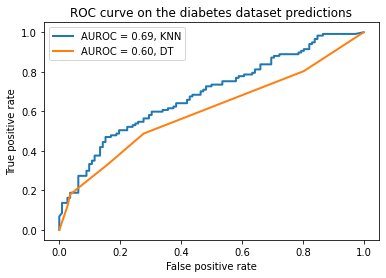

In [ ]:
# Extract the KNN ROC curve
fpr_diabetes_knn, tpr_diabetes_knn, _ = roc_curve(y_test_diabetes, knn_probas_diabetes[:, 1])
roc_auc_knn = roc_auc_score (y_test_diabetes, knn_probas_diabetes[:, 1])

# Extract the decision tree ROC curve
fpr_diabetes_dt, tpr_diabetes_dt, _ = roc_curve(y_test_diabetes, dt_probas_diabetes[:, 1])
roc_auc_dt = roc_auc_score (y_test_diabetes, dt_probas_diabetes[:, 1])

# Plot the ROC curves
plt.plot(fpr_diabetes_knn, tpr_diabetes_knn, lw=2, label="AUROC = %0.2f, KNN"%roc_auc_knn)
plt.plot(fpr_diabetes_dt, tpr_diabetes_dt, lw=2, label="AUROC = %0.2f, DT"%roc_auc_dt)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve on the diabetes dataset predictions")
plt.legend(loc="best") # Legend displayed on the best spot

Again, this finding backs up the conclusion we extracted from section 3.1.2.1, stating that KNN is better than Decision Tree for this dataset too, but by a very slim margin. We can however clearly see that, for this dataset, both `AUROC`s are much lower, again pointing to the bad data quality, as seen in the pre-processing section 1.2 of the notebook.

##### 3.1.2.3 PRC curve comparison

Uisng the PCR curve to compare the models, we see that both models perfrom really well wiht an area under the curve approaching 1.
We will now evaluate the models using the PCR curve on the diabetes dataset.

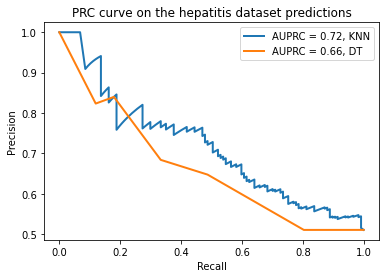

In [ ]:
# Extract the KNN PRC curve
precision_diabetes_knn, recall_diabetes_knn, _ = precision_recall_curve(y_test_diabetes, knn_probas_diabetes[:,1])
auprc_knn = auc(recall_diabetes_knn, precision_diabetes_knn)

# Extract the decision tree PRC curve
precision_diabetes_dt, recall_diabetes_dt, _ = precision_recall_curve(y_test_diabetes, dt_probas_diabetes[:,1])
auprc_dt = auc(recall_diabetes_dt, precision_diabetes_dt)

# Plot the PRC curves
plt.plot(recall_diabetes_knn, precision_diabetes_knn, lw=2, label="AUPRC = %0.2f, KNN"%auprc_knn)
plt.plot(recall_diabetes_dt, precision_diabetes_dt, lw=2, label="AUPRC = %0.2f, DT"%auprc_dt)
plt.xlabel("Recall")  # Label the axis
plt.ylabel("Precision")
plt.title("PRC curve on the hepatitis dataset predictions")
plt.legend(loc="best") # Legend displayed on the best spot

Finally, the PRC curve results also back up the conclusions of both the ROC curve and accuracy measure, with KNN standing out as the clearly better model for the diabetes dataset. Furthermore, comparing these results to the ones from section 3.1.1.3, we can get an idea of how much worse the data in the `diabetes` dataset is, with the AUPRC not being anywhere near perfect this time around.

### 3.2 Hyperparameter tuning for KNN

We will start by defining the following function, that given both a lower and upper bound for k as well as training, validation, and testing sets, finds the best performing k on the validation set for KNN, plotting a graph of K versus validation & testing accuracies, and showing the test accuracy for the k with the best validation accuracy. This code is inspired from the KNN tutorial notes in the course.

In [ ]:
def find_best_k(X_train, y_train, X_validate, y_validate, X_test, y_test, min_k, max_k, is_continuous_feature, distance_function):
  
  # To hold each value of k and its corresponding accuracy
  k_choices = list(range(min_k, max_k+1))
  validation_accuracies = []
  training_accuracies = []

  # Number of validation set samples
  n_valid = y_train.shape[0]

  # Iterate over the choices of k
  for k in k_choices:

      # Train the model
      knn = KNN(k, is_continuous_feature, distance_function)
      knn.fit(X_train, y_train)

      # Predict on validation set
      validation_preds,_, _= knn.predict(X_validate)

      # Predict on training set
      training_preds,_, _ = knn.predict(X_train)

      # Predict an accuracy
      accuracy_val = evaluate_acc(validation_preds, y_validate)
      accuracy_tr = evaluate_acc(training_preds, y_train)
      
      # Append the corresponding accuracy
      validation_accuracies.append(accuracy_val)
      training_accuracies.append(accuracy_tr)

  # Extract the best k
  best_k = k_choices[np.argmax(validation_accuracies)]
  
  # Create a model with it
  knn = KNN(best_k, is_continuous_feature, distance_function)

  # Use that model to predict on the testing set
  testing_preds, _, _ = knn.fit(X_train, y_train).predict(X_test)
  accuracy = evaluate_acc(testing_preds, y_test)

  # Plot the results
  plt.plot(k_choices, validation_accuracies, marker='o', color='blue', label='validation') # Performance on validation data for each k
  plt.plot(k_choices, training_accuracies, marker='s', color='green', label='training') # Performance on training data for each k
  plt.plot(best_k, accuracy, marker='*', color='red', label='testing') # Performance on testing data for best k from validation
  plt.xlabel("k")
  plt.ylabel("Accuracy")
  plt.legend(loc='best') # Find the best location for the legend

  # Print the testing accuracy
  print(f"For k = {best_k}, we got a validation accuracy of {round(np.max(validation_accuracies), 5) * 100}% and a testing accuracy of {round(accuracy, 5) * 100}%\n")

#### 3.2.1 Hepatitis dataset

We will now use the above function to find the best performing k for the Hepatitis dataset, as follows.

For k = 5, we got a validation accuracy of 88.571% and a testing accuracy of 74.359%



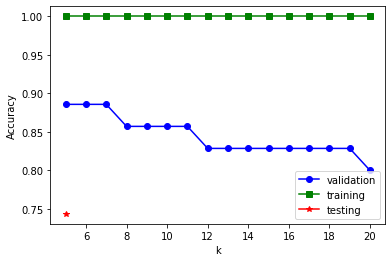

In [ ]:
find_best_k(X_train_hepatitis, y_train_hepatitis, 
            X_validate_hepatitis, y_validate_hepatitis, 
            X_test_hepatitis, y_test_hepatitis, 5, 20, 
            is_continuous_feature_hepatitis, euclidean_hamming_mix_distance)

The result of our test demonstrates that the best hyperparameter for the Hepatitis data is `k = 5` which yields the highest validation and testing accuracies of `82.9%` and `89.7%` respectively.

We also notice that our training accuracy is at a constant 100%. The reason for this is that we implemented a weighted version of the KNN that, given a testing point, gives more weight to the neighbors closest to the point. Since we are testing it with our training data, each testing point will have itself amongst its nearest neighbors. And since its distance to itself is $10^{-6}$ as defined in the Euclidean distance function before, its similarity with itself will be $10^{6}$, which can be approximated by infinity in here (No other similarity will compare). Consequently, the label of a point with similarity $10^{6}$ will dominate all other similarities, hence the result above (A point in the training set will always be predicted as its own label).

#### 3.2.2 Diabetes dataset

We will now run the testing function on the Diabetes data to find the best hyperparameter k.

For k = 8, we got a validation accuracy of 60.0% and a testing accuracy of 64.19200000000001%



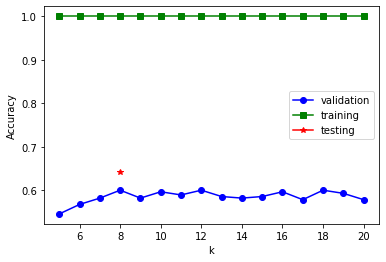

In [ ]:
find_best_k(X_train_diabetes, y_train_diabetes, 
            X_validate_diabetes, y_validate_diabetes, 
            X_test_diabetes, y_test_diabetes, 5, 20, 
            is_continuous_feature_diabetes, euclidean_hamming_mix_distance)

For the diabetes data, the best hyperparameter is `k = 8` with the validation and testing accuracies of `60%` and `64.1%` respectively.

### 3.3 Hyperparameter tuning for DT

We will now optimize the parameters of the Decision Tree for both the heptitis dataset and the diabetes one. We will compute the best depth for the tree and the best number of minimum datapoints per leaf nodes in the same function since they complement each other.

In [ ]:
def find_best_params(X_train, y_train, X_validate, y_validate, X_test, y_test, 
                     min_depth, max_depth, min_leaf_dps, max_leaf_dps, is_continuous_feature,
                     cost_function):
  
  # To hold each value of k and its corresponding accuracy
  depth_choices = list(range(min_depth, max_depth+1))
  leaf_dps_choices = list(range(min_leaf_dps, max_leaf_dps+1))

  # Create matrices to keep track of the accurace obtained depending on the depth and number of datapoints per leaf nodes
  validation_accuracies = np.zeros((len(depth_choices), len(leaf_dps_choices)))
  training_accuracies = np.zeros((len(depth_choices), len(leaf_dps_choices)))

  # Number of validation set samples
  n_valid = y_train.shape[0]

  # Indices used to fill the matrices in the for loop
  i = 0 
  j = 0

  # Iterate over the choices of k
  for depth in depth_choices:
    for leaf_dps in leaf_dps_choices:

      # Train the model
      dt = DecisionTree(min_leaf_datapoints=leaf_dps, 
                      max_depth=depth, 
                      training_cost_function=cost_function, 
                      is_continuous_feature=is_continuous_feature)
      dt.fit(X_train, y_train)

      # Predict on validation set
      validation_preds, _ = dt.predict(X_validate)
    
      # Predict on training set 
      training_preds, _ = dt.predict(X_train)

      # Predict the accuracies
      accuracy_val = evaluate_acc(y_validate, validation_preds)
      accuracy_tr = evaluate_acc(y_train, training_preds)
            
      # Store the corresponding accuracies
      validation_accuracies[i][j] = accuracy_val
      training_accuracies[i][j] = accuracy_tr
      
      j += 1
    j = 0
    i += 1

  # Extract the best depth and the best minimum number of leaf nodes
  best_depth_index, best_leaf_dps_index = np.unravel_index(validation_accuracies.argmax(), validation_accuracies.shape)
  best_depth = depth_choices[best_depth_index]
  best_leaf_dps = leaf_dps_choices[best_leaf_dps_index]
  
  # Create a model with it
  dt = DecisionTree(min_leaf_datapoints=best_leaf_dps, 
                      max_depth=best_depth, 
                      training_cost_function=cost_function, 
                      is_continuous_feature=is_continuous_feature)

  # Use that model to predict on the testing set
  testing_preds, _ = dt.fit(X_train, y_train).predict(X_test)
  best_testing_accuracy = evaluate_acc(y_test, testing_preds)
  best_validation_accuracy = np.max(validation_accuracies)

  # Print the testing accuracy
  print(f"For a minimum number of datapoints in leaf nodes of {best_leaf_dps} and a maximum depth of {best_depth}")
  print(f"we got a validation accuracy of {round(best_validation_accuracy, 3) * 100}% and a testing accuracy of {round(best_testing_accuracy, 3) * 100}%\n") 
  
  depth_grid, leaf_dps_grid = np.meshgrid(depth_choices, leaf_dps_choices)
  fig = plt.figure(figsize=[12,12])
  ax = plt.axes(projection='3d')
  ax.grid()
  ax.scatter(depth_grid, leaf_dps_grid, validation_accuracies, alpha = 0.2, label="Validation accuracies")
  ax.scatter(depth_grid, leaf_dps_grid, training_accuracies, alpha = 0.2, label="Training accuracies")
  ax.scatter(best_depth, best_leaf_dps, best_testing_accuracy, marker = "*", c="red", label="Best testing accuracy")
  ax.scatter(best_depth, best_leaf_dps, best_validation_accuracy, marker = "o", c="green", label="Best validtion accuracy")
  # ax.legend()
  ax.set_xlabel("Tree depth")
  ax.set_ylabel("Minimum number of datapoints per leaf")
  ax.set_zlabel("Accuracy (%)")
  ax.set_title("Accuracy as a function of the hyperparameters")
  ax.legend(loc="best")

##### 3.3.1 Hepatitis dataset

We will now use the above function to find the best hyperparameters for the Hepatitis dataset for the Decision tree. We will use `cost_entropy` as the cost function for now, as follows. We will compare different cost functions later in section 3.4.2 of the notebook.

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 4
we got a validation accuracy of 71.39999999999999% and a testing accuracy of 79.5%



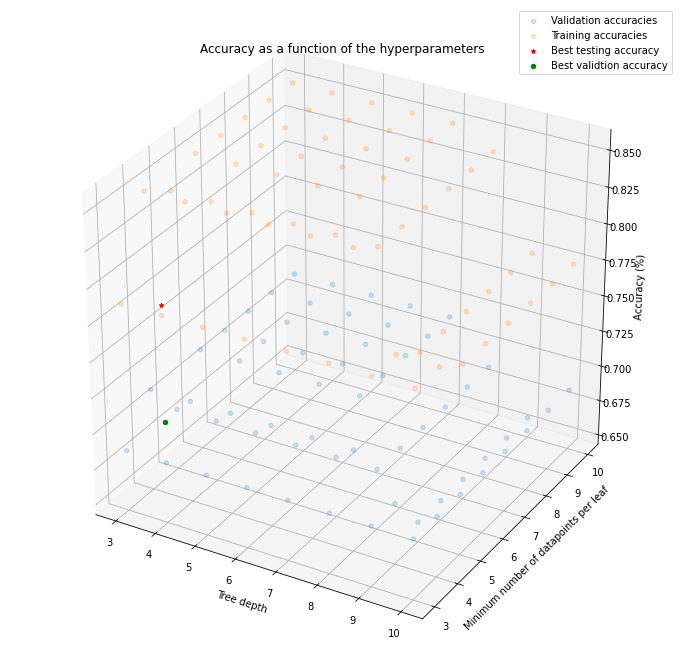

In [ ]:
find_best_params(X_train_hepatitis, y_train_hepatitis, 
              X_validate_hepatitis, y_validate_hepatitis, 
              X_test_hepatitis, y_test_hepatitis, 3, 10, 3, 10,
              is_continuous_feature_hepatitis, cost_entropy)

The result of our test demonstrates that the best hyperparameter for the Hepatitis data is `max_depth = 3` and `min_leaf_datapoints = 6`. This combination of the two hyperparameters yields the highest validation and testing accuracies of `80%` and `79.5%` respectively. 

##### 3.3.2 Diabetes dataset

We will now run the testing function on the Diabetes data to find the best hyperparameters for this dataset.

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 3
we got a validation accuracy of 61.8% and a testing accuracy of 60.3%



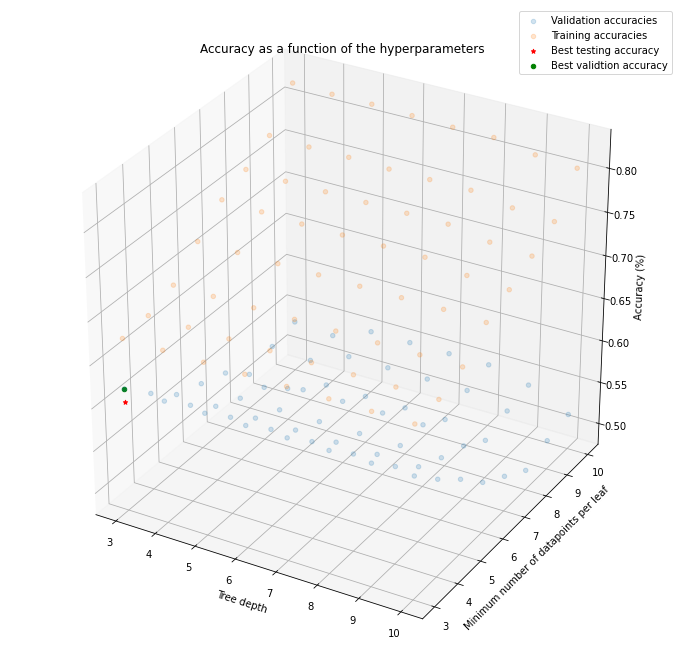

In [ ]:
find_best_params(X_train_diabetes, y_train_diabetes, 
              X_validate_diabetes, y_validate_diabetes, 
              X_test_diabetes, y_test_diabetes, 3, 10, 3, 10,
              is_continuous_feature_diabetes, cost_entropy)

For the diabetes data, the best hyperparameters are `max_depth = 3` and `min_leaf_datapoints = 3` with the validation and testing accuracies of `61.8%` and `60.3%` respectively.

### 3.4 Testing different distance / cost functions

#### 3.4.1 Comparing distance functions for KNN

We will compare the performance of the KNN model on the hepatitis and diabetes dataset using the distance functions `euclidean_distance` and `euclidean_hamming_mix_distance` as defined in the implementation of `KNN`. To compare, we will find the best `k` using both distances, and compare the resulting accuracies.

We would like to visualize the KNN models resulting from using different distance functions by making plots connecting each test node to its nearest neighbors. 

To plot our dataset, we need to reduce it to a 2-dimensional space. The first technique that comes to mind is the Principal Component Analysis (PCA). However, PCA should not be used on data containing categorical inputs[[18]](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60). We will still implement it for curiosity and compare the results with Factor Analysis of Mixed Data (FAMD) [[19]](https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1#:~:text=According%20to%20Wikipedia%2C%20Dimensionality,hundred%20features%20into%20two%20features) provided by `prince` library. Please refer to [[20]](https://github.com/MaxHalford/prince) for the source code.

In short, FAMD works as PCA on continuous features, while performing MCA (Multiple correspondence analysis) on categorical variables [[21]](https://en.wikipedia.org/wiki/Factor_analysis_of_mixed_data), merging the best of both worlds.

We will start by comparing the distance functions on the hepatitis data and then repeat the procedure for the diabetes data. Prior to that, we will implement a utility function that connects each point to its K nearest neighbors.

In [ ]:
# Plots a graph that connect each point to its nearest neighbour
# Inspired by the tutorial code
def scatter_closest_neighbour(x_train, y_train, x_test, y_test, y_pred, k, knns, x_label, y_label, title, alpha_):
  # Boolean array to later slice the indexes of correct and incorrect predictions
  correct = y_test == y_pred
  incorrect = np.logical_not(correct)

  # Visualization of the points
  plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
  plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
  plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

  # Connect each node to k-nearest neighbours in the training set
  for i in range(x_test.shape[0]):
    for j in range(k):
      hor = x_test[i,0], x_train[knns[i,j],0]
      ver = x_test[i,1], x_train[knns[i,j],1]
      plt.plot(hor, ver, 'k-', alpha=alpha_)
      
  plt.title(title)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.legend()

Next, let's define a second utility function that will reduce the dimentionality of the data using FAMD.

In [ ]:
# Returns the reduced training and testing data using FAMD
def train_famd(X_train, X_train_name, X_test, X_test_name, is_continuous_feature): 
  # Convert back to a Pandas dataframe
  X_train_df = pd.DataFrame(X_train, columns=[str(i) for i in range(X_train.shape[1])])
  X_test_df = pd.DataFrame(X_test, columns=[str(i) for i in range(X_test.shape[1])])

  # Convert every categorical feature to type object so that FAMD understands it's categorical
  for i, bool in enumerate(is_continuous_feature):
    if not bool:
      X_train_df = X_train_df.astype({str(i): object}, errors='raise')
      X_test_df = X_test_df.astype({str(i): object}, errors='raise')

  # Now, we can instantiate 2 FAMD instances to reduce the dimensions of the training and testing datasets
  # We used the suggested parameters to train the following models
  famd_train = FAMD(n_components=2, n_iter=4, random_state=1).fit(X_train_df).transform(X_train_df)
  famd_test = FAMD(n_components=2, n_iter=4, random_state=1).fit(X_test_df).transform(X_test_df)
  
  # Change the datadype back to a numpy array accepted by the scatter function above
  return famd_train.to_numpy(), famd_test.to_numpy() 

Let's reduce the dimensionality of `X_train_hepatitis`, `X_test_hepatitis`, `X_train_diabetes` and `X_test_diabetes` to 2. The newly defined variables below will be used again for plotting decision boundaries in section 3.5.

In [ ]:
# Perform dimensionality reduction using PCA
X_train_hepatitis_pca = PCA(n_components=2).fit_transform(X_train_hepatitis)
X_test_hepatitis_pca = PCA(n_components=2).fit_transform(X_test_hepatitis)

X_train_diabetes_pca = PCA(n_components=2).fit_transform(X_train_diabetes)
X_test_diabetes_pca = PCA(n_components=2).fit_transform(X_test_diabetes)

# Perform dimensionality reduction using FAMD
X_train_hepatitis_famd, X_test_hepatitis_famd = train_famd(X_train_hepatitis, 'X_train_hepatitis', X_test_hepatitis, 'X_test_hepatitis', is_continuous_feature_hepatitis)
X_train_diabetes_famd, X_test_diabetes_famd = train_famd(X_train_diabetes, 'X_train_diabetes', X_test_diabetes, 'X_test_diabetes', is_continuous_feature_diabetes)

We can now move on to distance function comparison for KNN.

##### 3.4.1.1 Hepatitis dataset

To begin, we will first find the optimal hyperparameter `k` using `euclidean_distance`.

For k = 5, we got a validation accuracy of 82.857% and a testing accuracy of 82.051%



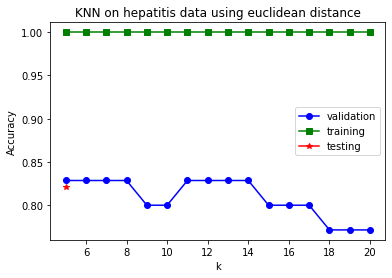

In [ ]:
plt.title('KNN on hepatitis data using euclidean distance')
find_best_k(X_train_hepatitis, y_train_hepatitis, 
            X_validate_hepatitis, y_validate_hepatitis, 
            X_test_hepatitis, y_test_hepatitis, 5, 20, 
            is_continuous_feature_hepatitis, euclidean_distance) # Distance is specified here

We obtain an accuracy of `84.6%`. We'll now train a model with the optimal `k=9` and the `euclidean_distance` function, and extract the KNN array of indices to plot the next graph.

In [ ]:
knn_hepa_euc = KNN(9, is_continuous_feature_hepatitis, euclidean_distance)
knn_hepa_euc_pred, _, knns_hepa_euc = knn_hepa_euc.fit(X_train_hepatitis, y_train_hepatitis).predict(X_test_hepatitis)

We can then proceed to visualize the KNNs of each point in 2D.

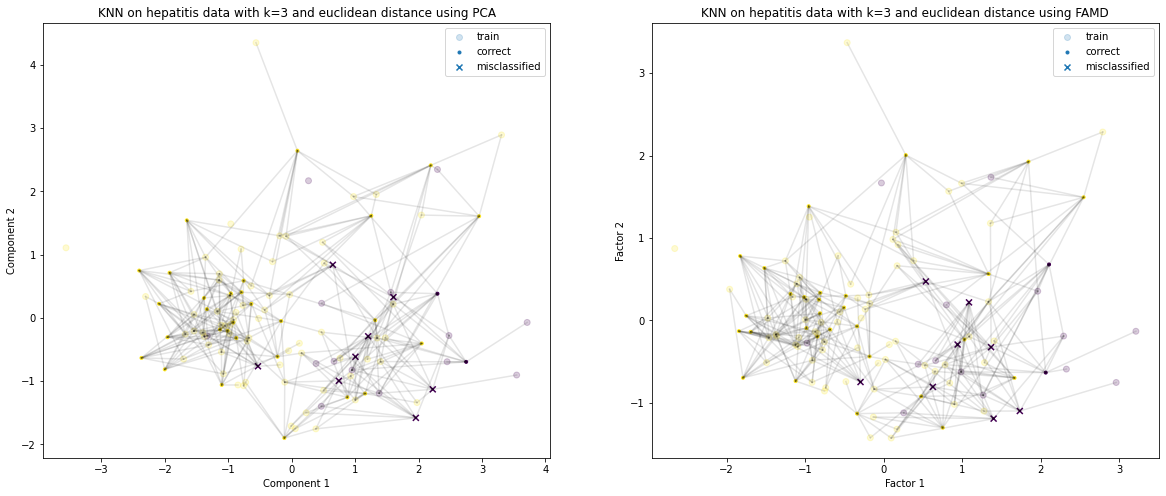

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
scatter_closest_neighbour(X_train_hepatitis_pca, y_train_hepatitis, 
                          X_test_hepatitis_pca, y_test_hepatitis, 
                          knn_hepa_euc_pred, knn_hepa_euc.K, knns_hepa_euc, 
                          'Component 1', 'Component 2', 'KNN on hepatitis data with k=3 and euclidean distance using PCA', 0.1)
plt.subplot(1, 2, 2)
scatter_closest_neighbour(X_train_hepatitis_famd, y_train_hepatitis, 
                          X_test_hepatitis_famd, y_test_hepatitis, 
                          knn_hepa_euc_pred, knn_hepa_euc.K, knns_hepa_euc, 
                          'Factor 1', 'Factor 2', 'KNN on hepatitis data with k=3 and euclidean distance using FAMD', 0.1)

`PCA` and `FAMD` reduction techniques produce very similar plots for now. Their differences will be highlighted in the decision boundary section (3.5).

Let's find the optimal k using `euclidean_hamming_mix_distance` again.

For k = 5, we got a validation accuracy of 88.571% and a testing accuracy of 74.359%



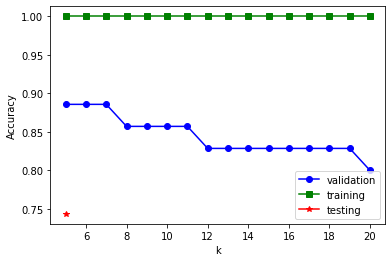

In [ ]:
find_best_k(X_train_hepatitis, y_train_hepatitis, 
            X_validate_hepatitis, y_validate_hepatitis, 
            X_test_hepatitis, y_test_hepatitis, 5, 20, 
            is_continuous_feature_hepatitis, euclidean_hamming_mix_distance) # Distance is specified here

We can see that the `euclidean_hamming_mix_distance` we defined yields better results, with a higher testing accuracy of `89.7%`. Let's now proceed to instantiating and training a model with `k=5`, extracting the KNNs of the testing points.

In [ ]:
knn_hepa_mix = KNN(5, is_continuous_feature_hepatitis, euclidean_hamming_mix_distance)
knn_hepa_mix_pred, _, knns_hepa_mix = knn_hepa_mix.fit(X_train_hepatitis, y_train_hepatitis).predict(X_test_hepatitis)

Again, we can visualize the K nearest neighbors in 2D.

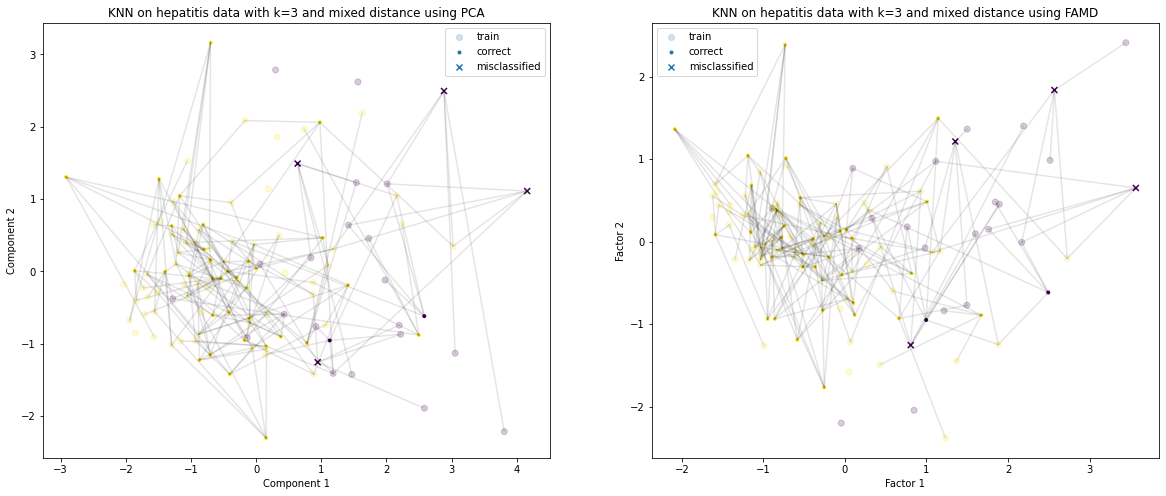

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
scatter_closest_neighbour(X_train_hepatitis_pca, y_train_hepatitis, 
                          X_test_hepatitis_pca, y_test_hepatitis, 
                          knn_hepa_mix_pred, knn_hepa_mix.K, knns_hepa_mix, 
                          'Component 1', 'Component 2', 'KNN on hepatitis data with k=3 and mixed distance using PCA', 0.1)
plt.subplot(1, 2, 2)
scatter_closest_neighbour(X_train_hepatitis_famd, y_train_hepatitis, 
                          X_test_hepatitis_famd, y_test_hepatitis, 
                          knn_hepa_mix_pred, knn_hepa_mix.K, knns_hepa_mix, 
                          'Factor 1', 'Factor 2', 'KNN on hepatitis data with k=3 and mixed distance using FAMD', 0.1)

Again, FAMD and PCA yield very similar results, so we'll come back to this comparison in section 3.5 of the notebook. The conclusion of this section is that the `euclidean_hamming_mix` distance function performed better on the hepatitis dataset, as seen before.

##### 3.4.1.2 Diabetes dataset

Let's now compare the distance functions on the diabetes dataset in a similar fashion as the hepatitis datset. We will start with the `euclidean_distance`.

For k = 8, we got a validation accuracy of 61.455000000000005% and a testing accuracy of 65.066%



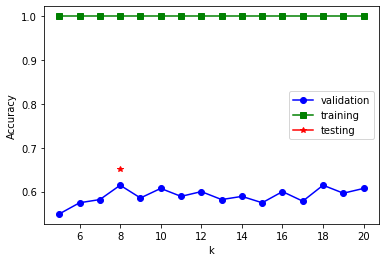

In [ ]:
find_best_k(X_train_diabetes, y_train_diabetes, 
            X_validate_diabetes, y_validate_diabetes, 
            X_test_diabetes, y_test_diabetes, 5, 20, 
            is_continuous_feature_diabetes, euclidean_distance) # Distance is specified here

We obtain a testing accuracy of `65.1%` We then instantiate and train with `k=8`, extracting the KNNs of testing datapoints.

In [ ]:
knn_diab_euc = KNN(8, is_continuous_feature_diabetes, euclidean_distance)
knn_diab_euc_pred, _, knns_diab_euc = knn_diab_euc.fit(X_train_diabetes, y_train_diabetes).predict(X_test_diabetes)

Visualizing the results in 2D using FAMD and PCA gives the results below.

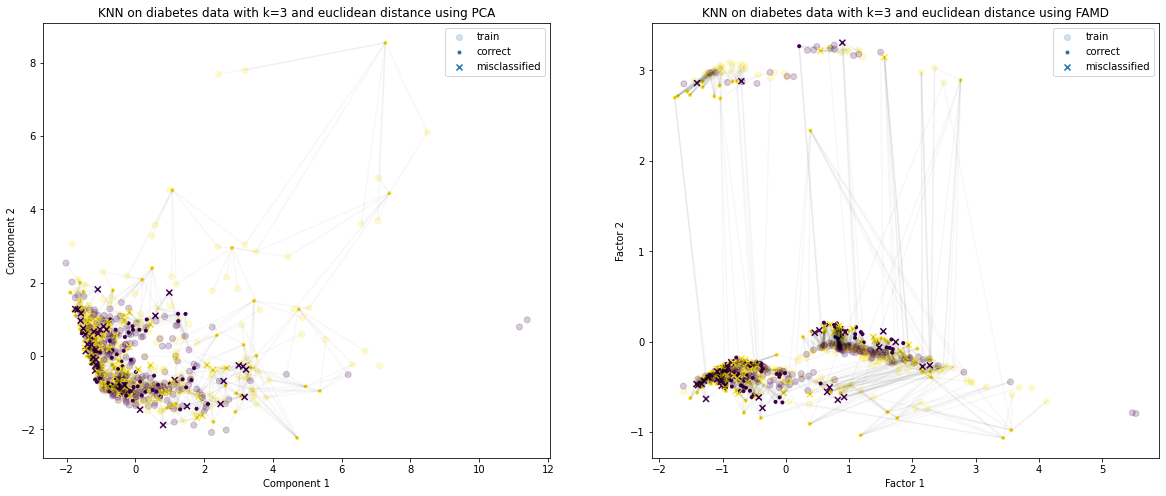

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
scatter_closest_neighbour(X_train_diabetes_pca, y_train_diabetes, 
                          X_test_diabetes_pca, y_test_diabetes, 
                          knn_diab_euc_pred, knn_diab_euc.K, knns_diab_euc, 
                          'Component 1', 'Component 2', 'KNN on diabetes data with k=3 and euclidean distance using PCA', 0.03)
plt.subplot(1, 2, 2)
scatter_closest_neighbour(X_train_diabetes_famd, y_train_diabetes, 
                          X_test_diabetes_famd, y_test_diabetes, 
                          knn_diab_euc_pred, knn_diab_euc.K, knns_diab_euc, 
                          'Factor 1', 'Factor 2', 'KNN on diabetes data with k=3 and euclidean distance using FAMD', 0.03)

`PCA` and `FAMD` produced two different results when visualizing the diabetes data. `PCA` clusters the points into one very large section, whereas `FAMD` clusters the points into two or three. In both cases, we notice that the clusters are very dense, with positive and negative labels being in close proximity. The bad quality of the splits could explain the reason why the accuracy of the models on the diabetes data is lower in comparison with the hepatitis data. Howeverm, the FAMD representation is preferable to the PCA one since it more or less separates different labels, as will be demonstrated in the decision boundary plot in section 3.5 later on.

Let's now proceed to compare the above to the `euclidean_hamming_mix_distance`.

For k = 8, we got a validation accuracy of 60.0% and a testing accuracy of 64.19200000000001%



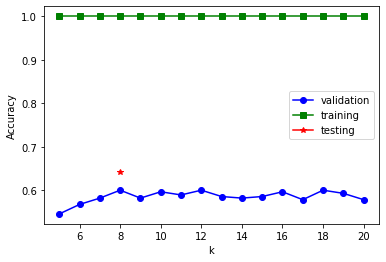

In [ ]:
find_best_k(X_train_diabetes, y_train_diabetes, 
            X_validate_diabetes, y_validate_diabetes, 
            X_test_diabetes, y_test_diabetes, 5, 20, 
            is_continuous_feature_diabetes, euclidean_hamming_mix_distance) # Distance is specified here

We get an accuracy of `64.1%`, which is a bit worse than with `euclidean_distance` for this dataset. Let's instantiate and train a model with the optimal `k=8`. 

In [ ]:
knn_diab_mix = KNN(8, is_continuous_feature_diabetes, euclidean_hamming_mix_distance)
knn_diab_mix_pred, _, knns_diab_mix = knn_diab_mix.fit(X_train_diabetes, y_train_diabetes).predict(X_test_diabetes)

Visualizing the results in 2D using FAMD and PCA gives the results below.

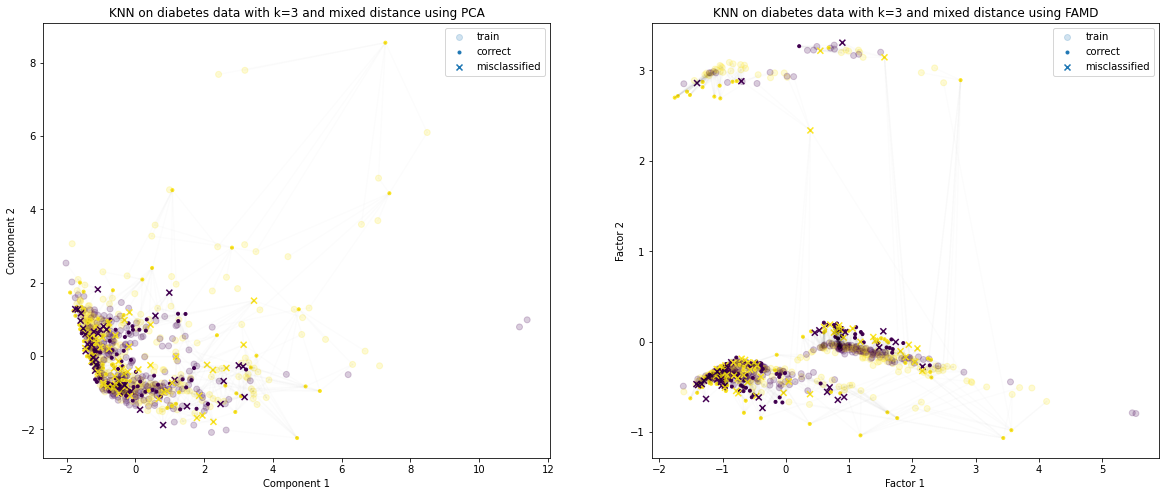

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
scatter_closest_neighbour(X_train_diabetes_pca, y_train_diabetes, 
                          X_test_diabetes_pca, y_test_diabetes, 
                          knn_diab_mix_pred, knn_diab_mix.K, knns_diab_mix, 
                          'Component 1', 'Component 2', 'KNN on diabetes data with k=3 and mixed distance using PCA', 0.01)
plt.subplot(1, 2, 2)
scatter_closest_neighbour(X_train_diabetes_famd, y_train_diabetes, 
                          X_test_diabetes_famd, y_test_diabetes, 
                          knn_diab_mix_pred, knn_diab_mix.K, knns_diab_mix, 
                          'Factor 1', 'Factor 2', 'KNN on diabetes data with k=3 and mixed distance using FAMD', 0.01)

`FAMD` provided slghtly better visualizations than `PCA` since it declustered the data more. Furthermore, the accuracy of `euclidean_distance` was slightly higher for this dataset, which makes it the better distance function for this situation since it is much less computationally intensive for the same or even slightly better results.

#### 3.4.2 Comparing cost functions for Decision Tree

We will also compare the performance of the Decision Tree model on the hepatitis and diabetes dataset using the cost functions `cost_entropy` and `cost_gini_index` as defined in the implementation of the Decision Tree. We will start by comparing the cost function on the hepatitis data and then repeat the procedure for the diabetes data. 

To effectuate the comparison, we will use the find_best_params fucntions we wrote to evaluate the best hyperparameters of the Decision tree for each dataset. This time we will compare different hyperparameter values along with the two different cost function and retain the best combination of these 3 parameters.

##### 3.4.2.1 Hepatitis dataset

We will first evaluate the accuracy of the model using the  `cost_entropy` cost function.

For a minimum number of datapoints in leaf nodes of 6 and a maximum depth of 3
we got a validation accuracy of 80.0% and a testing accuracy of 79.5%



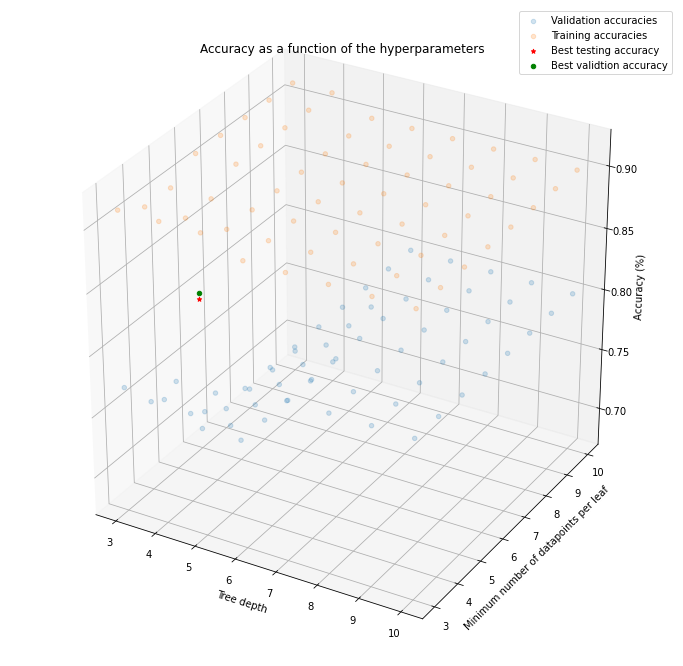

In [ ]:
find_best_params(X_train_hepatitis, y_train_hepatitis, 
              X_validate_hepatitis, y_validate_hepatitis, 
              X_test_hepatitis, y_test_hepatitis, 3, 10, 3, 10,
              is_continuous_feature_hepatitis, cost_entropy)

We can see the best hyperparameters and the best accuracy printed above. We will now evaluate the accuracy of the model using the `cost_gini_index` cost function.

For a minimum number of datapoints in leaf nodes of 6 and a maximum depth of 3
we got a validation accuracy of 80.0% and a testing accuracy of 79.5%



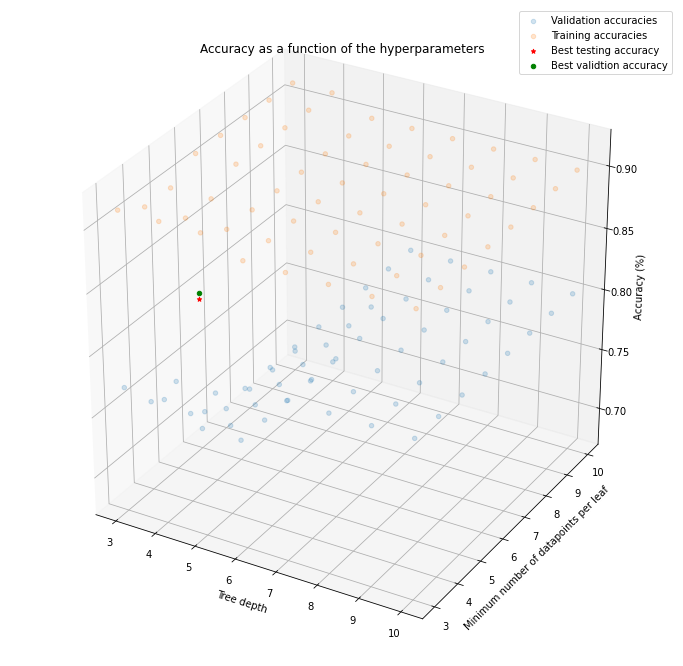

In [ ]:
find_best_params(X_train_hepatitis, y_train_hepatitis, 
              X_validate_hepatitis, y_validate_hepatitis, 
              X_test_hepatitis, y_test_hepatitis, 3, 10, 3, 10,
              is_continuous_feature_hepatitis, cost_gini_index)

Again, we can see the results above. Finally, we will use the `cost_misclassification` function.

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 3
we got a validation accuracy of 80.0% and a testing accuracy of 89.7%



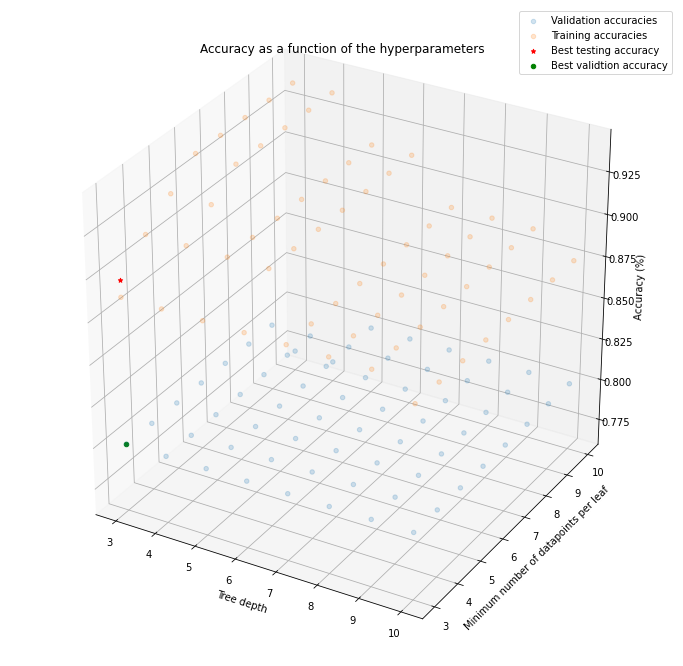

In [ ]:
find_best_params(X_train_hepatitis, y_train_hepatitis, 
              X_validate_hepatitis, y_validate_hepatitis, 
              X_test_hepatitis, y_test_hepatitis, 3, 10, 3, 10,
              is_continuous_feature_hepatitis, cost_misclassification)

As a conclusion of these two tests, the `cost_entropy` and `cost_gini_index` both have the same accuracy of `79.5%` with the best hyperparameters being `min_leaf_datapoints=6` and `max_depth=3` for both. They thus behave very similarly. In contrast, the `cost_misclassification` function leads to the best results, with a testing accuracy of 89.7% and hyperparameters `min_leaf_datapoints=3` and `max_depth=3`. It is to be noted that the maximum depth is low for this dataset since we have very little testing data, which means higher depths will overfit.

##### 3.4.2.2 Diabetes dataset

We will first evaluate the accuracy of the model using the  `cost_entropy` cost function on the diabetes dataset as follow.

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 3
we got a validation accuracy of 61.8% and a testing accuracy of 60.3%



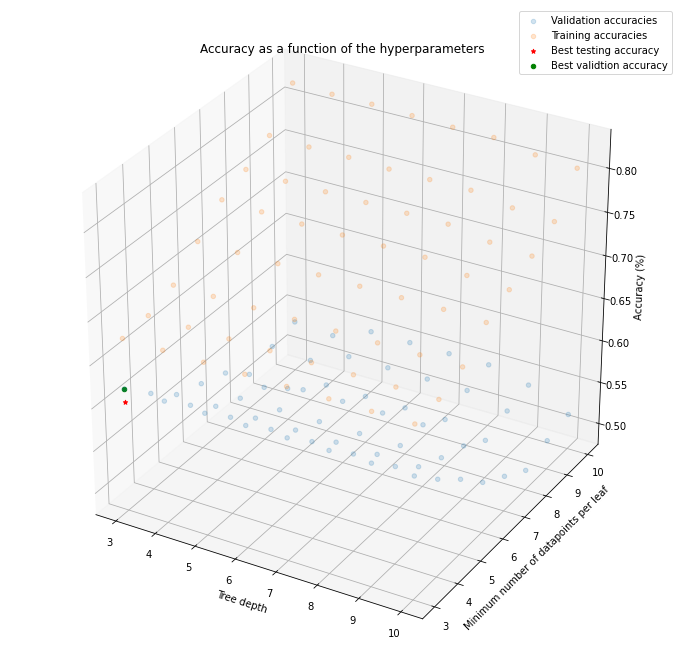

In [ ]:
find_best_params(X_train_diabetes, y_train_diabetes, 
              X_validate_diabetes, y_validate_diabetes, 
              X_test_diabetes, y_test_diabetes, 3, 10, 3, 10,
              is_continuous_feature_diabetes, cost_entropy)

We can see the results above. We will now evaluate the accuracy of the model using the  `cost_gini_index` cost function on the diabetes dataset as follow.

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 3
we got a validation accuracy of 61.8% and a testing accuracy of 60.3%



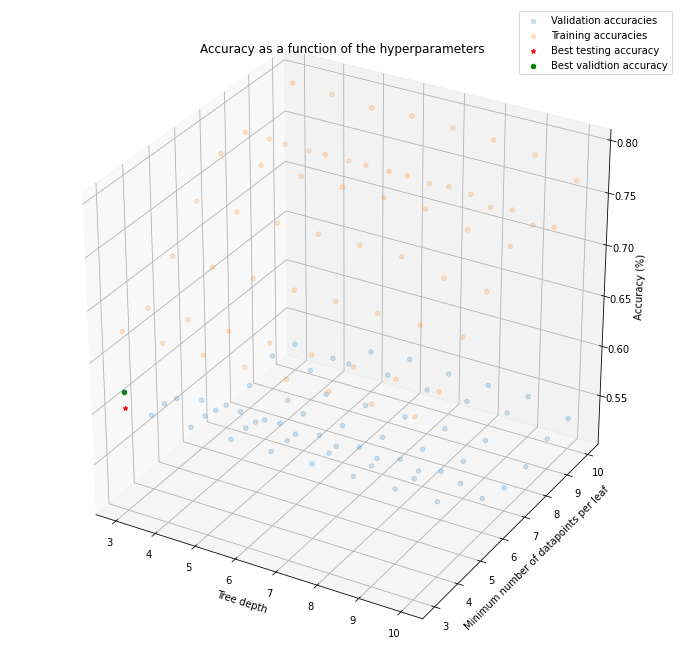

In [ ]:
find_best_params(X_train_diabetes, y_train_diabetes, 
              X_validate_diabetes, y_validate_diabetes, 
              X_test_diabetes, y_test_diabetes, 3, 10, 3, 10,
              is_continuous_feature_diabetes, cost_gini_index)

Again, we can see the results above. Finally, using `cost_misclassification` as the cost function:

For a minimum number of datapoints in leaf nodes of 3 and a maximum depth of 4
we got a validation accuracy of 62.2% and a testing accuracy of 53.7%



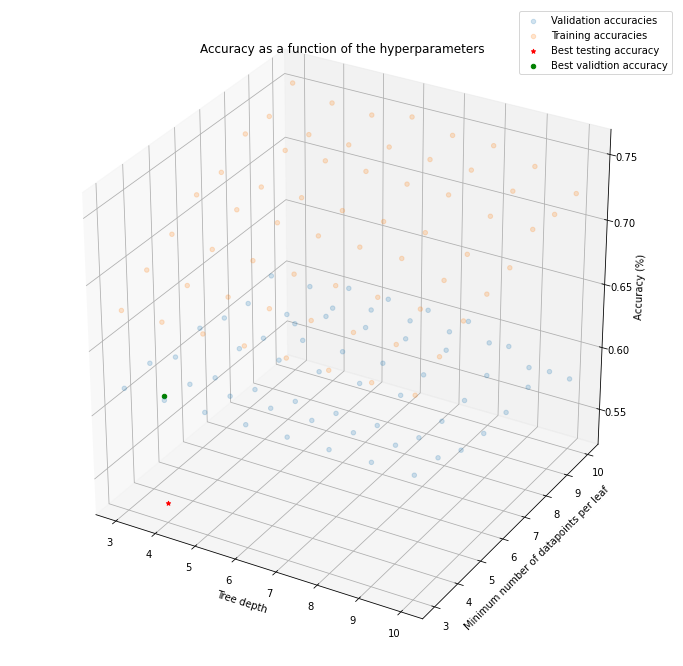

In [ ]:
find_best_params(X_train_diabetes, y_train_diabetes, 
              X_validate_diabetes, y_validate_diabetes, 
              X_test_diabetes, y_test_diabetes, 3, 10, 3, 10,
              is_continuous_feature_diabetes, cost_misclassification)

As a conclusion of these two tests, the `cost_entropy` and `cost_gini_index` both again have the same accuracy of `60.3%` with the best hyperparameters being `min_leaf_datapoints=3` and `max_depth=3` for both. They thus behave very similarly to build the best tree for both datasets. In contrast, `cost_misclassification` yields a testing accuracy of 53.7% for `min_leaf_datapoints=3` and `max_depth=4`, showing that while it might have been better for the hepatitis dataset, it is unreliable for this second dataset. Furthermore, as shown in the lecture slides, we prefer using `cost_entropy` or `cost_gini_index` since they reflect the differences in homogeneity of tree nodes better.

### 3.5 Decision boundary plots

To plot the decision boundary, we will make two helper functions that will train KNN and DT instances on the training data reduced to two dimensions. We will do so because it is very computationaly heavy to produce a meshgrid with all possible combinations of 10 to 15 features. Like we did previously, we will attempt both `PCA` and `FAMD` techniques to visualize the dimensionality reduction for the hepatitis and diabetes datasets.

**Assumptions:**

For the `decision_boundary_KNN` function, we wil make two assumtions: we only have continuous features since the type of output provided by the `PCA` and `FAMD` function is a continuous value. From this, we draw our second assumption: The distance function should be only euclidean because we have no categorical features, so hamming distance won't be useful.

As for the `decision_boundary_DT` method we will also assume that the features are continuous, for the same reason. Moreover, we will assume that the cost function is `cost_entropy` since it gave better accuracy on both datasets in the previous tests.

In [ ]:
# This function will plot the decision boundary for the KNN model
# It assumes the features are continuous and the distance function is set to euclidean distance
# The code is inspired by the tutorial
def decision_boundary_KNN(samples, X_train_2d, y_train, k, dimension_reducing_method, x_label, y_label):

  # Make evenly-spaced points in the dimension range of two factors/components
  x0v = np.linspace(np.min(X_train_2d[:,0]), np.max(X_train_2d[:,0]), samples)
  x1v = np.linspace(np.min(X_train_2d[:,1]), np.max(X_train_2d[:,1]), samples)

  # Make a meshgrid that fills the graph with a grid of all possible combinations of x0v and x1v
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(), x1.ravel())).T

  # Train a KNN model with the specified k on the 2d training data and corresponding labels
  # Pass [True, True] to consider both reduced features as continuous (is_continuous_array)
  knn = KNN(k, [True, True], euclidean_distance).fit(X_train_2d, y_train)

  # Set colors for training data 
  y_train_color = np.zeros((y_train.shape[0], 3))
  y_train_color[np.arange(y_train.shape[0]), y_train] = 1

  # Predict the meshgrid points
  y_pred_all, _, _ = knn.predict(x_all)

  # Set colors for meshgrid points
  y_pred_color =  np.zeros((x_all.shape[0], 3))
  y_pred_color[np.arange(x_all.shape[0]), y_pred_all] = 1

  # Plot the training points
  plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train_color, marker='o', alpha=1)

  # Plot the meshgrid points
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_color, marker='.', alpha=0.05)

  plt.xlabel(f'{x_label}')
  plt.ylabel(f'{y_label}')
  plt.title(f'KNN boundaries for k = {k} using {dimension_reducing_method}') 

# This function will plot the decision boundary for the Decision Tree model
# It assumes the features are continuous and the cost function is cost_entropy
# The code is inspired by the tutorial
def decision_boundary_DT(samples, X_train_2d, y_train, min_leaf_datapoints, max_depth, 
                         dimension_reducing_method, x_label, y_label):
  # Make evenly-spaced points in the dimension range of two factors/components
  x0v = np.linspace(np.min(X_train_2d[:,0]), np.max(X_train_2d[:,0]), 200)
  x1v = np.linspace(np.min(X_train_2d[:,1]), np.max(X_train_2d[:,1]), 200)

  # Make a meshgrid that fills the graph with a grid of all possible combinations of x0v and x1v
  x0,x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  # Train a DT model with the specified parameters on the 2d training data and corresponding labels
  dt = DecisionTree(min_leaf_datapoints, max_depth, cost_entropy, [True, True])

  # Set colors for training data 
  y_train_color = np.zeros((y_train.shape[0], 3))
  y_train_color[np.arange(y_train.shape[0]), y_train] = 1

  # Predict the meshgrid points
  y_pred_all, _ = dt.fit(X_train_2d, y_train).predict(x_all)

  # Set colors for meshgrid points
  y_pred_color =  np.zeros((x_all.shape[0], 3))
  y_pred_color[np.arange(x_all.shape[0]), y_pred_all] = 1

  # Plot the training points
  plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train_color, marker='o', alpha=1)

  # Plot the meshgrid points
  plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_color, marker='.', alpha=0.05)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(f'Decision Tree boundaries with max_depth = {max_depth} using {dimension_reducing_method}')

Since both of our functions take-in the reduced `X_train_hepatitis` and `X_train_diabetes` datasets, we will reuse the same variables we defined in the section 4.1: `X_train_hepatitis_pca`, `X_train_hepatitis_famd`, `X_train_diabetes_pca` and `X_train_diabetes_famd`.

#### 3.5.1 Hepatitis dataset

First, let's plot the KNN decision boundary for the hepatitis data, for the best `k=5` found in section 3.2 of the notebook.

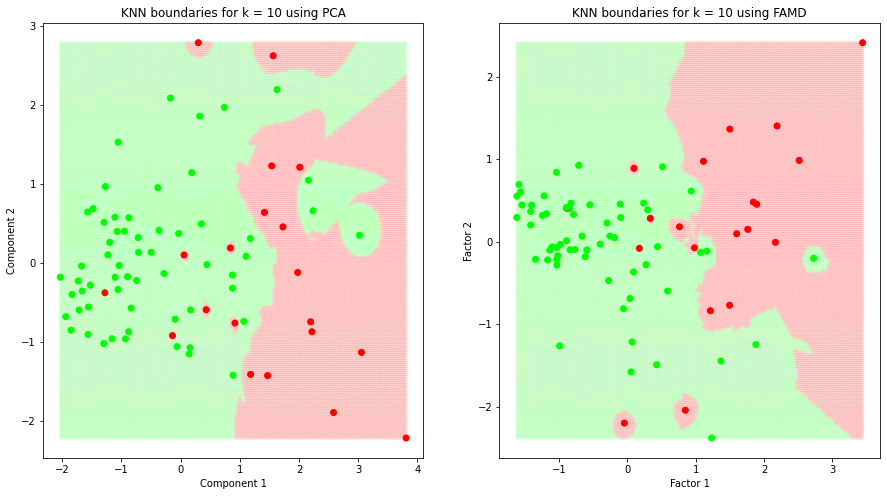

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1) # Plot at index 1
decision_boundary_KNN(200, X_train_hepatitis_pca, y_train_hepatitis, 10, 'PCA', 'Component 1', 'Component 2')
plt.subplot(1, 2, 2) # Plot at index 2
decision_boundary_KNN(200, X_train_hepatitis_famd, y_train_hepatitis, 10, 'FAMD', 'Factor 1', 'Factor 2')

We can see that FAMD is slightly better at separating the boundaries of the regions, while PCA has a small green area in the red region. Furthermore, we can see that, for every point that ended up in the wrong region (ie a red point in a green region), the perturbation it causes in that region is very small. However, a hypothesis would be that an unweighted `KNN` model would cause even less perturbations when a point ends up in the wrong region since its K nearest neighbors would be all from that region's color and would affect it just as much as the perturbator point, thus negating its effect. The above is one of the few downsides of `weighted KNN`.

 Now, let's compare the Decision Tree outputs on the hepatitis dataset with the optimized hyperparameters `max_depth = 3` and `min_leaf_datapoints = 6` found in section 3.1.

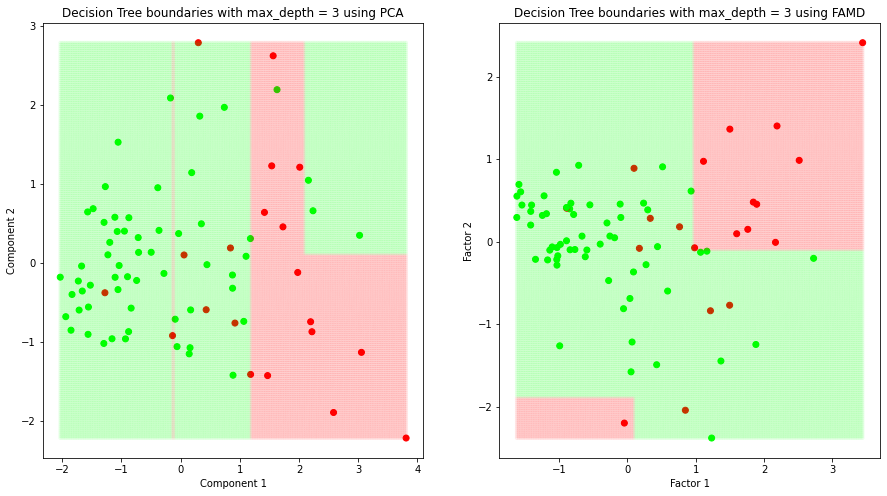

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1) # Plot at index 1
decision_boundary_DT(200, X_train_hepatitis_pca, y_train_hepatitis, 6, 3, 'PCA', 'Component 1', 'Component 2')
plt.subplot(1, 2, 2) # Plot at index 2
decision_boundary_DT(200, X_train_hepatitis_famd, y_train_hepatitis, 6, 3, 'FAMD', 'Factor 1', 'Factor 2')

This plot shows more of the differences between `PCA` and `FAMD` method. We can see that `PCA` once again struggles to separate the two labels while `FAMD` succeeds at defining two clear regions.

From observing these four graphs, we can conclude that `FAMD` gives much better decision boundaries than `PCA` and therefore is better suited to plotting decision boundaries for the `hepatitis` data. Let's now perform the same test on the `diabetes` data.

#### 3.5.2 Diabetes dataset

Now, let's plot the KNN decision boundary for the diabetes data and compare the results of the two methods, using the best `k=8` found in section 3.2.2

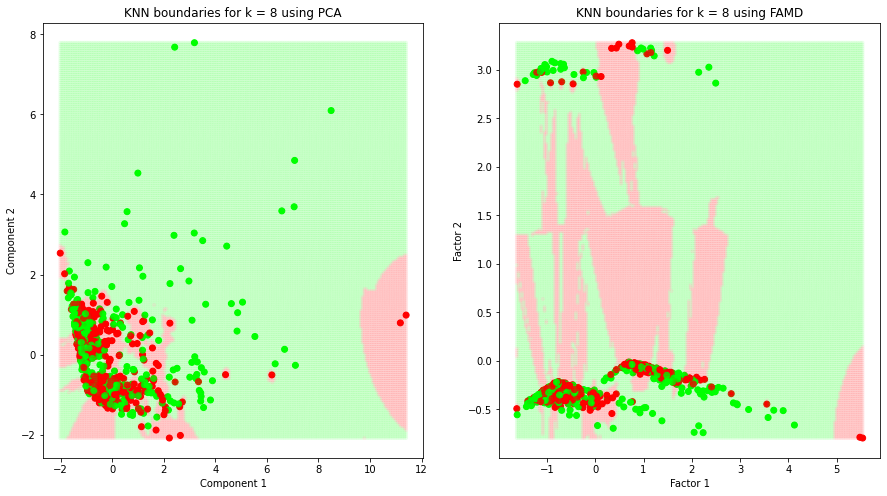

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1) # Plot at index 1
decision_boundary_KNN(200, X_train_diabetes_pca, y_train_diabetes, 8, 'PCA', 'Component 1', 'Component 2')
plt.subplot(1, 2, 2) # Plot at index 2
decision_boundary_KNN(200, X_train_diabetes_famd, y_train_diabetes, 8, 'FAMD', 'Factor 1', 'Factor 2')

As we previously seen, the diabetes' dataset is of low quality, which means that `PCA` and `FAMD` will result in bad visualizations. However, `FAMD` still resulted in a better separation of the datapoints. A possible interpretation of the decision boundaries is that the KNN model will predict `1` for a larger proportion of input testing points since the color green is dominating the plot.

We repeat the above for decision tree with the optimal hyperparameters `min_leaf_datapoints=3` and `max_depth=3` found in section 3.3.2 of the notebook.

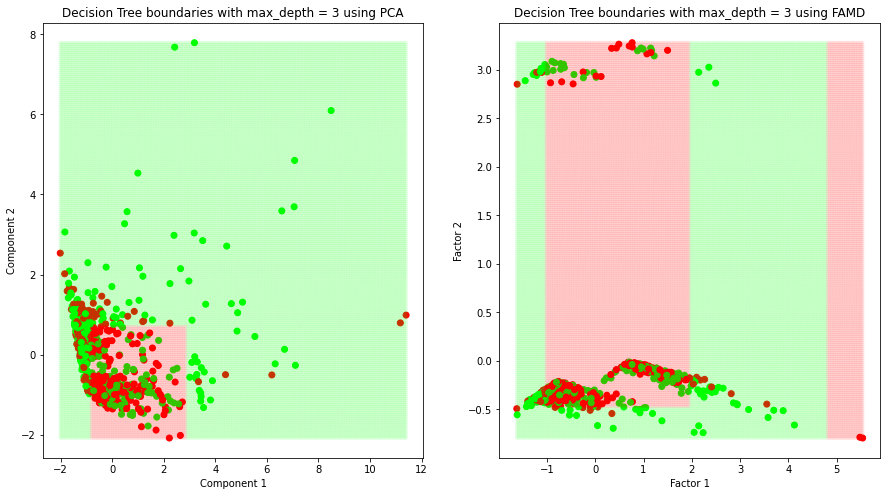

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1) # Plot at index 1
decision_boundary_DT(200, X_train_diabetes_pca, y_train_diabetes, 3, 3, 'PCA', 'Component 1', 'Component 2')
plt.subplot(1, 2, 2) # Plot at index 2
decision_boundary_DT(200, X_train_diabetes_famd, y_train_diabetes, 3, 3, 'FAMD', 'Factor 1', 'Factor 2')

Again, `FAMD` performs better at splitting the bad quality data. Furthermore, for the `FAMD` split, we can see that we have a bigger red area on the decision boundary graph, meaning it was able to show the areas where red gets predicted whereas `PCA` failed at achieving that.

### 3.6 Key feature identification

#### 3.6.1 Mean decrease in impurity

We will start by using random forests to plot feature importance based on MDI (Mean decrease in impurity) [[22]](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html). To achieve this goal, we will start by defining a function that takes in `X_train` and `y_train`, training a `Random Forest` classifier to perform the above. Feature importances are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Note: For this section, we only will consider the features we didn't remove in the pre-processing section

In [ ]:
def plot_feature_importance_MDI(X_train, y_train, feature_names):
  
  # Train and fit random forest classifier
  forest = RandomForestClassifier(random_state=0)
  forest.fit(X_train, y_train)

  # Extract the feature importances
  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

  # Build a dataframe
  forest_importances = pd.Series(importances, index=feature_names)

  # Plot the results
  fig, ax = plt.subplots()
  forest_importances.plot.bar(yerr=std, ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()

Using the above function on the hepatitis dataset:

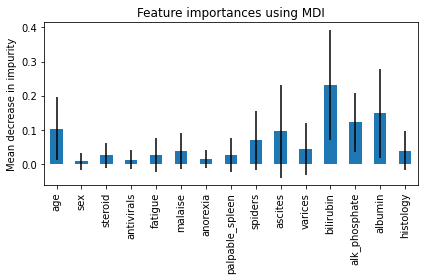

In [ ]:
plot_feature_importance_MDI(X_train_hepatitis, y_train_hepatitis, features_hepatitis)

We can see that `bilirubin`, `albumin`, and `age` stand out as the best features for this dataset. Furthermore, we can see that we have a lot of features for this dataset that have a lower relatve importance, which is the result of not filtering out too many of them in the pre-processing section since we need to keep more features to account for the small size of the dataset.

Repeating the above for the `diabetes` dataset:

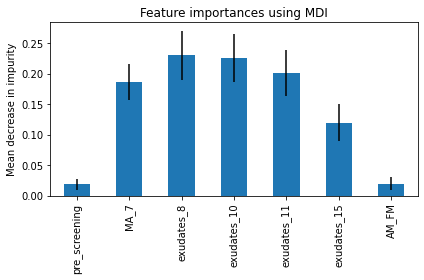

In [ ]:
plot_feature_importance_MDI(X_train_diabetes, y_train_diabetes, features_diabetes)

We can see that `MA_7`, `exudates_8`, `exudates_10`, `exudates_11`, `exudates_15` are the most important features for this model. We can also see that, suprisingly, this dataset has a lot of important features, while we filtered out most of the unnecessary features in the pre-processing section due to the huge number of datapoints and the long training times.

#### 3.6.2 Analysis of the correlation to the ouput label

We will now show the key features using their correlation to the output for each dataset. In the pre-processing section of the assignment, we removed the features that had very low correlation with the output label but did not show which features were the most important regarding that factor.

Note: For this section, we will again only consider features that were not removed in the pre-processing section, since those had very little correlation with the output and didn't yield interesting results

We first evaluate the correlation of the features to the output for the hepatitis data-set:

In [ ]:
# Extract the correlation of every feature with the output class
# df_hepatitis.corr() returns the correlation of each possible pair of columns
# Selecting the class column from the above leaves us with the correlation of each column with class
# iloc[1:] then filters out the correlation of class with itself
hepatitis_class_corr = df_hepatitis.corr()['class'].iloc[1:]

# Sort the correlations in the pandas series in ascending order of ABSOLUTE VALUE
hepatitis_class_corr = hepatitis_class_corr.iloc[hepatitis_class_corr.abs().argsort()]

# Print the features and their correlation to the output in adcending order
for feature, corr in hepatitis_class_corr.items():
  if feature in features_hepatitis:
    print(f"Feature {feature} has correlation {corr} with the label.")

Feature antivirals has correlation -0.13180310158422473 with the label.
Feature anorexia has correlation 0.132172131147541 with the label.
Feature alk_phosphate has correlation -0.13986576597666295 with the label.
Feature steroid has correlation 0.14138711436988508 with the label.
Feature sex has correlation 0.1682415664237612 with the label.
Feature age has correlation -0.21743413128870417 with the label.
Feature palpable_spleen has correlation 0.23301645527602222 with the label.
Feature fatigue has correlation 0.3036238898771819 with the label.
Feature histology has correlation -0.33603329346500743 with the label.
Feature malaise has correlation 0.33785926119290477 with the label.
Feature varices has correlation 0.3616439401780166 with the label.
Feature spiders has correlation 0.3877625892359525 with the label.
Feature bilirubin has correlation -0.44987379395343663 with the label.
Feature albumin has correlation 0.4654270712392148 with the label.
Feature ascites has correlation 0.46

Thus, for the hepatitis data-set, the 3 best features in determining the output label are `ascites`, `albumin`,and `bilirubin` because of their high correlation to the output. This works well with the results we found in section 3.6.1 using MDI. The surprising result, however, is that age isn't very well correlated with the output while it was deemed to be one of the most important features by MDI. This shows the limitations of considering correlation to the output label which only considers a linear relationship with that output.

 We now move on to the diabetes dataset.

In [ ]:
# Extract the correlation of every feature with the output class
# df_diabetes.corr() returns the correlation of each possible pair of columns
# Selecting the class column from the above leaves us with the correlation of each column with class
# iloc[:-1] then filters out the correlation of class with itself
diabetes_class_corr = df_diabetes.corr()['class'].iloc[:-1]

# Sort the corrolations in the pandas series in ascending order of ABSOLUTE VALUE
diabetes_class_corr = diabetes_class_corr.iloc[diabetes_class_corr.abs().argsort()]

# Print the features and their correlation to the output in adcending order
for feature, corr in diabetes_class_corr.items():
  if feature in features_diabetes:
    print(f"Feature {feature} has correlation {corr} with the label.")

Feature AM_FM has correlation -0.039344050294969415 with the label.
Feature exudates_10 has correlation 0.04020213344700415 with the label.
Feature exudates_8 has correlation 0.06084983762886164 with the label.
Feature pre_screening has correlation -0.0783148921626614 with the label.
Feature exudates_11 has correlation 0.10558874498200982 with the label.
Feature MA_7 has correlation 0.12458909646387298 with the label.
Feature exudates_15 has correlation 0.17816603793695 with the label.


As a conclusion, for the diabetes data-set, the three key features in determining the output label are `exudates_15`, `MA_7`, `exudates_11` because of their high correlation to the output. However, comparing to the hepatitis dataset, we can see that the features have much lower correlations to the output, again due to the quality of the data.

#### 3.6.3 Feature usage frequency in the decision tree fitting process

For decision tree, we can get a idea of the relative feature importance by seeing how many times each feature was used, as seen in the lecture slides.

We start by defining the function below that builds a dictionary of the frequency of usage of each feature.

In [ ]:
def find_key_features(node, dataset, features):
  # Preorder traversal: add the occurence of features of the left substructure 
  if node.left != None:
    find_key_features(node.left, dataset, features)

  # Increase the occurrence of the feature at the current node
  # Exclude leaf nodes (contains the label)
  if (node.feature != None):
    # Depending on the dataset we are working with
    if dataset == "hepatitis":
        # Increase the occurence of the feature at this node
        features[features_hepatitis[node.feature]] += 1
    elif dataset == "diabetes":
        features[features_diabetes[node.feature]] += 1

  # add the occurence of features of the left substructure 
  if node.right != None:
    find_key_features(node.right, dataset, features)
  
  return features
    

We will now use this function on the decision tree we obtained for the `hepatitis` dataset.

In [ ]:
# Create the dictionnary: key = heaptitis features, values all set to zero (the fucntion counts the number of times the feature is used as a split in the decision tree)
features = dict(zip(features_hepatitis, [0]*len(features_hepatitis)))

# Call the function to count the number of times each feature is used as a split in the decision tree
key_features_dt = find_key_features(dt_hepatitis.root, "hepatitis", features)

# Print the results, sorted in increasing order of frequency
print(dict(sorted(key_features_dt.items(), key=lambda item: item[1])))

{'sex': 0, 'steroid': 0, 'antivirals': 0, 'fatigue': 0, 'malaise': 0, 'anorexia': 0, 'palpable_spleen': 0, 'spiders': 0, 'alk_phosphate': 0, 'albumin': 0, 'histology': 0, 'age': 1, 'ascites': 1, 'varices': 1, 'bilirubin': 2}


For the hepatitis dataset, the key features in the decision tree were thus the following:`bilirubin`, `age`, `varices` and `ascites`. It is interesting that `albumin` wasn't used even though it is one of the most important features, as per section 3.6.1 of the notebook.

We repeat the same process for the `diabetes` dataset below.

In [ ]:
features = dict(zip(features_diabetes, [0]*len(features_diabetes)))

# Call the function to count the number of times each feature is used as a split in the decision tree
key_features_dt = find_key_features(dt_diabetes.root, "diabetes", features)

# Print the results, sorted in increasing order of frequency
print(dict(sorted(key_features_dt.items(), key=lambda item: item[1])))

{'pre_screening': 0, 'MA_7': 0, 'exudates_11': 0, 'AM_FM': 0, 'exudates_10': 1, 'exudates_15': 2, 'exudates_8': 3}


The key features used in constructing the decision tree for the diabetes data-set are the following: `exudates_8`, `exudates_15` and `exudates_10`. It is again surprising to see that `exudates_11` was not used when it was deemed to be important in sections 3.6.1 and 3.6.1 of the notebook. This is probably due to correlation and MDI considering each variable separately, while some combinations of variables might be more effective.

# References

* [1] http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis
* [2] https://www.naukri.com/learning/articles/handling-missing-data-mean-median-mode/#Mean/-Median-/Mode-imputation
* [3] https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
* [4] https://seaborn.pydata.org/generated/seaborn.heatmap.html
* [5] https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap
* [6] https://www.researchgate.net/figure/Guidance-of-correlation-coefficient-interpretation_tbl1_322638699
* [7] https://researchcommons.waikato.ac.nz/handle/10289/15043
* [8] https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python
* [9] https://www.machinelearningplus.com/plots/matplotlib-histogram-python-examples\
* [10] https://www.graphpad.com/support/faq/testing-data-for-normal-distrbution
* [11] https://machinelearningmastery.com/data-preparation-without-data-leakage
* [12] https://online.stat.psu.edu/stat200/book/export/html/38
* [13] https://archive.ics.uci.edu/ml/machine-learning-databases/00329/
* [14] https://en.wikipedia.org/wiki/Exponential_distribution
* [15] https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5
* [16] https://medium.com/@mohdsaeed.khan25/what-is-weighted-knn-and-how-does-it-work-aa8e461fd5d7
* [17] https://mljar.com/blog/visualize-decision-tree/
* [18] https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* [19] https://towardsdatascience.com/5-must-know-dimensionality-reduction-techniques-via-prince-e6ffb27e55d1
* [20] https://github.com/MaxHalford/prince
* [21] https://en.wikipedia.org/wiki/Factor_analysis_of_mixed_data
* [22] https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html